In [1]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
import warnings

2025-10-16 22:58:01.062482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 22:58:10.398192: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("cleaned_traffic_data.csv")

In [4]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [5]:
df.drop(columns=["Avg Speed"], inplace=True)

In [6]:
df = df[df['Total Flow'].notna()]

In [7]:
duplicates = df.index.duplicated().sum() #check the number of duplicates 
print("duplicates:", duplicates)

duplicates: 0


In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

In [9]:
df

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type
Timestamp,,,,,,,
2024-10-01 00:00:00,308512,50,W,497.0,0,197,ML
2024-10-01 00:00:00,311831,5,S,27.0,92,101,OR
2024-10-01 00:00:00,311832,5,S,78.0,92,101,FR
2024-10-01 00:00:00,311844,5,N,43.0,92,202,OR
2024-10-01 00:00:00,311847,5,N,73.0,92,303,OR
...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,S,68.0,96,118,ML
2024-12-31 23:00:00,3900021,50,E,803.0,67,292,ML
2024-12-31 23:00:00,3900022,50,E,509.0,0,0,HV


In [10]:
df["Station"].nunique() #There are 1,806 unique stations im the dataset 

1806

In [11]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df["Month"] = df.index.month

In [12]:
df

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Hour,Day,Weekday,Month
Timestamp,,,,,,,,,,,
2024-10-01 00:00:00,308512,50,W,497.0,0,197,ML,0,1,1,10
2024-10-01 00:00:00,311831,5,S,27.0,92,101,OR,0,1,1,10
2024-10-01 00:00:00,311832,5,S,78.0,92,101,FR,0,1,1,10
2024-10-01 00:00:00,311844,5,N,43.0,92,202,OR,0,1,1,10
2024-10-01 00:00:00,311847,5,N,73.0,92,303,OR,0,1,1,10
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,S,68.0,96,118,ML,23,31,1,12
2024-12-31 23:00:00,3900021,50,E,803.0,67,292,ML,23,31,1,12
2024-12-31 23:00:00,3900022,50,E,509.0,0,0,HV,23,31,1,12


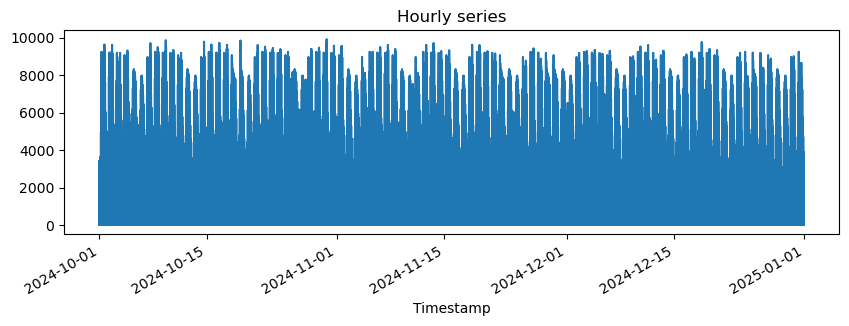

In [13]:
ax = df['Total Flow'].plot(figsize=(10,3), title='Hourly series') #from the plot there is both a daily and weekly strudture in the traffic flow 

<Axes: title={'center': 'Daily mean'}, xlabel='Timestamp'>

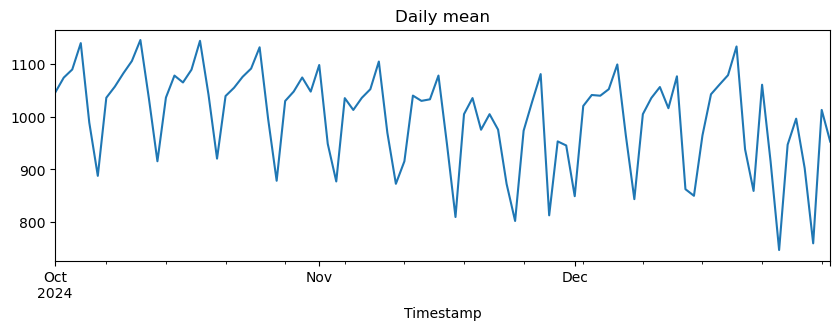

In [14]:
# daily average smooths noise so you see trend better
df['Total Flow'].resample('D').mean().plot(figsize=(10,3), title='Daily mean')


In [15]:
custom_holidays = [   ##Beacuse of the drop in december it is great to include holiday so our model lears the behaviour of the flow over that time or periods
    pd.to_datetime("2024-12-25"),
    pd.to_datetime("2024-12-31"),
    pd.to_datetime("2024-11-24"),
]
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)

In [16]:
df.groupby('IsHoliday')['Total Flow'].mean()

IsHoliday
0    1000.285461
1     293.691938
Name: Total Flow, dtype: float64

The average hourly Total Flow during non-holiday periods is approximately 1000, whereas it drops to about 294 during holidays.

<Axes: title={'center': 'Average Total Flow: Holidays vs Non-Holidays'}, xlabel='IsHoliday (0=No, 1=Yes)', ylabel='Average Flow'>

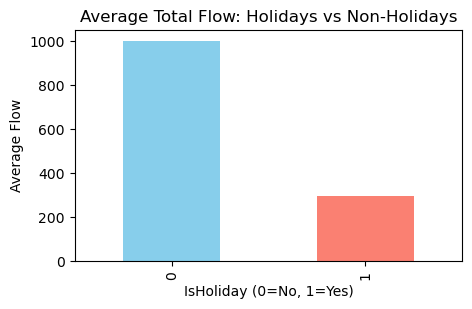

In [17]:
df.groupby('IsHoliday')['Total Flow'].mean().plot(
    kind='bar',
    color=['skyblue', 'salmon'],
    title='Average Total Flow: Holidays vs Non-Holidays',
    ylabel='Average Flow',
    xlabel='IsHoliday (0=No, 1=Yes)',
    figsize=(5,3)
)


In [18]:
# average value by hour of day
hour_profile = df.groupby('Hour')['Total Flow'].mean()
# average value by day of week
dow_profile  = df.groupby('Weekday')['Total Flow'].mean()

In [19]:
hour_profile

Hour
0      267.243212
1      195.949000
2      169.977573
3      205.348161
4      323.628788
5      623.516306
6     1009.907040
7     1289.505955
8     1316.575494
9     1300.455276
10    1360.537827
11    1429.879912
12    1499.280039
13    1533.003386
14    1614.258655
15    1669.942609
16    1657.396490
17    1583.645661
18    1330.434478
19    1037.403310
20     859.885616
21     733.225761
22     574.569621
23     401.395380
Name: Total Flow, dtype: float64

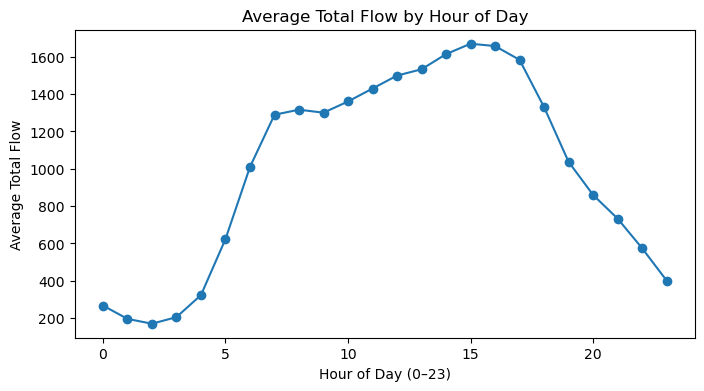

In [20]:
plt.figure(figsize=(8,4))
plt.plot(hour_profile.index, hour_profile.values, marker='o')
plt.title('Average Total Flow by Hour of Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Average Total Flow')
#plt.grid(True)
plt.show()


In [21]:
dow_profile

Weekday
0    1010.063746
1    1027.432555
2    1030.509575
3    1032.143192
4    1082.591190
5     953.854524
6     854.987151
Name: Total Flow, dtype: float64

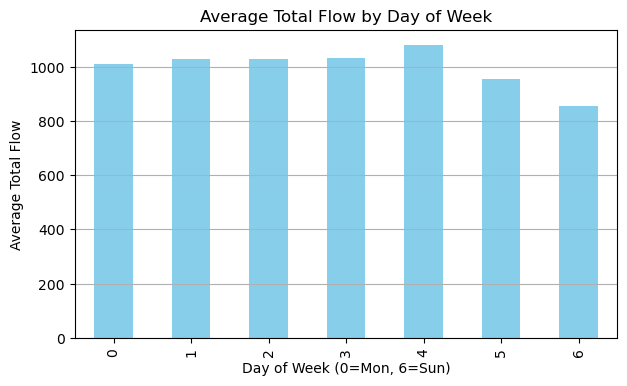

In [22]:
plt.figure(figsize=(7,4))
dow_profile.plot(kind='bar', color='skyblue')
plt.title('Average Total Flow by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Average Total Flow')
plt.grid(axis='y')
plt.show()

In [23]:
for lag in range(1, 169):  # Lags 1 to 168
    df[f'TotalFlow_lag_{lag}'] = df['Total Flow'].shift(lag)

In [24]:
df.dropna(inplace=True)

In [25]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

In [26]:
df = df.drop(columns=['Hour', 'Weekday'])

In [27]:
for window in [6, 12, 24, 168]:
    df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
    df[f'Flow_std_{window}'] = df['Total Flow'].rolling(window=window).std()
    df[f'Flow_min_{window}'] = df['Total Flow'].rolling(window=window).min()
    df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()
    df[f'Flow_cv_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']

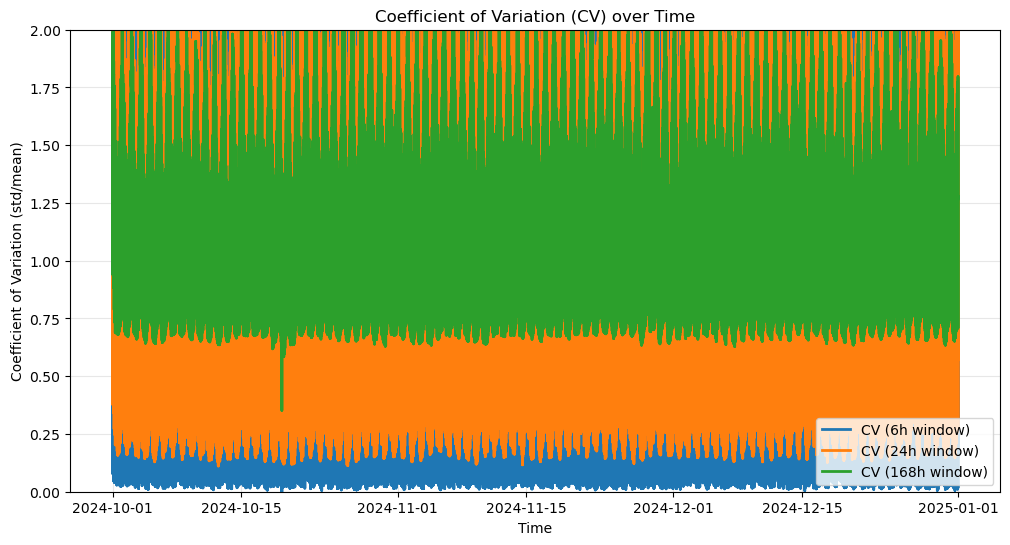

In [28]:
# Define windows to visualize
WINDOWS = [6, 12, 24, 168]
eps = 1e-6

# Compute rolling mean, std, and CV
for w in WINDOWS:
    m = df['Total Flow'].rolling(w).mean()
    s = df['Total Flow'].rolling(w).std()
    df[f'Flow_cv_{w}'] = s / m
    df.loc[m < 1.0, f'Flow_cv_{w}'] = np.nan  # avoid inflating CV when mean ≈ 0

# Plot CV over time
plt.figure(figsize=(12,6))

for w in [6, 24, 168]:  # show short, daily, and weekly
    plt.plot(df.index, df[f'Flow_cv_{w}'], label=f'CV ({w}h window)', linewidth=2)

plt.title('Coefficient of Variation (CV) over Time')
plt.xlabel('Time')
plt.ylabel('Coefficient of Variation (std/mean)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 2)  
plt.show()


Weekday
Monday       1.057653
Tuesday      1.058653
Wednesday    1.061878
Thursday     1.058368
Friday       1.036666
Saturday     1.040663
Sunday       1.062428
Name: Flow_cv_24, dtype: float64


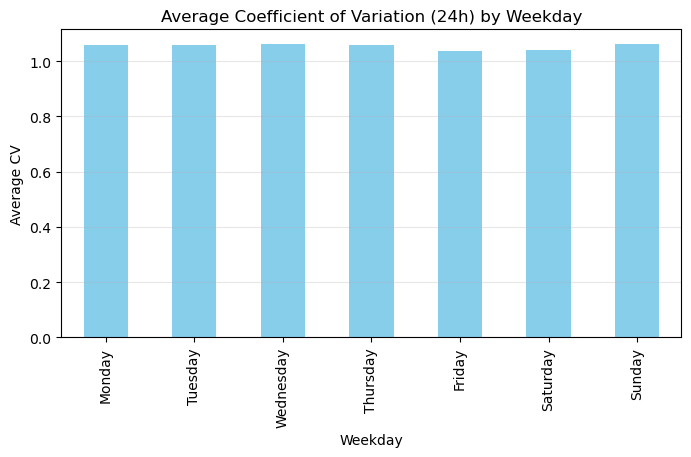

In [29]:
# Make sure 'Time' is your datetime index or column
df['Weekday'] = df.index.day_name()  # e.g., Monday, Tuesday...

# Choose the CV window you want to summarize (e.g., daily CV)
cv_col = 'Flow_cv_24'

weekday_cv = (
    df.groupby('Weekday')[cv_col]
      .mean()
      .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
)

print(weekday_cv)

# Plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
weekday_cv.plot(kind='bar', color='skyblue')
plt.title('Average Coefficient of Variation (24h) by Weekday')
plt.ylabel('Average CV')
plt.xlabel('Weekday')
plt.grid(axis='y', alpha=0.3)
plt.show()


| CV Value  | Interpretation     | Meaning for EV Flow                                                     |
| --------- | ------------------ | ----------------------------------------------------------------------- |
| 0.0 – 0.3 | Very stable        | Regular, predictable station                                            |
| 0.3 – 0.6 | Moderate variation | Normal daily cycles                                                     |
| 0.6 – 1.0 | High variation     | Irregular demand or events                                              |
| > 1.0     | Very unstable      | Flow fluctuates more than its mean


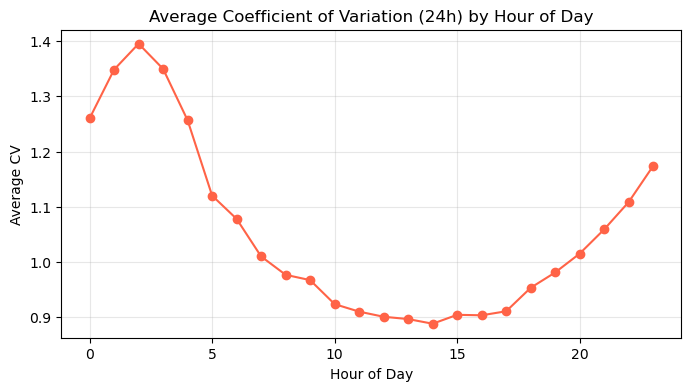

In [30]:
df['Hour'] = df.index.hour

hourly_cv = df.groupby('Hour')[cv_col].mean()

plt.figure(figsize=(8,4))
hourly_cv.plot(kind='line', marker='o', color='tomato')
plt.title('Average Coefficient of Variation (24h) by Hour of Day')
plt.ylabel('Average CV')
plt.xlabel('Hour of Day')
plt.grid(True, alpha=0.3)
plt.show()

In [31]:
station_cv = df.groupby('Station')[cv_col].mean().sort_values(ascending=False)

station_cv.head(10)  # top 10 most variable stations


Station
3054057    2.061905
3054056    2.033847
3054055    2.005207
3055025    1.984428
3423066    1.980683
3054053    1.962021
3054052    1.958693
3054054    1.909861
3055011    1.904669
3055015    1.902586
Name: Flow_cv_24, dtype: float64

CV values were highest during early-morning hours (00:00 – 05:00) when flow levels were minimal, indicating greater relative volatility. Flow became more stable during daylight hours (10:00 – 15:00) with CV values dropping below 1.0, suggesting consistent daytime demand. Variability increased again in the late evening, reflecting irregular activity outside standard commuting periods.

In [32]:
df.dropna(inplace=True)

In [33]:
df

,Station,Route,Direction of Travel,Total Flow,% Observed,Samples,Lane Type,Day,Month,IsHoliday,...,Flow_min_24,Flow_max_24,Flow_cv_24,Flow_mean_168,Flow_std_168,Flow_min_168,Flow_max_168,Flow_cv_168,Weekday,Hour
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00,315053,5,N,44.0,92,99,OR,1,10,0,...,0.0,1327.0,1.113435,362.797619,376.802170,0.0,1381.0,1.038602,Tuesday,0
2024-10-01 00:00:00,315054,5,N,1004.0,92,394,ML,1,10,0,...,0.0,1327.0,1.029867,364.148810,378.698601,0.0,1381.0,1.039956,Tuesday,0
2024-10-01 00:00:00,315055,5,N,82.0,92,99,FR,1,10,0,...,0.0,1327.0,1.024410,364.559524,378.352744,0.0,1381.0,1.037835,Tuesday,0
2024-10-01 00:00:00,315060,5,S,32.0,92,141,ML,1,10,0,...,0.0,1327.0,1.098153,364.738095,378.187645,0.0,1381.0,1.036875,Tuesday,0
2024-10-01 00:00:00,315061,5,S,0.0,0,99,HV,1,10,0,...,0.0,1327.0,1.101467,356.529762,370.937571,0.0,1381.0,1.040411,Tuesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,S,68.0,96,118,ML,31,12,0,...,0.0,506.0,1.513366,223.714286,287.966027,0.0,1422.0,1.287204,Tuesday,23
2024-12-31 23:00:00,3900021,50,E,803.0,67,292,ML,31,12,0,...,0.0,803.0,1.810561,222.434524,284.876139,0.0,1422.0,1.280719,Tuesday,23
2024-12-31 23:00:00,3900022,50,E,509.0,0,0,HV,31,12,0,...,0.0,803.0,1.651651,219.404762,279.010661,0.0,1422.0,1.271671,Tuesday,23


## LSTM MODEL
For each station, we build a LightGBM-selected LSTM model that uses lagged flows from other stations and contextual features to predict its own flow at multiple horizons, then average results across all stations.

In [34]:
summary = pd.DataFrame({
    'dtype': df.dtypes,
    'num_unique': df.nunique(),
    'example_values': df.apply(lambda x: list(x.unique()[:10]))  # show first 5 unique values
})


In [35]:
summary.sort_values('num_unique').head(50)

,dtype,num_unique,example_values
IsHoliday,int64,2,"[0, 1]"
Month,int64,3,"[10, 11, 12]"
Direction of Travel,object,4,"[N, S, E, W]"
Lane Type,object,5,"[OR, ML, FR, HV, FF]"
Weekday_cos,float64,6,"[0.6234898018587335, -0.22252093395631437, -0...."
Weekday_sin,float64,7,"[0.7818314824680299, 0.9749279121818238, 0.433..."
Weekday,object,7,"[Tuesday, Wednesday, Thursday, Friday, Saturda..."
Hour_cos,float64,22,"[1.0, 0.9659258262890684, 0.8660254037844386, ..."
Route,int64,23,"[5, 80, 99, 51, 50, 113, 160, 89, 65, 70]"
Hour_sin,float64,23,"[0.0, 0.2588190451025208, 0.4999999999999999, ..."


In [36]:
df = pd.get_dummies(df, columns=['Lane Type'], prefix='Lane', drop_first=False)

In [37]:
df = pd.get_dummies(df, columns=['Direction of Travel'], prefix='Dir', drop_first=False)

In [38]:
df

,Station,Route,Total Flow,% Observed,Samples,Day,Month,IsHoliday,TotalFlow_lag_1,TotalFlow_lag_2,...,Hour,Lane_FF,Lane_FR,Lane_HV,Lane_ML,Lane_OR,Dir_E,Dir_N,Dir_S,Dir_W
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00,315053,5,44.0,92,99,1,10,0,35.0,836.0,...,0,0,0,0,0,1,0,1,0,0
2024-10-01 00:00:00,315054,5,1004.0,92,394,1,10,0,44.0,35.0,...,0,0,0,0,1,0,0,1,0,0
2024-10-01 00:00:00,315055,5,82.0,92,99,1,10,0,1004.0,44.0,...,0,0,1,0,0,0,0,1,0,0
2024-10-01 00:00:00,315060,5,32.0,92,141,1,10,0,82.0,1004.0,...,0,0,0,0,1,0,0,0,1,0
2024-10-01 00:00:00,315061,5,0.0,0,99,1,10,0,32.0,82.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,68.0,96,118,31,12,0,184.0,5.0,...,23,0,0,0,1,0,0,0,1,0
2024-12-31 23:00:00,3900021,50,803.0,67,292,31,12,0,68.0,184.0,...,23,0,0,0,1,0,1,0,0,0
2024-12-31 23:00:00,3900022,50,509.0,0,0,31,12,0,803.0,68.0,...,23,0,0,1,0,0,1,0,0,0


In [39]:
# make a safe copy (optional)
df = df.copy()

# create readable station codes like S315053
df['StationName'] = 'S' + df['Station'].astype(str)

# quick check
df[['Station','StationName']].head()


,Station,StationName
Timestamp,,
2024-10-01,315053,S315053
2024-10-01,315054,S315054
2024-10-01,315055,S315055
2024-10-01,315060,S315060
2024-10-01,315061,S315061


In [40]:
# convert all True/False columns to 0/1 (int)
df = df.astype({c: int for c in df.columns if df[c].dtype == 'bool'})

In [41]:
df

,Station,Route,Total Flow,% Observed,Samples,Day,Month,IsHoliday,TotalFlow_lag_1,TotalFlow_lag_2,...,Lane_FF,Lane_FR,Lane_HV,Lane_ML,Lane_OR,Dir_E,Dir_N,Dir_S,Dir_W,StationName
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-01 00:00:00,315053,5,44.0,92,99,1,10,0,35.0,836.0,...,0,0,0,0,1,0,1,0,0,S315053
2024-10-01 00:00:00,315054,5,1004.0,92,394,1,10,0,44.0,35.0,...,0,0,0,1,0,0,1,0,0,S315054
2024-10-01 00:00:00,315055,5,82.0,92,99,1,10,0,1004.0,44.0,...,0,1,0,0,0,0,1,0,0,S315055
2024-10-01 00:00:00,315060,5,32.0,92,141,1,10,0,82.0,1004.0,...,0,0,0,1,0,0,0,1,0,S315060
2024-10-01 00:00:00,315061,5,0.0,0,99,1,10,0,32.0,82.0,...,0,0,1,0,0,0,0,1,0,S315061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 23:00:00,3423094,99,68.0,96,118,31,12,0,184.0,5.0,...,0,0,0,1,0,0,0,1,0,S3423094
2024-12-31 23:00:00,3900021,50,803.0,67,292,31,12,0,68.0,184.0,...,0,0,0,1,0,1,0,0,0,S3900021
2024-12-31 23:00:00,3900022,50,509.0,0,0,31,12,0,803.0,68.0,...,0,0,1,0,0,1,0,0,0,S3900022


In [42]:
FLOW_COL = 'Total Flow'
LAGS = range(1, 169)  # 1..168 hours

# df already has Timestamp as index in your screenshot
flow_wide = df.pivot_table(index=df.index, columns='StationName', values=FLOW_COL, aggfunc='mean')
flow_wide = flow_wide.reindex(sorted(flow_wide.columns), axis=1)

# all lags for all stations
flow_lags_all = pd.concat(
    [flow_wide.shift(L).add_suffix(f'_lag_{L}') for L in LAGS],
    axis=1
)

flow_wide.shape, flow_lags_all.shape


((2208, 1806), (2208, 303408))

In [43]:
target = df['StationName'].iloc[0]  # or pick any target like 'S315053'

# lags of OTHER stations
X_cross = flow_lags_all.drop(
    columns=[c for c in flow_lags_all.columns if c.startswith(f'{target}_lag_')],
    errors='ignore'
)

# ALL non-flow, non-lag features for the target station
X_target_feats = df[df['StationName'] == target].drop(
    columns=['Station', 'StationName', FLOW_COL] + 
            [c for c in df.columns if c.startswith('TotalFlow_lag_')],
    errors='ignore'
)

# combine and align on time
X = pd.concat([X_cross, X_target_feats], axis=1).sort_index()

# multi-horizon Y
HORIZONS = [12, 24, 48, 72]
Y = pd.concat(
    {h: df.loc[df['StationName'] == target, FLOW_COL].shift(-h) for h in HORIZONS},
    axis=1
)
Y.columns = [f'y_{h}h' for h in HORIZONS]

# ---------------- burn-in & cleaning ----------------
burn_in = max(LAGS)  # e.g., 168
# align indexes
common_idx = X.index.intersection(Y.index)
X = X.loc[common_idx]
Y = Y.loc[common_idx]

# drop first 'burn_in' rows (lags not fully available)
X = X.iloc[burn_in:]
Y = Y.iloc[burn_in:]

# drop rows with NaN in Y only (due to forward shifts at the end)
mask = ~Y.isna().any(axis=1)
X = X.loc[mask]
Y = Y.loc[mask]

# impute residual NaNs in X (rare after the steps above)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

X.shape, Y.shape


((1967, 303281), (1967, 4))

In [51]:
# ========================= CLEAN + SKLEARN GB → top-K → LSTM (single station) =========================
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import tensorflow as tf
from tensorflow import keras

# --------- CONFIG
LOOKBACK   = 24
HORIZONS   = [12, 24, 48, 72]
TOP_K      = 120
EPOCHS     = 25
BATCH_SIZE = 128
LR         = 1e-3
PATIENCE   = 5

# --------- helpers
def time_split_index(idx, train_ratio=0.7, val_ratio=0.1):
    n = len(idx); n_tr = int(n*train_ratio); n_va = int(n*val_ratio)
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

def make_windows(X2d, lookback):
    T, F = X2d.shape
    N = T - lookback + 1
    out = np.empty((N, lookback, F), dtype=np.float32)
    for i in range(N): out[i] = X2d[i:i+lookback]
    return out

def align_windows_with_targets(X_df, Y_df, lookback):
    X_df = X_df.sort_index(); Y_df = Y_df.sort_index()
    common = X_df.index.intersection(Y_df.index)
    X2 = X_df.loc[common].to_numpy(dtype=float)
    Y2 = Y_df.loc[common].to_numpy(dtype=float)
    X3 = make_windows(X2, lookback)
    Y_al = Y2[lookback-1:]
    idx_al = common[lookback-1:]
    return X3, Y_al, idx_al

def build_lstm(n_features, n_outputs):
    inp = keras.Input(shape=(LOOKBACK, n_features))
    x = keras.layers.Masking(mask_value=0.0)(inp)
    x = keras.layers.LSTM(64, return_sequences=False)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    out = keras.layers.Dense(n_outputs)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss='mae', metrics=['mae'])
    return m

def metrics_by_horizon(y_true, y_pred, horizons):
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], y_pred[:, j])
        rmse = mean_squared_error(y_true[:, j], y_pred[:, j], squared=False)
        res[f"MAE_{h}h"] = mae; res[f"RMSE_{h}h"] = rmse
        maes.append(mae); rmses.append(rmse)
    res["MAE_mean"]  = float(np.mean(maes)); res["RMSE_mean"] = float(np.mean(rmses))
    return res

# --------- CLEAN FEATURES (handles 'Tuesday' etc.)
def clean_features(X):
    X = X.copy()
    # booleans -> ints
    bcols = X.select_dtypes(include=['bool']).columns
    if len(bcols): X[bcols] = X[bcols].astype(int)
    # object -> numeric where possible, else drop
    ocols = X.select_dtypes(include=['object']).columns
    for c in ocols: X[c] = pd.to_numeric(X[c], errors='coerce')
    non_num = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
    if non_num:
        print("Dropping non-numeric columns:", non_num)
        X = X.drop(columns=non_num)
    # clean infinities/NaN
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X.astype(float)

# --------- 1) CLEAN DATA
X = clean_features(X)
Y = Y.replace([np.inf, -np.inf], np.nan).dropna().astype(float)
common_idx = X.index.intersection(Y.index)
X = X.loc[common_idx]; Y = Y.loc[common_idx]

# --------- 2) time split
tr_idx, va_idx, te_idx = time_split_index(X.index, train_ratio=0.7, val_ratio=0.1)
X_tr, X_va, X_te = X.loc[tr_idx], X.loc[va_idx], X.loc[te_idx]
Y_tr, Y_va, Y_te = Y.loc[tr_idx], Y.loc[va_idx], Y.loc[te_idx]

# --------- 3) Feature selection with GradientBoostingRegressor (12h proxy)
print("Running Gradient Boosting for feature importance ...")
gbr = GradientBoostingRegressor(n_estimators=600, learning_rate=0.05, max_depth=5, random_state=42)
gbr.fit(X_tr, Y_tr['y_12h'])
imp = pd.Series(gbr.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
keep_cols = imp.head(TOP_K).index.tolist()
print(f"Kept top-{TOP_K} features.")

# --------- 4) Scale & window
scaler = StandardScaler()
Xtr2 = scaler.fit_transform(X_tr[keep_cols])
Xva2 = scaler.transform(X_va[keep_cols])
Xte2 = scaler.transform(X_te[keep_cols])

Xtr3, Ytr2, _ = align_windows_with_targets(pd.DataFrame(Xtr2, index=X_tr.index, columns=keep_cols), Y_tr, LOOKBACK)
Xva3, Yva2, _ = align_windows_with_targets(pd.DataFrame(Xva2, index=X_va.index, columns=keep_cols), Y_va, LOOKBACK)
Xte3, Yte2, _ = align_windows_with_targets(pd.DataFrame(Xte2, index=X_te.index, columns=keep_cols), Y_te, LOOKBACK)

print("Shapes:",
      "\n  Xtr3:", Xtr3.shape, "Ytr2:", Ytr2.shape,
      "\n  Xva3:", Xva3.shape, "Yva2:", Yva2.shape,
      "\n  Xte3:", Xte3.shape, "Yte2:", Yte2.shape)

# --------- 5) LSTM training
tf.keras.backend.clear_session()
model = build_lstm(n_features=Xtr3.shape[-1], n_outputs=len(HORIZONS))
cbs = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
]
history = model.fit(Xtr3, Ytr2, validation_data=(Xva3, Yva2),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=cbs)

# --------- 6) Evaluate
Yhat_te = model.predict(Xte3, verbose=0)
results = metrics_by_horizon(Yte2, Yhat_te, HORIZONS)
print("\nTest metrics:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# --------- 7) Save artifacts (optional)
pd.DataFrame({'feature': imp.index, 'importance': imp.values}).to_csv("gb_importance.csv", index=False)
pd.Series(keep_cols, name="kept_features").to_csv("kept_features.csv", index=False)
model.save("lstm_per_station_cleaned.h5")


Running Gradient Boosting for feature importance ...
Kept top-120 features.
Shapes: 
  Xtr3: (1353, 24, 120) Ytr2: (1353, 4) 
  Xva3: (173, 24, 120) Yva2: (173, 4) 
  Xte3: (372, 24, 120) Yte2: (372, 4)


2025-10-11 16:45:29.935413: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:5e:00.0, compute capability: 7.0
2025-10-11 16:45:29.936576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14784 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


Epoch 1/25


2025-10-11 16:45:34.167979: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_40/output/_23'
2025-10-11 16:45:34.439755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-10-11 16:45:34.571506: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f094808ab90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-11 16:

11/11 [==============================] - 12s 128ms/step - loss: 211.6065 - mae: 211.6065 - val_loss: 214.1326 - val_mae: 214.1326 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - 0s 13ms/step - loss: 210.4077 - mae: 210.4077 - val_loss: 212.6218 - val_mae: 212.6218 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - 0s 15ms/step - loss: 208.6242 - mae: 208.6242 - val_loss: 210.1237 - val_mae: 210.1237 - lr: 0.0010
Epoch 4/25
11/11 [==============================] - 0s 13ms/step - loss: 205.4270 - mae: 205.4270 - val_loss: 205.0807 - val_mae: 205.0807 - lr: 0.0010
Epoch 5/25
11/11 [==============================] - 0s 14ms/step - loss: 199.4483 - mae: 199.4483 - val_loss: 197.4776 - val_mae: 197.4776 - lr: 0.0010
Epoch 6/25
11/11 [==============================] - 0s 13ms/step - loss: 192.1098 - mae: 192.1098 - val_loss: 189.4177 - val_mae: 189.4177 - lr: 0.0010
Epoch 7/25
11/11 [==============================] - 0s 13ms/step - loss: 184.1064 - mae: 184.1064

Running Gradient Boosting for feature importance ...
Kept top-120 features.
Shapes: 
  Xtr3: (1353, 24, 120) Ytr2: (1353, 4) 
  Xva3: (173, 24, 120) Yva2: (173, 4) 
  Xte3: (372, 24, 120) Yte2: (372, 4)


2025-10-14 06:17:03.386793: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-10-14 06:17:03.387193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14728 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:5e:00.0, compute capability: 7.0
2025-10-14 06:17:03.387813: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-10-14 06:17:03.387842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14728 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


Epoch 1/25


2025-10-14 06:17:05.734911: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-10-14 06:17:10.811154: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4989946620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-14 06:17:10.811217: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2025-10-14 06:17:10.811232: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-PCIE-16GB, Compute Capability 7.0
2025-10-14 06:17:10.820818: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-14 06:17:13.609688: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - 17s 59ms/step - loss: 210.0976 - mae: 210.0849 - val_loss: 209.4288 - val_mae: 209.4161 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - 0s 10ms/step - loss: 202.4714 - mae: 202.4585 - val_loss: 198.7004 - val_mae: 198.6874 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - 0s 10ms/step - loss: 190.8520 - mae: 190.8387 - val_loss: 184.5775 - val_mae: 184.5639 - lr: 0.0010
Epoch 4/25
11/11 [==============================] - 0s 10ms/step - loss: 176.9049 - mae: 176.8909 - val_loss: 168.2063 - val_mae: 168.1918 - lr: 0.0010
Epoch 5/25
11/11 [==============================] - 0s 11ms/step - loss: 160.9404 - mae: 160.9254 - val_loss: 151.4746 - val_mae: 151.4589 - lr: 0.0010
Epoch 6/25
11/11 [==============================] - 0s 10ms/step - loss: 145.6216 - mae: 145.6052 - val_loss: 136.2987 - val_mae: 136.2815 - lr: 0.0010
Epoch 7/25
11/11 [==============================] - 0s 10ms/step - loss: 132.6124 - mae: 132.5945 

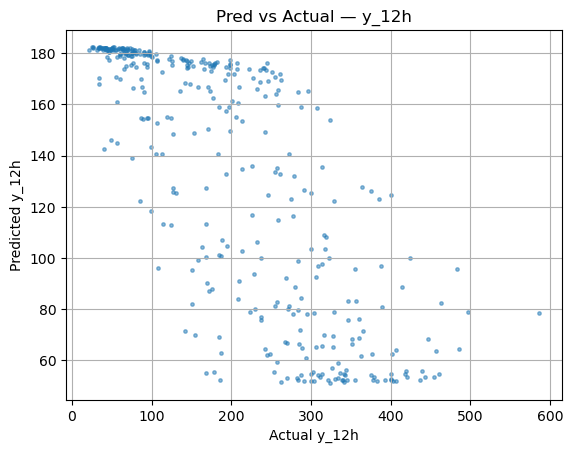

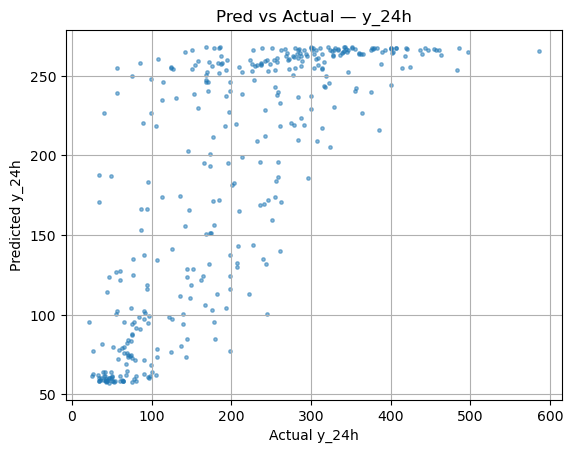

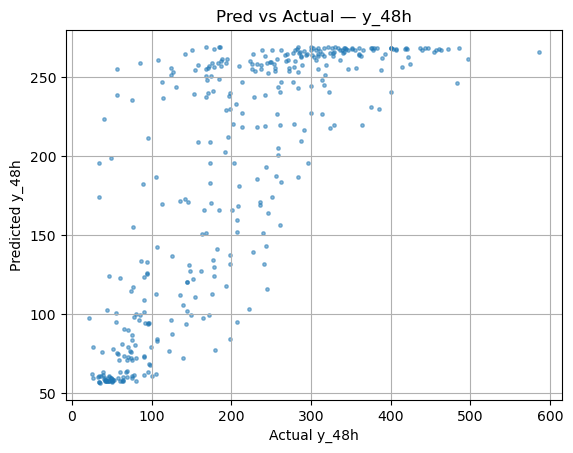

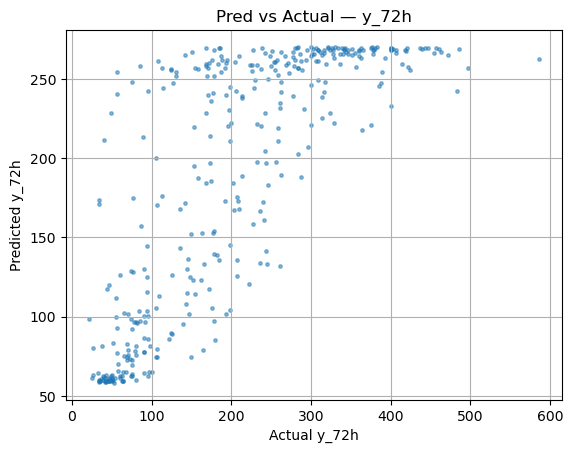

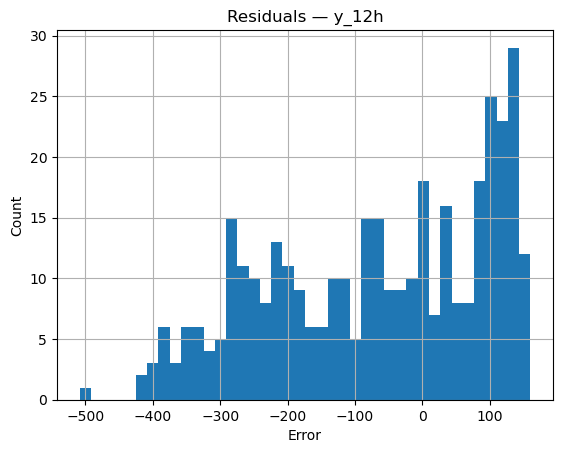

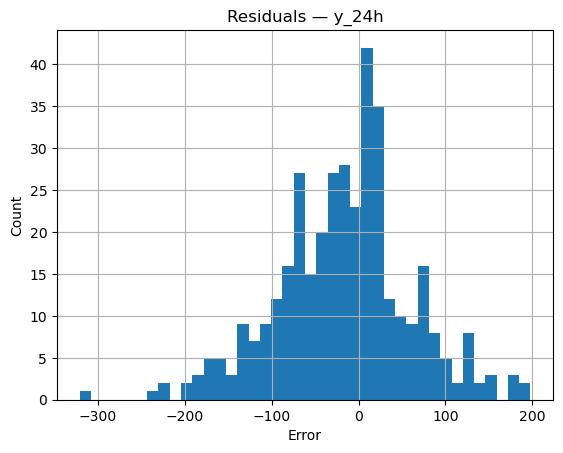

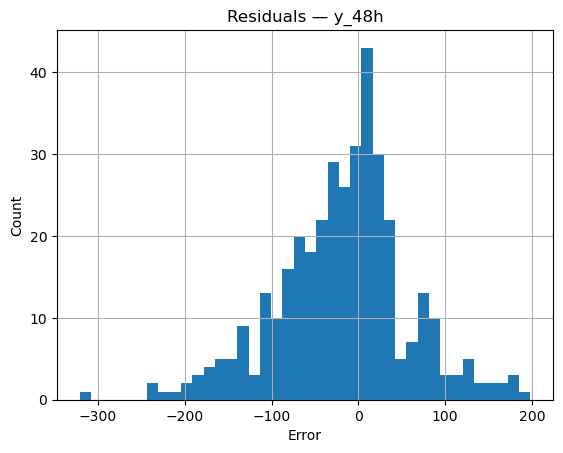

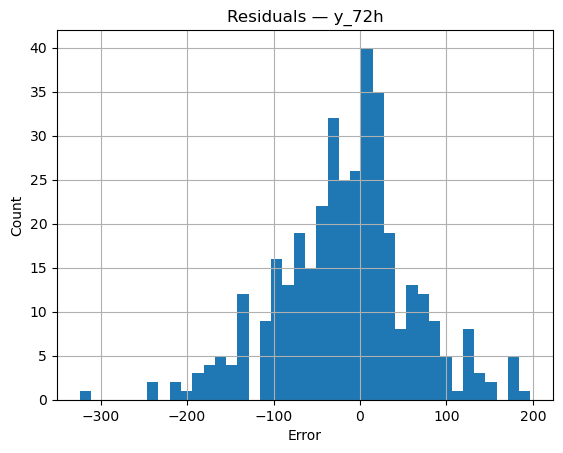

MAE by decile for 12h: [(1, 139.29118909333883), (2, 115.53777433696546), (3, 87.49750819959138), (4, 37.43319867108319), (5, 37.62316864415219), (6, 69.58255186080933), (7, 128.32027826811137), (8, 201.68957220541463), (9, 259.9010966532939), (10, 347.5810183474892)]
MAE by decile for 24h: [(1, 38.588213896140076), (2, 29.11128469613882), (3, 43.46708517074585), (4, 66.51105720118473), (5, 59.47081013729698), (6, 45.852974339535365), (7, 38.671404587595084), (8, 41.64359881426837), (9, 77.1701557056324), (10, 156.8309286017167)]
MAE by decile for 48h: [(1, 37.88441025583368), (2, 26.36030528419896), (3, 32.229135513305664), (4, 60.63041948017321), (5, 59.849271001042545), (6, 45.03081058811497), (7, 35.79257684004934), (8, 38.77974901701275), (9, 75.42889115617082), (10, 159.69597103721216)]
MAE by decile for 72h: [(1, 39.75990706995914), (2, 29.493891947978252), (3, 34.55565323700776), (4, 61.81848726774517), (5, 62.38962755705181), (6, 43.177603025694154), (7, 36.37256642934438), (8

29473

In [44]:
# ========================= FINAL: GB → top-K → Scale → Window → Conv1D+LSTM (single station) =========================
import os, gc, warnings, logging
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

warnings.filterwarnings("ignore", category=RuntimeWarning)
os.environ.setdefault("TF_FORCE_GPU_ALLOW_GROWTH", "true")
tf.get_logger().setLevel(logging.ERROR)

# ---------------- CONFIG ----------------
LOOKBACK    = 24           # try 168 later for weekly context
HORIZONS    = [12, 24, 48, 72]
ORDERED_COLS = [f"y_{h}h" for h in HORIZONS]
TOP_K       = 120
EPOCHS      = 25
BATCH_SIZE  = 128
LR          = 1e-3
PATIENCE    = 5
REF_COL     = "Total Flow" # used for LV baseline; set to None to skip or rename to match your X
PLOT_DIAGNOSTICS = True    # set False to skip plots

# ------------- helpers -------------
def time_split_index(idx, train_ratio=0.7, val_ratio=0.1):
    n = len(idx); n_tr = int(n*train_ratio); n_va = int(n*val_ratio)
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

def make_windows(X2d, lookback):
    T, F = X2d.shape
    N = T - lookback + 1
    out = np.empty((N, lookback, F), dtype=np.float32)
    for i in range(N):
        out[i] = X2d[i:i+lookback]
    return out

def align_windows_with_targets(X_df, Y_df, lookback):
    X_df = X_df.sort_index(); Y_df = Y_df.sort_index()
    common = X_df.index.intersection(Y_df.index)
    X2 = X_df.loc[common].to_numpy(dtype=float)
    Y2 = Y_df.loc[common].to_numpy(dtype=float)
    X3 = make_windows(X2, lookback)
    Y_al = Y2[lookback-1:]
    idx_al = common[lookback-1:]
    return X3, Y_al, idx_al

def build_model(n_features, n_outputs):
    inp = keras.Input(shape=(LOOKBACK, n_features))
    x = keras.layers.Conv1D(32, 3, padding="causal", activation="relu")(inp)
    x = keras.layers.LSTM(128)(x)
    x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.Dropout(0.3)(x)
    out = keras.layers.Dense(n_outputs)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss='mae', metrics=['mae'])
    return m

def metrics_by_horizon(y_true, y_pred, horizons):
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], y_pred[:, j])
        rmse = mean_squared_error(y_true[:, j], y_pred[:, j], squared=False)
        res[f"MAE_{h}h"] = float(mae); res[f"RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["MAE_mean"]  = float(np.mean(maes)); res["RMSE_mean"] = float(np.mean(rmses))
    return res

def lv_baseline_metrics(y_true_df, ref_series, horizons):
    """Last-value (LV) baseline: predict all horizons as the most recent observed value at window end."""
    y_true = y_true_df.to_numpy()
    # Use the aligned ref_series values (same index as y_true_df)
    ref_vals = ref_series.loc[y_true_df.index].values.reshape(-1, 1)
    preds_lv = np.repeat(ref_vals, repeats=len(horizons), axis=1)
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], preds_lv[:, j])
        rmse = mean_squared_error(y_true[:, j], preds_lv[:, j], squared=False)
        res[f"LV_MAE_{h}h"] = float(mae); res[f"LV_RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["LV_MAE_mean"]  = float(np.mean(maes)); res["LV_RMSE_mean"] = float(np.mean(rmses))
    return res

def clean_features(X):
    X = X.copy()
    # booleans -> ints
    bcols = X.select_dtypes(include=['bool']).columns
    if len(bcols): X[bcols] = X[bcols].astype(int)
    # object -> numeric where possible, else drop
    ocols = X.select_dtypes(include=['object']).columns
    for c in ocols: X[c] = pd.to_numeric(X[c], errors='coerce')
    non_num = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
    if non_num:
        print("Dropping non-numeric columns:", non_num)
        X = X.drop(columns=non_num)
    # clean infinities/NaN
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X.astype(float)

def mae_by_quantile(y, yhat, q=10):
    qs = np.linspace(0, 1, q+1)
    cuts = np.quantile(y, qs)
    out = []
    for i in range(q):
        mask = (y >= cuts[i]) & (y <= cuts[i+1] if i < q-1 else y <= cuts[i+1])
        if mask.sum():
            out.append((i+1, float(np.mean(np.abs(yhat[mask]-y[mask])))))
    return out

# ============================= MAIN (single-station) =============================
# Expect X, Y already defined (DataFrames with DateTime index). Y must contain y_12h,y_24h,y_48h,y_72h.
assert isinstance(X, pd.DataFrame) and isinstance(Y, pd.DataFrame), "Please provide X and Y as pandas DataFrames."
X = clean_features(X)

# Strict target order
for c in ORDERED_COLS:
    assert c in Y.columns, f"Missing target column {c} in Y"
Y = Y[ORDERED_COLS].replace([np.inf, -np.inf], np.nan).dropna().astype(float)

# Align X and Y on common timestamps
common_idx = X.index.intersection(Y.index)
X = X.loc[common_idx]
Y = Y.loc[common_idx]

# Split by time
tr_idx, va_idx, te_idx = time_split_index(X.index, train_ratio=0.7, val_ratio=0.1)
X_tr, X_va, X_te = X.loc[tr_idx], X.loc[va_idx], X.loc[te_idx]
Y_tr, Y_va, Y_te = Y.loc[tr_idx], Y.loc[va_idx], Y.loc[te_idx]

# Gradient Boosting feature selection using 12h as proxy
print("Running Gradient Boosting for feature importance ...")
gbr = GradientBoostingRegressor(n_estimators=600, learning_rate=0.05, max_depth=5, random_state=42)
gbr.fit(X_tr, Y_tr['y_12h'])
imp = pd.Series(gbr.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
keep_cols = imp.head(TOP_K).index.tolist()
print(f"Kept top-{TOP_K} features.")

# Scale on train only
scaler = StandardScaler()
Xtr2 = scaler.fit_transform(X_tr[keep_cols])
Xva2 = scaler.transform(X_va[keep_cols])
Xte2 = scaler.transform(X_te[keep_cols])

# Window + align
Xtr3, Ytr2, tr_al_idx = align_windows_with_targets(pd.DataFrame(Xtr2, index=X_tr.index, columns=keep_cols), Y_tr, LOOKBACK)
Xva3, Yva2, va_al_idx = align_windows_with_targets(pd.DataFrame(Xva2, index=X_va.index, columns=keep_cols), Y_va, LOOKBACK)
Xte3, Yte2, te_al_idx = align_windows_with_targets(pd.DataFrame(Xte2, index=X_te.index, columns=keep_cols), Y_te, LOOKBACK)

print("Shapes:",
      "\n  Xtr3:", Xtr3.shape, "Ytr2:", Ytr2.shape,
      "\n  Xva3:", Xva3.shape, "Yva2:", Yva2.shape,
      "\n  Xte3:", Xte3.shape, "Yte2:", Yte2.shape)

# Train
tf.keras.backend.clear_session()
model = build_model(n_features=Xtr3.shape[-1], n_outputs=len(HORIZONS))
cbs = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
]
history = model.fit(
    Xtr3, Ytr2,
    validation_data=(Xva3, Yva2),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=cbs
)

# Evaluate
Yhat_te = model.predict(Xte3, verbose=0)
results = metrics_by_horizon(Yte2, Yhat_te, HORIZONS)

# Build aligned DataFrames for export/plots
Yte_df   = pd.DataFrame(Yte2, index=te_al_idx, columns=ORDERED_COLS)
Yhat_df  = pd.DataFrame(Yhat_te, index=te_al_idx, columns=ORDERED_COLS)

# Baseline (Last-Value) if reference column exists
baseline_res = {}
if REF_COL is not None and REF_COL in X.columns:
    # Use raw (unscaled) REF_COL aligned to the end of each window
    ref_series = X[REF_COL]
    baseline_res = lv_baseline_metrics(Yte_df, ref_series, HORIZONS)
    print("\nBaseline (LV) metrics:")
    for k, v in baseline_res.items():
        print(f"{k}: {v:.4f}")
else:
    print("\n[Info] REF_COL not found in X or disabled; skipping LV baseline.")

print("\nLSTM Test metrics:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# --------- Diagnostics (optional) ---------
if PLOT_DIAGNOSTICS:
    for col in ORDERED_COLS:
        plt.figure()
        plt.scatter(Yte_df[col].values, Yhat_df[col].values, s=6, alpha=0.5)
        plt.xlabel(f"Actual {col}"); plt.ylabel(f"Predicted {col}")
        plt.title(f"Pred vs Actual — {col}"); plt.grid(True); plt.show()

    for col in ORDERED_COLS:
        res = (Yhat_df[col] - Yte_df[col]).values
        plt.figure()
        plt.hist(res, bins=40)
        plt.title(f"Residuals — {col}")
        plt.xlabel("Error"); plt.ylabel("Count"); plt.grid(True); plt.show()

    for h in HORIZONS:
        y = Yte_df[f'y_{h}h'].values; yhat = Yhat_df[f'y_{h}h'].values
        print(f"MAE by decile for {h}h:", mae_by_quantile(y, yhat))

# --------- Exports ---------
# Metrics table (model + baseline if available)
final_metrics = {**{k: float(v) for k, v in results.items()}, **{k: float(v) for k, v in baseline_res.items()}}
metrics_df = pd.DataFrame(list(final_metrics.items()), columns=["metric", "value"])
metrics_df.to_csv("per_station_metrics.csv", index=False)

# Predictions vs actuals
out = pd.concat([Yte_df.add_prefix("ytrue_"), Yhat_df.add_prefix("ypred_")], axis=1)
out.to_csv("per_station_preds_test.csv")

# Feature importance + kept features
pd.DataFrame({'feature': imp.index, 'importance': imp.values}).to_csv("gb_importance.csv", index=False)
pd.Series(keep_cols, name="kept_features").to_csv("kept_features.csv", index=False)

# Save model
model.save("lstm_per_station_cleaned.h5")

print("\nSaved: per_station_metrics.csv, per_station_preds_test.csv, gb_importance.csv, kept_features.csv, lstm_per_station_cleaned.h5")
gc.collect()


In [ ]:
# ========================= PER-STATION: Cross-lags → Top-K → Scale → Window → Conv1D+LSTM =========================
# - For each station:
#   X = lags of all OTHER stations + target station's non-flow features (no self lags)
#   Y = multi-horizon targets (12h, 24h, 48h, 72h) of the target station
# - Feature selection with Gradient Boosting (on y_12h)
# - Train Conv1D+LSTM
# - Metrics per horizon and averaged; optional LV baseline using raw target series
# - Saves per-station outputs under ./per_station/<station> and a combined summary CSV

import os, gc, warnings, logging
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# ---------------- CONFIG ----------------
FLOW_COL       = "Total Flow"    # column in df with flow values
STATION_COL    = "StationName"   # column in df that identifies station
LAGS           = range(1, 169)   # 1..168 hours of lags
LOOKBACK       = 24              # try 168 for weekly context
HORIZONS       = [12, 24, 48, 72]
ORDERED_COLS   = [f"y_{h}h" for h in HORIZONS]
TOP_K          = 120
EPOCHS         = 25
BATCH_SIZE     = 128
LR             = 1e-3
PATIENCE       = 5
PLOT_DIAGNOSTICS = False         # set True to see plots per horizon

# TensorFlow hygiene
warnings.filterwarnings("ignore", category=RuntimeWarning)
os.environ.setdefault("TF_FORCE_GPU_ALLOW_GROWTH", "true")
tf.get_logger().setLevel(logging.ERROR)
np.random.seed(42)
tf.random.set_seed(42)

# ---------------- helpers ----------------
def time_split_index(idx, train_ratio=0.7, val_ratio=0.1):
    n = len(idx); n_tr = int(n*train_ratio); n_va = int(n*val_ratio)
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

def make_windows(X2d, lookback):
    T, F = X2d.shape
    N = T - lookback + 1
    out = np.empty((N, lookback, F), dtype=np.float32)
    for i in range(N):
        out[i] = X2d[i:i+lookback]
    return out

def align_windows_with_targets(X_df, Y_df, lookback):
    X_df = X_df.sort_index(); Y_df = Y_df.sort_index()
    common = X_df.index.intersection(Y_df.index)
    X2 = X_df.loc[common].to_numpy(dtype=float)
    Y2 = Y_df.loc[common].to_numpy(dtype=float)
    X3 = make_windows(X2, lookback)
    Y_al = Y2[lookback-1:]
    idx_al = common[lookback-1:]
    return X3, Y_al, idx_al

def build_model(n_features, n_outputs):
    inp = keras.Input(shape=(LOOKBACK, n_features))
    x = keras.layers.Conv1D(32, 3, padding="causal", activation="relu")(inp)
    x = keras.layers.LSTM(128)(x)
    x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.Dropout(0.3)(x)
    out = keras.layers.Dense(n_outputs)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss='mae', metrics=['mae'])
    return m

def metrics_by_horizon(y_true, y_pred, horizons):
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], y_pred[:, j])
        rmse = mean_squared_error(y_true[:, j], y_pred[:, j], squared=False)
        res[f"MAE_{h}h"] = float(mae); res[f"RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["MAE_mean"]  = float(np.mean(maes)); res["RMSE_mean"] = float(np.mean(rmses))
    return res

def lv_baseline_metrics(y_true_df, ref_series, horizons):
    """Last-value baseline at window end: predict all horizons as the most recent observed ref value."""
    y_true = y_true_df.to_numpy()
    ref_vals = ref_series.loc[y_true_df.index].values.reshape(-1, 1)
    preds_lv = np.repeat(ref_vals, repeats=len(horizons), axis=1)
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], preds_lv[:, j])
        rmse = mean_squared_error(y_true[:, j], preds_lv[:, j], squared=False)
        res[f"LV_MAE_{h}h"] = float(mae); res[f"LV_RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["LV_MAE_mean"]  = float(np.mean(maes)); res["LV_RMSE_mean"] = float(np.mean(rmses))
    return res

def clean_features(X):
    X = X.copy()
    bcols = X.select_dtypes(include=['bool']).columns
    if len(bcols): X[bcols] = X[bcols].astype(int)
    ocols = X.select_dtypes(include=['object']).columns
    for c in ocols: X[c] = pd.to_numeric(X[c], errors='coerce')
    non_num = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
    if non_num:
        print("Dropping non-numeric columns:", non_num)
        X = X.drop(columns=non_num)
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return X.astype(float)

def mae_by_quantile(y, yhat, q=10):
    qs = np.linspace(0, 1, q+1)
    cuts = np.quantile(y, qs)
    out = []
    for i in range(q):
        mask = (y >= cuts[i]) & (y <= cuts[i+1] if i < q-1 else y <= cuts[i+1])
        if mask.sum():
            out.append((i+1, float(np.mean(np.abs(yhat[mask]-y[mask])))))
    return out

# ---------------- data builders ----------------
def build_XY_for_target(df, target):
    """
    For a given target station:
      X = lags of all OTHER stations + target station's non-flow features (no self-lags)
      Y = multi-horizon targets of the target station
    """
    # wide table of flows per station
    flow_wide = df.pivot_table(index=df.index, columns=STATION_COL, values=FLOW_COL, aggfunc='mean')
    flow_wide = flow_wide.reindex(sorted(flow_wide.columns), axis=1)

    # lags for all stations
    flow_lags_all = pd.concat(
        [flow_wide.shift(L).add_suffix(f'_lag_{L}') for L in LAGS],
        axis=1
    )

    # keep only other stations' lags (exclude self)
    X_cross = flow_lags_all.drop(
        columns=[c for c in flow_lags_all.columns if c.startswith(f'{target}_lag_')],
        errors='ignore'
    )

    # non-flow features for this target station
    X_target_feats = df[df[STATION_COL] == target].drop(
        columns=[col for col in ['Station', STATION_COL, FLOW_COL] if col in df.columns] +
                [c for c in df.columns if c.startswith('TotalFlow_lag_')],
        errors='ignore'
    )

    # combine and align
    X = pd.concat([X_cross, X_target_feats], axis=1).sort_index()

    # multi-horizon Y
    Y = pd.concat(
        {h: df.loc[df[STATION_COL] == target, FLOW_COL].shift(-h) for h in HORIZONS},
        axis=1
    )
    Y.columns = ORDERED_COLS

    # burn-in and cleaning
    burn_in = max(LAGS)
    common_idx = X.index.intersection(Y.index)
    X = X.loc[common_idx].iloc[burn_in:]
    Y = Y.loc[common_idx].iloc[burn_in:]
    mask = ~Y.isna().any(axis=1)
    X = X.loc[mask].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    Y = Y.loc[mask]

    return X, Y

# ---------------- per-station runner ----------------
def run_one_station(df, target, plot=PLOT_DIAGNOSTICS):
    """
    Build X,Y for `target`, feature-select, scale, window, train, evaluate, save artifacts.
    Returns a summary dict with averaged metrics.
    """
    print(f"\n=== Station {target} ===")
    station_dir = f"per_station/{target}"
    os.makedirs(station_dir, exist_ok=True)

    # 1) Build X, Y
    X, Y = build_XY_for_target(df, target)
    X = clean_features(X)

    # 2) Split by time
    tr_idx, va_idx, te_idx = time_split_index(X.index, train_ratio=0.7, val_ratio=0.1)
    X_tr, X_va, X_te = X.loc[tr_idx], X.loc[va_idx], X.loc[te_idx]
    Y_tr, Y_va, Y_te = Y.loc[tr_idx], Y.loc[va_idx], Y.loc[te_idx]

    # 3) Gradient Boosting feature selection using 12h as proxy
    print("[GB] Computing feature importances on y_12h ...")
    gbr = GradientBoostingRegressor(n_estimators=600, learning_rate=0.05, max_depth=5, random_state=42)
    gbr.fit(X_tr, Y_tr['y_12h'])
    imp = pd.Series(gbr.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
    keep_cols = imp.head(TOP_K).index.tolist()
    print(f"[GB] Kept top-{TOP_K} features")

    # 4) Scale on train only
    scaler = StandardScaler()
    Xtr2 = scaler.fit_transform(X_tr[keep_cols])
    Xva2 = scaler.transform(X_va[keep_cols])
    Xte2 = scaler.transform(X_te[keep_cols])

    # 5) Window + align
    Xtr3, Ytr2, tr_al_idx = align_windows_with_targets(pd.DataFrame(Xtr2, index=X_tr.index, columns=keep_cols), Y_tr, LOOKBACK)
    Xva3, Yva2, va_al_idx = align_windows_with_targets(pd.DataFrame(Xva2, index=X_va.index, columns=keep_cols), Y_va, LOOKBACK)
    Xte3, Yte2, te_al_idx = align_windows_with_targets(pd.DataFrame(Xte2, index=X_te.index, columns=keep_cols), Y_te, LOOKBACK)

    print("Shapes:",
          "\n  Xtr3:", Xtr3.shape, "Ytr2:", Ytr2.shape,
          "\n  Xva3:", Xva3.shape, "Yva2:", Yva2.shape,
          "\n  Xte3:", Xte3.shape, "Yte2:", Yte2.shape)

    # 6) Train
    tf.keras.backend.clear_session()
    model = build_model(n_features=Xtr3.shape[-1], n_outputs=len(HORIZONS))
    cbs = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
    ]
    _ = model.fit(
        Xtr3, Ytr2,
        validation_data=(Xva3, Yva2),
        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=cbs
    )

    # 7) Evaluate
    Yhat_te = model.predict(Xte3, verbose=0)
    results = metrics_by_horizon(Yte2, Yhat_te, HORIZONS)

    # 8) Build aligned DataFrames
    Yte_df  = pd.DataFrame(Yte2, index=te_al_idx, columns=ORDERED_COLS)
    Yhat_df = pd.DataFrame(Yhat_te, index=te_al_idx, columns=ORDERED_COLS)

    # 9) Baseline using raw target series aligned to window ends
    target_series = df.loc[df[STATION_COL] == target, FLOW_COL].sort_index()
    baseline_res = lv_baseline_metrics(Yte_df, target_series, HORIZONS)

    print("\nBaseline (LV) metrics:")
    for k, v in baseline_res.items():
        print(f"{k}: {v:.4f}")

    print("\nLSTM Test metrics:")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    # 10) Diagnostics
    if plot:
        for col in ORDERED_COLS:
            plt.figure()
            plt.scatter(Yte_df[col].values, Yhat_df[col].values, s=6, alpha=0.5)
            plt.xlabel(f"Actual {col}"); plt.ylabel(f"Predicted {col}")
            plt.title(f"Pred vs Actual — {col}"); plt.grid(True); plt.show()

        for col in ORDERED_COLS:
            res = (Yhat_df[col] - Yte_df[col]).values
            plt.figure()
            plt.hist(res, bins=40)
            plt.title(f"Residuals — {col}")
            plt.xlabel("Error"); plt.ylabel("Count"); plt.grid(True); plt.show()

        for h in HORIZONS:
            y = Yte_df[f'y_{h}h'].values; yhat = Yhat_df[f'y_{h}h'].values
            print(f"MAE by decile for {h}h:", mae_by_quantile(y, yhat))

    # 11) Save artifacts
    # metrics table (model + baseline)
    final_metrics = {**{k: float(v) for k, v in results.items()},
                     **{k: float(v) for k, v in baseline_res.items()}}
    pd.DataFrame(list(final_metrics.items()), columns=["metric", "value"]).to_csv(f"{station_dir}/metrics.csv", index=False)

    # predictions vs actuals
    pd.concat([Yte_df.add_prefix("ytrue_"), Yhat_df.add_prefix("ypred_")], axis=1).to_csv(f"{station_dir}/preds_test.csv")

    # feature importance + kept features
    pd.DataFrame({'feature': imp.index, 'importance': imp.values}).to_csv(f"{station_dir}/gb_importance.csv", index=False)
    pd.Series(keep_cols, name="kept_features").to_csv(f"{station_dir}/kept_features.csv", index=False)

    # model
    model.save(f"{station_dir}/model.h5")

    gc.collect()

    # return a summary row
    row = {"station": target}
    row.update(final_metrics)
    return row

# ---------------- main: run all stations ----------------
# Expect: a DataFrame `df` in memory with:
# - DateTimeIndex
# - columns: STATION_COL, FLOW_COL, plus non-flow features
# Example: df = ...  (load/prepare your DataFrame before running this script)

def run_all_stations(df):
    stations = sorted(df[STATION_COL].dropna().unique())
    os.makedirs("per_station", exist_ok=True)

    summary_rows = []
    for s in stations:
        try:
            row = run_one_station(df, s, plot=PLOT_DIAGNOSTICS)
            summary_rows.append(row)
        except Exception as e:
            print(f"[{s}] ERROR: {e}")

    if summary_rows:
        summary_df = pd.DataFrame(summary_rows).sort_values(by="MAE_mean")
        summary_df.to_csv("summary_all_stations.csv", index=False)
        print("\nSaved combined summary: summary_all_stations.csv")
    else:
        print("No station results produced. Check inputs and schema.")

# ---------------- run ----------------
# Uncomment the next line after you have `df` ready in memory:
run_all_stations(df)



=== Station S3001021 ===
[GB] Computing feature importances on y_12h ...
[GB] Kept top-120 features
Shapes: 
  Xtr3: (1354, 24, 120) Ytr2: (1354, 4) 
  Xva3: (173, 24, 120) Yva2: (173, 4) 
  Xte3: (372, 24, 120) Yte2: (372, 4)
Epoch 1/25
11/11 [==============================] - 3s 53ms/step - loss: 986.3527 - mae: 986.3400 - val_loss: 994.8376 - val_mae: 994.8248 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - 0s 10ms/step - loss: 982.1848 - mae: 982.1718 - val_loss: 987.8970 - val_mae: 987.8839 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - 0s 10ms/step - loss: 973.1365 - mae: 973.1232 - val_loss: 976.4744 - val_mae: 976.4610 - lr: 0.0010
Epoch 4/25
11/11 [==============================] - 0s 11ms/step - loss: 960.2292 - mae: 960.2153 - val_loss: 961.5973 - val_mae: 961.5829 - lr: 0.0010
Epoch 5/25
11/11 [==============================] - 0s 11ms/step - loss: 943.4097 - mae: 943.3948 - val_loss: 942.7943 - val_mae: 942.7786 - lr: 0.0010
Epoch 6/25
1

Epoch 24/25
11/11 [==============================] - 0s 8ms/step - loss: 247.8840 - mae: 247.8151 - val_loss: 248.4766 - val_mae: 248.4047 - lr: 0.0010
Epoch 25/25
11/11 [==============================] - 0s 7ms/step - loss: 229.0035 - mae: 228.9292 - val_loss: 230.0577 - val_mae: 229.9802 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 777.8275
LV_RMSE_12h: 868.8057
LV_MAE_24h: 124.5822
LV_RMSE_24h: 234.7035
LV_MAE_48h: 150.4124
LV_RMSE_48h: 258.4712
LV_MAE_72h: 140.6280
LV_RMSE_72h: 233.7331
LV_MAE_mean: 298.3625
LV_RMSE_mean: 398.9284

LSTM Test metrics:
MAE_12h: 523.1557
RMSE_12h: 645.0999
MAE_24h: 145.7836
RMSE_24h: 207.7283
MAE_48h: 135.1052
RMSE_48h: 198.9211
MAE_72h: 142.1749
RMSE_72h: 207.3020
MAE_mean: 236.5549
RMSE_mean: 314.7628

=== Station S3001101 ===
[GB] Computing feature importances on y_12h ...


In [44]:
# ========================= PER-STATION (FAST v2): Neighbor selection → Slim lags → Top-K → Scale → Window → Conv1D+LSTM =========================
# What changed vs your original:
#   1) Neighbor selection: choose top-N stations most correlated with the target on TRAIN window only (no self).
#   2) Slim lags: use 1..48 plus weekly anchors [72, 96, 120, 144, 168] instead of 1..168 for every station.
#   3) Lightweight importance: GradientBoosting on a SMALL random subsample of train rows, fewer trees, shallow depth, stochastic subsample.
#   4) Everything float32, no massive all-station × all-lag table.
#   5) Safe fallbacks and clear prints so you can see progress per station.

import os, gc, warnings, logging, math
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression

import tensorflow as tf
from tensorflow import keras

# ---------------- CONFIG ----------------
FLOW_COL        = "Total Flow"       # flow column
STATION_COL     = "StationName"      # station id column
LOOKBACK        = 24
HORIZONS        = [12, 24, 48, 72]
ORDERED_COLS    = [f"y_{h}h" for h in HORIZONS]

# Speed-related knobs
NEIGHBORS       = 30                 # number of correlated neighbor stations to keep
LAG_SET         = list(range(1, 49)) + [72, 96, 120, 144, 168]   # compact, high-signal lags
TOP_K           = 400                # final feature count after importance ranking
GB_TREES        = 300                # fewer trees
GB_MAX_DEPTH    = 3                  # shallower trees
GB_SUBSAMPLE    = 0.5                # stochastic gradient boosting
IMP_SUBSAMP     = 10000              # rows for importance fit (random sample from train)

EPOCHS          = 20
BATCH_SIZE      = 128
LR              = 1e-3
PATIENCE        = 5

PLOT_DIAGNOSTICS = False             # set True if you want per-horizon plots

# TensorFlow hygiene
warnings.filterwarnings("ignore", category=RuntimeWarning)
os.environ.setdefault("TF_FORCE_GPU_ALLOW_GROWTH", "true")
tf.get_logger().setLevel(logging.ERROR)
np.random.seed(42)
tf.random.set_seed(42)

# ---------------- helpers ----------------
def time_split_index(idx, train_ratio=0.7, val_ratio=0.1):
    n = len(idx); n_tr = int(n*train_ratio); n_va = int(n*val_ratio)
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

def make_windows(X2d, lookback):
    T, F = X2d.shape
    N = T - lookback + 1
    out = np.empty((N, lookback, F), dtype=np.float32)
    # simple sliding window
    for i in range(N):
        out[i] = X2d[i:i+lookback]
    return out

def align_windows_with_targets(X_df, Y_df, lookback):
    X_df = X_df.sort_index(); Y_df = Y_df.sort_index()
    common = X_df.index.intersection(Y_df.index)
    X2 = X_df.loc[common].to_numpy(dtype=np.float32)
    Y2 = Y_df.loc[common].to_numpy(dtype=np.float32)
    X3 = make_windows(X2, lookback)
    Y_al = Y2[lookback-1:]
    idx_al = common[lookback-1:]
    return X3, Y_al, idx_al

def build_model(n_features, n_outputs):
    inp = keras.Input(shape=(LOOKBACK, n_features))
    x = keras.layers.Conv1D(32, 3, padding="causal", activation="relu")(inp)
    x = keras.layers.LSTM(128)(x)
    x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.Dropout(0.3)(x)
    out = keras.layers.Dense(n_outputs)(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(LR), loss='mae', metrics=['mae'])
    return m

def metrics_by_horizon(y_true, y_pred, horizons):
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], y_pred[:, j])
        rmse = mean_squared_error(y_true[:, j], y_pred[:, j], squared=False)
        res[f"MAE_{h}h"] = float(mae); res[f"RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["MAE_mean"]  = float(np.mean(maes)); res["RMSE_mean"] = float(np.mean(rmses))
    return res

def lv_baseline_metrics(y_true_df, ref_series, horizons):
    y_true = y_true_df.to_numpy()
    ref_vals = ref_series.loc[y_true_df.index].values.astype(np.float32).reshape(-1, 1)
    preds_lv = np.repeat(ref_vals, repeats=len(horizons), axis=1)
    res, maes, rmses = {}, [], []
    for j, h in enumerate(horizons):
        mae  = mean_absolute_error(y_true[:, j], preds_lv[:, j])
        rmse = mean_squared_error(y_true[:, j], preds_lv[:, j], squared=False)
        res[f"LV_MAE_{h}h"] = float(mae); res[f"LV_RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["LV_MAE_mean"]  = float(np.mean(maes)); res["LV_RMSE_mean"] = float(np.mean(rmses))
    return res

def clean_numeric(df_in):
    X = df_in.copy()
    bcols = X.select_dtypes(include=['bool']).columns
    if len(bcols): X[bcols] = X[bcols].astype(np.int8)
    # drop non-numerics
    for c in X.columns:
        if X[c].dtype == object:
            X[c] = pd.to_numeric(X[c], errors='coerce')
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    # cast to float32 for speed/memory
    for c in X.columns:
        if np.issubdtype(X[c].dtype, np.number):
            X[c] = X[c].astype(np.float32)
    return X

# ---------------- fast neighbor + slim lag builders ----------------
def compute_flow_wide(df):
    fw = df.pivot_table(index=df.index, columns=STATION_COL, values=FLOW_COL, aggfunc='mean')
    fw = fw.reindex(sorted(fw.columns), axis=1).astype(np.float32)
    return fw

def select_neighbors(flow_wide, target, train_index, k=NEIGHBORS):
    """
    Pick top-k stations by absolute Pearson correlation with the target on the TRAIN slice.
    Excludes the target itself.
    """
    target_series = flow_wide[target].loc[train_index]
    corrs = flow_wide.loc[train_index].corrwith(target_series).abs().sort_values(ascending=False)
    neighbors = [s for s in corrs.index if s != target][:k]
    return neighbors

def build_slim_crosslags(flow_wide, neighbors, lags):
    """
    Build lag features only for the selected neighbor stations and selected lags.
    """
    pieces = []
    for s in neighbors:
        s_col = flow_wide[s]
        for L in lags:
            pieces.append(s_col.shift(L).rename(f"{s}_lag_{L}"))
    X_cross = pd.concat(pieces, axis=1)
    return X_cross

# ---------------- data builders ----------------
def build_XY_for_target_fast(df, flow_wide, target, train_idx):
    """
    1) pick neighbors from flow_wide using train slice
    2) build slim cross-lag matrix for those neighbors
    3) add target station's non-flow features
    4) build multi-horizon Y for the target
    """
    neighbors = select_neighbors(flow_wide, target, train_idx, k=NEIGHBORS)
    X_cross = build_slim_crosslags(flow_wide, neighbors, LAG_SET)

    # non-flow features only for target rows
    drop_cols = [c for c in ['Station', STATION_COL, FLOW_COL] if c in df.columns]
    drop_cols += [c for c in df.columns if c.startswith('TotalFlow_lag_')]
    X_target_feats = df[df[STATION_COL] == target].drop(columns=drop_cols, errors='ignore')

    # combine and sync
    X = pd.concat([X_cross, X_target_feats], axis=1).sort_index()
    # multi-horizon Y
    Y = pd.concat({h: df.loc[df[STATION_COL] == target, FLOW_COL].shift(-h) for h in HORIZONS}, axis=1)
    Y.columns = ORDERED_COLS

    # burn-in for max lag, mask NaNs
    burn_in = max(LAG_SET)
    common_idx = X.index.intersection(Y.index)
    X = X.loc[common_idx].iloc[burn_in:]
    Y = Y.loc[common_idx].iloc[burn_in:]
    mask = ~Y.isna().any(axis=1)
    X = X.loc[mask]
    Y = Y.loc[mask]
    return clean_numeric(X), Y, neighbors

# ---------------- per-station runner ----------------
def run_one_station_fast(df, flow_wide, target):
    print(f"\n=== Station {target} ===")
    station_dir = f"per_station/{target}"
    os.makedirs(station_dir, exist_ok=True)

    # Global time split from the full target timeline
    target_mask = (df[STATION_COL] == target)
    target_idx = df.loc[target_mask].index.sort_values().unique()
    tr_idx, va_idx, te_idx = time_split_index(target_idx, train_ratio=0.7, val_ratio=0.1)

    # Build X, Y with neighbors decided on train slice
    X_all, Y_all, neighbors = build_XY_for_target_fast(df, flow_wide, target, train_idx=tr_idx)
    print(f"[neighbors] picked {len(neighbors)} neighbors")

    # Align X to the same indices used for splitting
    # Use only rows where target exists (already ensured) and in each split range
    X_tr, X_va, X_te = X_all.loc[tr_idx.intersection(X_all.index)], X_all.loc[va_idx.intersection(X_all.index)], X_all.loc[te_idx.intersection(X_all.index)]
    Y_tr, Y_va, Y_te = Y_all.loc[X_tr.index], Y_all.loc[X_va.index], Y_all.loc[X_te.index]

    # ---------------- Importance on a subsample (y_12h proxy) ----------------
    n_rows = len(X_tr)
    if n_rows == 0:
        raise ValueError("No training rows after alignment. Check the data index and feature build.")
    subsz = min(IMP_SUBSAMP, n_rows)
    sub_idx = np.random.choice(np.arange(n_rows), size=subsz, replace=False)
    X_tr_sub = X_tr.iloc[sub_idx]
    y12_sub  = Y_tr['y_12h'].iloc[sub_idx]

    print(f"[GB] computing importances on {subsz} rows, {X_tr.shape[1]} features...")
    gbr = GradientBoostingRegressor(
        n_estimators=GB_TREES, learning_rate=0.05,
        max_depth=GB_MAX_DEPTH, subsample=GB_SUBSAMPLE, random_state=42
    )
    gbr.fit(X_tr_sub, y12_sub)
    gb_imp = pd.Series(gbr.feature_importances_, index=X_tr.columns)

    # optional tie-breaker with mutual information on a tiny slice
    # (guards against tree bias when many near-zero importances)
    mi_kick = min(3000, subsz)
    mi_idx = np.random.choice(np.arange(subsz), size=mi_kick, replace=False)
    mi_vals = pd.Series(
        mutual_info_regression(X_tr_sub.iloc[mi_idx], y12_sub.iloc[mi_idx], discrete_features='auto', random_state=42),
        index=X_tr_sub.columns
    )
    # rank by combined score
    comb = 0.8 * gb_imp.rank(ascending=False, method='average') + 0.2 * mi_vals.rank(ascending=False, method='average')
    comb = comb.sort_values()
    keep_cols = list(comb.index[:min(TOP_K, comb.shape[0])])
    print(f"[select] kept top-{len(keep_cols)} features")

    # ---------------- Scale, window, and align ----------------
    scaler = StandardScaler()
    Xtr2 = scaler.fit_transform(X_tr[keep_cols]).astype(np.float32)
    Xva2 = scaler.transform(X_va[keep_cols]).astype(np.float32)
    Xte2 = scaler.transform(X_te[keep_cols]).astype(np.float32)

    Xtr3, Ytr2, tr_al_idx = align_windows_with_targets(pd.DataFrame(Xtr2, index=X_tr.index, columns=keep_cols), Y_tr, LOOKBACK)
    Xva3, Yva2, va_al_idx = align_windows_with_targets(pd.DataFrame(Xva2, index=X_va.index, columns=keep_cols), Y_va, LOOKBACK)
    Xte3, Yte2, te_al_idx = align_windows_with_targets(pd.DataFrame(Xte2, index=X_te.index, columns=keep_cols), Y_te, LOOKBACK)

    print("Shapes:",
          "\n  Xtr3:", Xtr3.shape, "Ytr2:", Ytr2.shape,
          "\n  Xva3:", Xva3.shape, "Yva2:", Yva2.shape,
          "\n  Xte3:", Xte3.shape, "Yte2:", Yte2.shape)

    # ---------------- Train ----------------
    tf.keras.backend.clear_session()
    model = build_model(n_features=Xtr3.shape[-1], n_outputs=len(HORIZONS))
    cbs = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5),
    ]
    _ = model.fit(
        Xtr3, Ytr2,
        validation_data=(Xva3, Yva2),
        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=cbs
    )

    # ---------------- Evaluate ----------------
    Yhat_te = model.predict(Xte3, verbose=0)
    results = metrics_by_horizon(Yte2, Yhat_te, HORIZONS)

    # ---------------- Save artifacts ----------------
    Yte_df  = pd.DataFrame(Yte2, index=te_al_idx, columns=ORDERED_COLS)
    Yhat_df = pd.DataFrame(Yhat_te, index=te_al_idx, columns=ORDERED_COLS)

    target_series = df.loc[df[STATION_COL] == target, FLOW_COL].sort_index()
    baseline_res = lv_baseline_metrics(Yte_df, target_series, HORIZONS)

    print("\nBaseline (LV) metrics:")
    for k, v in baseline_res.items():
        print(f"{k}: {v:.4f}")

    print("\nConv1D+LSTM Test metrics:")
    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    station_dir = f"per_station/{target}"
    final_metrics = {**{k: float(v) for k, v in results.items()},
                     **{k: float(v) for k, v in baseline_res.items()},
                     "neighbors_used": len(neighbors),
                     "features_used": len(keep_cols)}
    pd.DataFrame(list(final_metrics.items()), columns=["metric", "value"]).to_csv(f"{station_dir}/metrics.csv", index=False)

    pd.concat([Yte_df.add_prefix("ytrue_"), Yhat_df.add_prefix("ypred_")], axis=1).to_csv(f"{station_dir}/preds_test.csv")

    pd.DataFrame({"feature": keep_cols}).to_csv(f"{station_dir}/kept_features.csv", index=False)
    model.save(f"{station_dir}/model.h5")

    gc.collect()

    row = {"station": target}
    row.update(final_metrics)
    return row

# ---------------- main ----------------
def run_all_stations_fast(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df must have a DateTimeIndex")

    os.makedirs("per_station", exist_ok=True)

    # Precompute wide flow once
    print("[prep] computing flow_wide...")
    flow_wide = compute_flow_wide(df)

    stations = sorted(df[STATION_COL].dropna().unique())
    summary_rows = []
    for s in stations:
        try:
            row = run_one_station_fast(df, flow_wide, s)
            summary_rows.append(row)
        except Exception as e:
            print(f"[{s}] ERROR: {e}")

    if summary_rows:
        summary_df = pd.DataFrame(summary_rows).sort_values(by="MAE_mean")
        summary_df.to_csv("summary_all_stations.csv", index=False)
        print("\nSaved combined summary: summary_all_stations.csv")
    else:
        print("No station results produced. Check inputs and schema.")

# ---------------- run ----------------
# Expect: df in memory with DateTimeIndex and columns [STATION_COL, FLOW_COL, ...non-flow features...]
run_all_stations_fast(df)


[prep] computing flow_wide...

=== Station S3001021 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)


2025-10-16 23:04:38.977689: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-10-16 23:04:38.978084: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14728 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:5e:00.0, compute capability: 7.0
2025-10-16 23:04:38.978847: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-10-16 23:04:38.978876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14728 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


Epoch 1/20


2025-10-16 23:04:43.635157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-10-16 23:04:49.928899: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4d97e82430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-16 23:04:49.928969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2025-10-16 23:04:49.928986: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-PCIE-16GB, Compute Capability 7.0
2025-10-16 23:04:50.441208: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-16 23:04:53.311798: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - 19s 73ms/step - loss: 985.5366 - mae: 985.5238 - val_loss: 976.9126 - val_mae: 976.8997 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 15ms/step - loss: 980.0068 - mae: 979.9939 - val_loss: 968.9565 - val_mae: 968.9434 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 19ms/step - loss: 970.0600 - mae: 970.0467 - val_loss: 956.7532 - val_mae: 956.7397 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 17ms/step - loss: 956.5344 - mae: 956.5205 - val_loss: 941.2291 - val_mae: 941.2146 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 16ms/step - loss: 938.8848 - mae: 938.8698 - val_loss: 921.5512 - val_mae: 921.5356 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 18ms/step - loss: 917.8792 - mae: 917.8629 - val_loss: 898.7141 - val_mae: 898.6968 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 18ms/step - loss: 895.0976 - mae: 895.0796 

11/11 [==============================] - 0s 11ms/step - loss: 119.1143 - mae: 119.1002 - val_loss: 120.8455 - val_mae: 120.8309 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 113.4181 - mae: 113.4031 - val_loss: 114.5063 - val_mae: 114.4908 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 11ms/step - loss: 107.4211 - mae: 107.4052 - val_loss: 108.0918 - val_mae: 108.0752 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 11ms/step - loss: 101.1675 - mae: 101.1505 - val_loss: 101.5423 - val_mae: 101.5247 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 94.5794 - mae: 94.5612 - val_loss: 94.3277 - val_mae: 94.3087 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 87.5987 - mae: 87.5791 - val_loss: 87.6815 - val_mae: 87.6611 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 80.8885 - mae: 80.8674 - val_los

Epoch 10/20
11/11 [==============================] - 0s 11ms/step - loss: 474.6621 - mae: 474.6369 - val_loss: 445.9778 - val_mae: 445.9507 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 457.2721 - mae: 457.2434 - val_loss: 429.2408 - val_mae: 429.2100 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 11ms/step - loss: 439.4339 - mae: 439.4013 - val_loss: 411.0964 - val_mae: 411.0614 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 11ms/step - loss: 419.9505 - mae: 419.9136 - val_loss: 392.4302 - val_mae: 392.3907 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 11ms/step - loss: 399.8652 - mae: 399.8235 - val_loss: 372.3402 - val_mae: 372.2956 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 376.4096 - mae: 376.3627 - val_loss: 350.5841 - val_mae: 350.5340 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 11ms/step - loss: 355.4102

11/11 [==============================] - 0s 12ms/step - loss: 143.4149 - mae: 143.3817 - val_loss: 134.8854 - val_mae: 134.8506 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 128.6983 - mae: 128.6622 - val_loss: 120.0221 - val_mae: 119.9843 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 11ms/step - loss: 116.1434 - mae: 116.1041 - val_loss: 106.6910 - val_mae: 106.6499 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 11ms/step - loss: 105.9926 - mae: 105.9501 - val_loss: 97.8176 - val_mae: 97.7735 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 11ms/step - loss: 100.7543 - mae: 100.7094 - val_loss: 93.0014 - val_mae: 92.9554 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 11ms/step - loss: 97.7191 - mae: 97.6727 - val_loss: 91.3330 - val_mae: 91.2861 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 95.8898 - mae: 95.8426 - val

Epoch 20/20
3/3 [==============================] - 0s 24ms/step - loss: 27.3802 - mae: 27.3659 - val_loss: 33.7308 - val_mae: 33.7163 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 93.3889
LV_RMSE_12h: 101.9147
LV_MAE_24h: 11.1944
LV_RMSE_24h: 19.8935
LV_MAE_48h: 33.4444
LV_RMSE_48h: 52.4569
LV_MAE_72h: 45.3333
LV_RMSE_72h: 64.9675
LV_MAE_mean: 45.8403
LV_RMSE_mean: 59.8081

Conv1D+LSTM Test metrics:
MAE_12h: 47.1591
RMSE_12h: 66.2330
MAE_24h: 32.1192
RMSE_24h: 47.7857
MAE_48h: 19.6767
RMSE_48h: 32.4799
MAE_72h: 9.4818
RMSE_72h: 12.3423
MAE_mean: 27.1092
RMSE_mean: 39.7102

=== Station S3003054 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 218 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (195, 24, 400) Ytr2: (195, 4) 
  Xva3: (32, 24, 400) Yva2: (32, 4) 
  Xte3: (16, 24, 400) Yte2: (16, 4)
Epoch 1/20
2/2 [==============================] - 3s 429ms/step - loss: 4.2114 - mae: 4.1986 - val_loss: 4.4426 - val_mae: 4.4298 - lr: 0.0010
Epoch 2/

11/11 [==============================] - 0s 15ms/step - loss: 394.9550 - mae: 394.9422 - val_loss: 387.3235 - val_mae: 387.3105 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 386.2955 - mae: 386.2823 - val_loss: 376.9463 - val_mae: 376.9328 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 374.3442 - mae: 374.3305 - val_loss: 363.0272 - val_mae: 363.0129 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 358.5531 - mae: 358.5385 - val_loss: 345.2370 - val_mae: 345.2216 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 338.6836 - mae: 338.6677 - val_loss: 323.3181 - val_mae: 323.3013 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 315.1564 - mae: 315.1387 - val_loss: 297.5742 - val_mae: 297.5554 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 288.1996 - mae: 288.1799 -

11/11 [==============================] - 0s 13ms/step - loss: 368.0064 - mae: 367.9906 - val_loss: 366.0332 - val_mae: 366.0166 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 353.1338 - mae: 353.1165 - val_loss: 350.9934 - val_mae: 350.9751 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 337.9823 - mae: 337.9632 - val_loss: 335.2435 - val_mae: 335.2232 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 322.3757 - mae: 322.3545 - val_loss: 319.3669 - val_mae: 319.3445 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 307.3185 - mae: 307.2951 - val_loss: 304.9641 - val_mae: 304.9393 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 14ms/step - loss: 294.8313 - mae: 294.8055 - val_loss: 292.4502 - val_mae: 292.4230 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 283.1244 - mae: 283.096

Epoch 11/20
11/11 [==============================] - 0s 16ms/step - loss: 485.1271 - mae: 485.0987 - val_loss: 378.5773 - val_mae: 378.5471 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 465.3056 - mae: 465.2740 - val_loss: 357.8253 - val_mae: 357.7918 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 444.5544 - mae: 444.5195 - val_loss: 337.6149 - val_mae: 337.5780 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 421.7241 - mae: 421.6856 - val_loss: 313.7363 - val_mae: 313.6957 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 396.9133 - mae: 396.8710 - val_loss: 289.6983 - val_mae: 289.6538 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 371.1140 - mae: 371.0677 - val_loss: 266.5661 - val_mae: 266.5172 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 346.8447

11/11 [==============================] - 0s 13ms/step - loss: 128.4222 - mae: 128.3879 - val_loss: 108.5471 - val_mae: 108.5114 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 11ms/step - loss: 116.5164 - mae: 116.4795 - val_loss: 101.4167 - val_mae: 101.3783 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 109.0453 - mae: 109.0060 - val_loss: 97.8981 - val_mae: 97.8577 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 105.2052 - mae: 105.1641 - val_loss: 95.7819 - val_mae: 95.7402 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 11ms/step - loss: 103.8472 - mae: 103.8052 - val_loss: 93.9556 - val_mae: 93.9131 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 100.5890 - mae: 100.5462 - val_loss: 91.5461 - val_mae: 91.5027 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 274.5115
LV_RMSE_12h: 305.0841
LV_MAE_24h: 48.4655
LV_RMSE_24h: 71

11/11 [==============================] - 0s 13ms/step - loss: 122.8416 - mae: 122.7974 - val_loss: 112.2784 - val_mae: 112.2329 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 118.6838 - mae: 118.6375 - val_loss: 107.0257 - val_mae: 106.9784 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 360.3649
LV_RMSE_12h: 392.0441
LV_MAE_24h: 57.4741
LV_RMSE_24h: 88.2010
LV_MAE_48h: 73.7730
LV_RMSE_48h: 108.6018
LV_MAE_72h: 67.1580
LV_RMSE_72h: 101.1993
LV_MAE_mean: 139.6925
LV_RMSE_mean: 172.5116

Conv1D+LSTM Test metrics:
MAE_12h: 261.0175
RMSE_12h: 302.4560
MAE_24h: 66.6032
RMSE_24h: 97.5104
MAE_48h: 65.6088
RMSE_48h: 96.3658
MAE_72h: 67.0490
RMSE_72h: 98.1115
MAE_mean: 115.0696
RMSE_mean: 148.6109

=== Station S3008011 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yt

11/11 [==============================] - 3s 57ms/step - loss: 143.6930 - mae: 143.6802 - val_loss: 133.0915 - val_mae: 133.0787 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 138.7061 - mae: 138.6933 - val_loss: 125.8449 - val_mae: 125.8320 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 129.9410 - mae: 129.9279 - val_loss: 116.1225 - val_mae: 116.1092 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 119.7045 - mae: 119.6910 - val_loss: 105.3881 - val_mae: 105.3742 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 107.9742 - mae: 107.9600 - val_loss: 93.4505 - val_mae: 93.4357 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 95.0544 - mae: 95.0391 - val_loss: 80.9423 - val_mae: 80.9263 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 83.2570 - mae: 83.2404 - val_los

Epoch 6/20
8/8 [==============================] - 0s 14ms/step - loss: 55.3154 - mae: 55.3009 - val_loss: 58.0320 - val_mae: 58.0172 - lr: 0.0010
Epoch 7/20
8/8 [==============================] - 0s 15ms/step - loss: 51.0695 - mae: 51.0544 - val_loss: 54.0886 - val_mae: 54.0731 - lr: 0.0010
Epoch 8/20
8/8 [==============================] - 0s 14ms/step - loss: 49.1273 - mae: 49.1116 - val_loss: 52.2430 - val_mae: 52.2271 - lr: 0.0010
Epoch 9/20
8/8 [==============================] - 0s 14ms/step - loss: 48.7426 - mae: 48.7266 - val_loss: 51.7769 - val_mae: 51.7607 - lr: 0.0010
Epoch 10/20
8/8 [==============================] - 0s 14ms/step - loss: 48.6663 - mae: 48.6501 - val_loss: 51.6547 - val_mae: 51.6385 - lr: 0.0010
Epoch 11/20
8/8 [==============================] - 0s 14ms/step - loss: 48.5658 - mae: 48.5497 - val_loss: 51.6220 - val_mae: 51.6060 - lr: 0.0010
Epoch 12/20
8/8 [==============================] - 0s 15ms/step - loss: 48.1224 - mae: 48.1064 - val_loss: 51.3708 - val_m

11/11 [==============================] - 0s 15ms/step - loss: 721.8358 - mae: 721.8077 - val_loss: 648.1454 - val_mae: 648.1157 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 701.8834 - mae: 701.8524 - val_loss: 628.8172 - val_mae: 628.7842 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 682.0870 - mae: 682.0526 - val_loss: 607.4455 - val_mae: 607.4089 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 15ms/step - loss: 658.7230 - mae: 658.6849 - val_loss: 577.0577 - val_mae: 577.0175 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 15ms/step - loss: 628.9181 - mae: 628.8760 - val_loss: 546.0535 - val_mae: 546.0090 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 14ms/step - loss: 600.2278 - mae: 600.1814 - val_loss: 518.4769 - val_mae: 518.4278 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 573.1603 - mae: 573.

11/11 [==============================] - 0s 13ms/step - loss: 37.7087 - mae: 37.6839 - val_loss: 35.8543 - val_mae: 35.8289 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 36.5181 - mae: 36.4923 - val_loss: 34.0380 - val_mae: 34.0117 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 34.9961 - mae: 34.9693 - val_loss: 32.4868 - val_mae: 32.4596 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 33.5854 - mae: 33.5578 - val_loss: 31.0004 - val_mae: 30.9722 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 31.8036 - mae: 31.7751 - val_loss: 29.2093 - val_mae: 29.1803 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 30.7696 - mae: 30.7402 - val_loss: 27.8180 - val_mae: 27.7880 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 141.3736
LV_RMSE_12h: 161.9939
LV_MAE_24h: 26.6868
LV_RMSE_24h: 42.5782
LV_MAE_48h

11/11 [==============================] - 0s 12ms/step - loss: 398.5829 - mae: 398.5198 - val_loss: 315.0693 - val_mae: 315.0034 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 843.1149
LV_RMSE_12h: 941.3256
LV_MAE_24h: 126.8218
LV_RMSE_24h: 185.3798
LV_MAE_48h: 156.1782
LV_RMSE_48h: 227.7178
LV_MAE_72h: 145.0000
LV_RMSE_72h: 204.6921
LV_MAE_mean: 317.7787
LV_RMSE_mean: 389.7788

Conv1D+LSTM Test metrics:
MAE_12h: 577.2919
RMSE_12h: 701.3964
MAE_24h: 267.6742
RMSE_24h: 384.1423
MAE_48h: 258.8642
RMSE_48h: 366.1582
MAE_72h: 274.2297
RMSE_72h: 394.4073
MAE_mean: 344.5150
RMSE_mean: 461.5261

=== Station S3009052 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 62ms/step - loss: 400.0663 - mae: 400.0536 - val_loss: 414.4231 - val_mae: 

[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (347, 24, 400) Yte2: (347, 4)
Epoch 1/20
11/11 [==============================] - 3s 57ms/step - loss: 40.1714 - mae: 40.1587 - val_loss: 40.4291 - val_mae: 40.4164 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 37.2294 - mae: 37.2165 - val_loss: 36.6234 - val_mae: 36.6104 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 33.6062 - mae: 33.5930 - val_loss: 32.6255 - val_mae: 32.6120 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 29.6762 - mae: 29.6623 - val_loss: 28.7892 - val_mae: 28.7748 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 26.2523 - mae: 26.2375 - val_loss: 26.4464 - val_mae: 26.4311 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 24.2581 - mae: 24.2424 - val_

Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 494.5866 - mae: 494.5701 - val_loss: 521.3638 - val_mae: 521.3464 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 478.9731 - mae: 478.9550 - val_loss: 505.4125 - val_mae: 505.3932 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 11ms/step - loss: 463.0375 - mae: 463.0174 - val_loss: 489.8036 - val_mae: 489.7823 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 448.3214 - mae: 448.2992 - val_loss: 474.1823 - val_mae: 474.1587 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 432.4506 - mae: 432.4260 - val_loss: 456.2227 - val_mae: 456.1966 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 411.9919 - mae: 411.9646 - val_loss: 430.6536 - val_mae: 430.6247 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 386.0659 - m

11/11 [==============================] - 0s 12ms/step - loss: 280.2887 - mae: 280.2635 - val_loss: 261.8971 - val_mae: 261.8706 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 267.8306 - mae: 267.8031 - val_loss: 247.8049 - val_mae: 247.7762 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 256.4848 - mae: 256.4551 - val_loss: 235.6608 - val_mae: 235.6298 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 247.0053 - mae: 246.9732 - val_loss: 225.5205 - val_mae: 225.4872 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 239.8172 - mae: 239.7829 - val_loss: 218.1774 - val_mae: 218.1419 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 14ms/step - loss: 234.1427 - mae: 234.1064 - val_loss: 211.9312 - val_mae: 211.8939 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 15ms/step - loss: 226.1449 - mae: 226.

Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 392.2271 - mae: 392.1923 - val_loss: 412.2957 - val_mae: 412.2593 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 379.5414 - mae: 379.5037 - val_loss: 399.0808 - val_mae: 399.0416 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 367.8873 - mae: 367.8467 - val_loss: 384.6654 - val_mae: 384.6233 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 351.7764 - mae: 351.7330 - val_loss: 370.5031 - val_mae: 370.4580 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 337.2185 - mae: 337.1722 - val_loss: 352.6913 - val_mae: 352.6433 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 317.5811 - mae: 317.5318 - val_loss: 330.0074 - val_mae: 329.9561 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 295.0580

11/11 [==============================] - 0s 13ms/step - loss: 462.2185 - mae: 462.1695 - val_loss: 440.3464 - val_mae: 440.2957 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 437.1815 - mae: 437.1293 - val_loss: 415.7219 - val_mae: 415.6678 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 414.5038 - mae: 414.4479 - val_loss: 396.3438 - val_mae: 396.2857 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 761.2098
LV_RMSE_12h: 843.4914
LV_MAE_24h: 139.7442
LV_RMSE_24h: 214.7833
LV_MAE_48h: 197.0460
LV_RMSE_48h: 293.0738
LV_MAE_72h: 170.8879
LV_RMSE_72h: 259.5251
LV_MAE_mean: 317.2220
LV_RMSE_mean: 402.7184

Conv1D+LSTM Test metrics:
MAE_12h: 512.2098
RMSE_12h: 613.6382
MAE_24h: 267.9079
RMSE_24h: 378.7099
MAE_48h: 268.7242
RMSE_48h: 377.6322
MAE_72h: 262.4106
RMSE_72h: 367.7912
MAE_mean: 327.8131
RMSE_mean: 434.4429

=== Station S3011031 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows,


=== Station S3011041 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 59ms/step - loss: 3440.3696 - mae: 3440.3564 - val_loss: 3457.4016 - val_mae: 3457.3887 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 15ms/step - loss: 3433.5139 - mae: 3433.5012 - val_loss: 3447.9417 - val_mae: 3447.9282 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 3422.4382 - mae: 3422.4250 - val_loss: 3435.1675 - val_mae: 3435.1538 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 3408.4387 - mae: 3408.4246 - val_loss: 3418.9524 - val_mae: 3418.9382 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 3389.9819 - mae: 3389.9663 - 

Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 494.0902 - mae: 494.0772 - val_loss: 459.6328 - val_mae: 459.6195 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 482.3297 - mae: 482.3159 - val_loss: 446.7622 - val_mae: 446.7480 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 15ms/step - loss: 467.9652 - mae: 467.9505 - val_loss: 432.6321 - val_mae: 432.6167 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 452.6772 - mae: 452.6611 - val_loss: 417.7058 - val_mae: 417.6888 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 436.0802 - mae: 436.0624 - val_loss: 401.7531 - val_mae: 401.7341 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 418.5363 - mae: 418.5165 - val_loss: 385.1023 - val_mae: 385.0812 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 16ms/step - loss: 400.6818 - mae:

9/9 [==============================] - 0s 14ms/step - loss: 153.6513 - mae: 153.6366 - val_loss: 153.9397 - val_mae: 153.9245 - lr: 0.0010
Epoch 7/20
9/9 [==============================] - 0s 13ms/step - loss: 145.5135 - mae: 145.4978 - val_loss: 145.8940 - val_mae: 145.8777 - lr: 0.0010
Epoch 8/20
9/9 [==============================] - 0s 13ms/step - loss: 137.3890 - mae: 137.3722 - val_loss: 138.1185 - val_mae: 138.1011 - lr: 0.0010
Epoch 9/20
9/9 [==============================] - 0s 13ms/step - loss: 130.2324 - mae: 130.2144 - val_loss: 131.1754 - val_mae: 131.1567 - lr: 0.0010
Epoch 10/20
9/9 [==============================] - 0s 13ms/step - loss: 123.9763 - mae: 123.9570 - val_loss: 125.2802 - val_mae: 125.2602 - lr: 0.0010
Epoch 11/20
9/9 [==============================] - 0s 13ms/step - loss: 118.4023 - mae: 118.3817 - val_loss: 119.1562 - val_mae: 119.1348 - lr: 0.0010
Epoch 12/20
9/9 [==============================] - 0s 13ms/step - loss: 112.3341 - mae: 112.3122 - val_loss: 

11/11 [==============================] - 0s 13ms/step - loss: 38.1649 - mae: 38.1459 - val_loss: 35.2824 - val_mae: 35.2633 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 37.0798 - mae: 37.0606 - val_loss: 34.0111 - val_mae: 33.9916 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 36.0262 - mae: 36.0065 - val_loss: 32.6956 - val_mae: 32.6756 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 34.3338 - mae: 34.3134 - val_loss: 30.9571 - val_mae: 30.9363 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 33.0928 - mae: 33.0716 - val_loss: 28.8885 - val_mae: 28.8668 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 30.8521 - mae: 30.8299 - val_loss: 26.8166 - val_mae: 26.7937 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 29.0433 - mae: 29.0199 - val_loss: 24.7660 -

11/11 [==============================] - 0s 13ms/step - loss: 210.2012 - mae: 210.1624 - val_loss: 172.2208 - val_mae: 172.1799 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 194.8342 - mae: 194.7916 - val_loss: 159.8686 - val_mae: 159.8238 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 184.1296 - mae: 184.0833 - val_loss: 151.7129 - val_mae: 151.6647 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 176.7869 - mae: 176.7375 - val_loss: 147.4967 - val_mae: 147.4458 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 14ms/step - loss: 172.4453 - mae: 172.3936 - val_loss: 144.0355 - val_mae: 143.9827 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 170.0093 - mae: 169.9557 - val_loss: 142.1296 - val_mae: 142.0752 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 498.1178
LV_RMSE_12h: 568.1361
LV_MAE_24h: 99.2644
LV_RMSE

11/11 [==============================] - 0s 15ms/step - loss: 3339.6484 - mae: 3339.5698 - val_loss: 3274.4067 - val_mae: 3274.3235 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 3242.5022 - mae: 3242.4148 - val_loss: 3170.0051 - val_mae: 3169.9128 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 3131.7769 - mae: 3131.6802 - val_loss: 3059.5254 - val_mae: 3059.4233 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 2761.0259
LV_RMSE_12h: 3050.2507
LV_MAE_24h: 571.2443
LV_RMSE_24h: 895.9664
LV_MAE_48h: 741.7040
LV_RMSE_48h: 1124.2957
LV_MAE_72h: 638.2500
LV_RMSE_72h: 989.0118
LV_MAE_mean: 1178.0560
LV_RMSE_mean: 1514.8811

Conv1D+LSTM Test metrics:
MAE_12h: 2794.6130
RMSE_12h: 3261.2878
MAE_24h: 2804.9475
RMSE_24h: 3259.6179
MAE_48h: 2790.8718
RMSE_48h: 3249.1531
MAE_72h: 2778.2517
RMSE_72h: 3226.6804
MAE_mean: 2792.1711
RMSE_mean: 3249.1848

=== Station S3016011 ===
[neighbors] picked 30 neighbors
[GB] computin


=== Station S3016021 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 58ms/step - loss: 862.6227 - mae: 862.6099 - val_loss: 857.6685 - val_mae: 857.6557 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 857.5364 - mae: 857.5234 - val_loss: 850.3199 - val_mae: 850.3069 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 15ms/step - loss: 848.5578 - mae: 848.5445 - val_loss: 839.6671 - val_mae: 839.6536 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 836.6122 - mae: 836.5984 - val_loss: 825.5389 - val_mae: 825.5246 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 820.3575 - mae: 820.3429 - val_loss: 807.1232

11/11 [==============================] - 0s 13ms/step - loss: 614.5464 - mae: 614.5330 - val_loss: 591.4565 - val_mae: 591.4427 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 600.2491 - mae: 600.2350 - val_loss: 575.1491 - val_mae: 575.1345 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 582.0244 - mae: 582.0092 - val_loss: 554.8878 - val_mae: 554.8719 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 14ms/step - loss: 561.1430 - mae: 561.1264 - val_loss: 533.1773 - val_mae: 533.1598 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 539.8303 - mae: 539.8119 - val_loss: 513.0835 - val_mae: 513.0640 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 14ms/step - loss: 520.1722 - mae: 520.1518 - val_loss: 494.7542 - val_mae: 494.7326 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 501.7889 - mae: 501.7663 -

Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 251.8388 - mae: 251.8194 - val_loss: 239.7743 - val_mae: 239.7539 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 242.9777 - mae: 242.9566 - val_loss: 229.6262 - val_mae: 229.6040 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 232.0205 - mae: 231.9975 - val_loss: 218.2485 - val_mae: 218.2243 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 220.6080 - mae: 220.5830 - val_loss: 206.9558 - val_mae: 206.9297 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 209.2271 - mae: 209.2000 - val_loss: 195.7821 - val_mae: 195.7537 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 198.0546 - mae: 198.0253 - val_loss: 184.5701 - val_mae: 184.5395 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 186.3827 -

11/11 [==============================] - 0s 13ms/step - loss: 790.3143 - mae: 790.2847 - val_loss: 774.6078 - val_mae: 774.5765 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 772.0333 - mae: 772.0007 - val_loss: 755.7238 - val_mae: 755.6896 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 754.2242 - mae: 754.1886 - val_loss: 737.0969 - val_mae: 737.0596 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 15ms/step - loss: 734.9922 - mae: 734.9535 - val_loss: 717.5966 - val_mae: 717.5560 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 716.4258 - mae: 716.3838 - val_loss: 696.0117 - val_mae: 695.9677 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 691.1878 - mae: 691.1422 - val_loss: 665.9966 - val_mae: 665.9489 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 660.3255 - mae: 660.

11/11 [==============================] - 0s 13ms/step - loss: 1096.4922 - mae: 1096.4507 - val_loss: 1097.1638 - val_mae: 1097.1201 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 1078.7271 - mae: 1078.6816 - val_loss: 1076.5454 - val_mae: 1076.4978 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 1056.6523 - mae: 1056.6029 - val_loss: 1053.2617 - val_mae: 1053.2098 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 1031.6653 - mae: 1031.6117 - val_loss: 1028.7390 - val_mae: 1028.6830 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 1009.1360 - mae: 1009.0781 - val_loss: 1003.9919 - val_mae: 1003.9314 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 984.0621 - mae: 983.9995 - val_loss: 974.5249 - val_mae: 974.4597 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 1651.4023
LV_RMSE_12h: 1847.2966
LV_MA

11/11 [==============================] - 0s 12ms/step - loss: 554.6649 - mae: 554.6118 - val_loss: 548.5377 - val_mae: 548.4817 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 530.7006 - mae: 530.6422 - val_loss: 524.4582 - val_mae: 524.3969 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 1047.6494
LV_RMSE_12h: 1182.3766
LV_MAE_24h: 154.9799
LV_RMSE_24h: 243.6560
LV_MAE_48h: 215.8046
LV_RMSE_48h: 321.9514
LV_MAE_72h: 186.1379
LV_RMSE_72h: 275.5120
LV_MAE_mean: 401.1429
LV_RMSE_mean: 505.8740

Conv1D+LSTM Test metrics:
MAE_12h: 683.3291
RMSE_12h: 860.0189
MAE_24h: 409.0030
RMSE_24h: 592.8170
MAE_48h: 381.4677
RMSE_48h: 558.0610
MAE_72h: 378.6786
RMSE_72h: 556.9482
MAE_mean: 463.1196
RMSE_mean: 641.9613

=== Station S3017021 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348,


=== Station S3017031 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 58ms/step - loss: 704.8160 - mae: 704.8031 - val_loss: 711.5348 - val_mae: 711.5219 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 699.5858 - mae: 699.5728 - val_loss: 703.8981 - val_mae: 703.8851 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 689.9166 - mae: 689.9032 - val_loss: 691.9340 - val_mae: 691.9203 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 676.5193 - mae: 676.5055 - val_loss: 676.3353 - val_mae: 676.3208 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 14ms/step - loss: 659.2797 - mae: 659.2647 - val_loss: 658.5723

11/11 [==============================] - 0s 13ms/step - loss: 435.1313 - mae: 435.1183 - val_loss: 435.6482 - val_mae: 435.6349 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 422.9683 - mae: 422.9547 - val_loss: 421.3301 - val_mae: 421.3161 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 407.4834 - mae: 407.4689 - val_loss: 405.7488 - val_mae: 405.7336 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 392.6589 - mae: 392.6432 - val_loss: 391.5309 - val_mae: 391.5143 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 378.6275 - mae: 378.6103 - val_loss: 377.9332 - val_mae: 377.9150 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 365.2905 - mae: 365.2716 - val_loss: 364.9939 - val_mae: 364.9739 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 353.0710 - mae: 353.0502 -

11/11 [==============================] - 0s 15ms/step - loss: 1380.8170 - mae: 1380.7977 - val_loss: 1412.5332 - val_mae: 1412.5127 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 1346.7861 - mae: 1346.7644 - val_loss: 1375.7030 - val_mae: 1375.6797 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 1307.8722 - mae: 1307.8473 - val_loss: 1333.4969 - val_mae: 1333.4703 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 11ms/step - loss: 1263.6820 - mae: 1263.6537 - val_loss: 1286.0753 - val_mae: 1286.0450 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 1214.8365 - mae: 1214.8044 - val_loss: 1234.3788 - val_mae: 1234.3441 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 1162.1638 - mae: 1162.1272 - val_loss: 1180.3794 - val_mae: 1180.3401 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss

9/9 [==============================] - 0s 14ms/step - loss: 47.5689 - mae: 47.5506 - val_loss: 60.5279 - val_mae: 60.5094 - lr: 0.0010
Epoch 12/20
9/9 [==============================] - 0s 13ms/step - loss: 44.8480 - mae: 44.8293 - val_loss: 57.5311 - val_mae: 57.5121 - lr: 0.0010
Epoch 13/20
9/9 [==============================] - 0s 13ms/step - loss: 42.3497 - mae: 42.3305 - val_loss: 54.9820 - val_mae: 54.9625 - lr: 0.0010
Epoch 14/20
9/9 [==============================] - 0s 14ms/step - loss: 40.4263 - mae: 40.4065 - val_loss: 53.0203 - val_mae: 53.0003 - lr: 0.0010
Epoch 15/20
9/9 [==============================] - 0s 14ms/step - loss: 38.2863 - mae: 38.2661 - val_loss: 50.6719 - val_mae: 50.6514 - lr: 0.0010
Epoch 16/20
9/9 [==============================] - 0s 14ms/step - loss: 36.7195 - mae: 36.6988 - val_loss: 48.6109 - val_mae: 48.5899 - lr: 0.0010
Epoch 17/20
9/9 [==============================] - 0s 21ms/step - loss: 35.0445 - mae: 35.0233 - val_loss: 47.2534 - val_mae: 47.2

Epoch 16/20
2/2 [==============================] - 0s 43ms/step - loss: 1325.6912 - mae: 1325.6775 - val_loss: 1246.4645 - val_mae: 1246.4507 - lr: 0.0010
Epoch 17/20
2/2 [==============================] - 0s 44ms/step - loss: 1323.2505 - mae: 1323.2367 - val_loss: 1243.7235 - val_mae: 1243.7096 - lr: 0.0010
Epoch 18/20
2/2 [==============================] - 0s 47ms/step - loss: 1320.3253 - mae: 1320.3114 - val_loss: 1240.8711 - val_mae: 1240.8571 - lr: 0.0010
Epoch 19/20
2/2 [==============================] - 0s 44ms/step - loss: 1317.4636 - mae: 1317.4496 - val_loss: 1237.9005 - val_mae: 1237.8862 - lr: 0.0010
Epoch 20/20
2/2 [==============================] - 0s 44ms/step - loss: 1314.7006 - mae: 1314.6863 - val_loss: 1234.8066 - val_mae: 1234.7922 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 1142.2500
LV_RMSE_12h: 1235.8604
LV_MAE_24h: 109.1250
LV_RMSE_24h: 148.9635
LV_MAE_48h: 99.8125
LV_RMSE_48h: 153.2484
LV_MAE_72h: 119.8125
LV_RMSE_72h: 181.6568
LV_MAE_mean: 367.7500
LV_RMS


=== Station S3021111 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1266 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1243, 24, 400) Ytr2: (1243, 4) 
  Xva3: (181, 24, 400) Yva2: (181, 4) 
  Xte3: (316, 24, 400) Yte2: (316, 4)
Epoch 1/20
10/10 [==============================] - 3s 63ms/step - loss: 294.2736 - mae: 294.2608 - val_loss: 272.3165 - val_mae: 272.3036 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 0s 12ms/step - loss: 289.8536 - mae: 289.8406 - val_loss: 266.3649 - val_mae: 266.3519 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 282.3070 - mae: 282.2939 - val_loss: 257.6752 - val_mae: 257.6618 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 271.8841 - mae: 271.8705 - val_loss: 246.5631 - val_mae: 246.5491 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 259.0559 - mae: 259.0416 - val_loss: 233.2523

11/11 [==============================] - 0s 13ms/step - loss: 1900.1233 - mae: 1900.1102 - val_loss: 1875.8645 - val_mae: 1875.8512 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 1887.0748 - mae: 1887.0612 - val_loss: 1861.3395 - val_mae: 1861.3252 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 1870.2356 - mae: 1870.2212 - val_loss: 1843.1792 - val_mae: 1843.1641 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 1849.4647 - mae: 1849.4489 - val_loss: 1820.8081 - val_mae: 1820.7913 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 1824.4219 - mae: 1824.4042 - val_loss: 1794.5327 - val_mae: 1794.5139 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 1793.7961 - mae: 1793.7762 - val_loss: 1764.2041 - val_mae: 1764.1829 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 17

11/11 [==============================] - 0s 15ms/step - loss: 122.1013 - mae: 122.0836 - val_loss: 111.8643 - val_mae: 111.8456 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 111.6925 - mae: 111.6730 - val_loss: 101.6536 - val_mae: 101.6331 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 100.5762 - mae: 100.5550 - val_loss: 90.0564 - val_mae: 90.0340 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 16ms/step - loss: 87.3298 - mae: 87.3065 - val_loss: 78.4020 - val_mae: 78.3775 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 76.7816 - mae: 76.7561 - val_loss: 70.1050 - val_mae: 70.0783 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 69.3338 - mae: 69.3062 - val_loss: 65.2554 - val_mae: 65.2267 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 66.5359 - mae: 66.5066 - val_loss: 6

Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 119.6906 - mae: 119.6632 - val_loss: 109.2300 - val_mae: 109.2012 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 15ms/step - loss: 108.9485 - mae: 108.9188 - val_loss: 99.5183 - val_mae: 99.4873 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 98.9491 - mae: 98.9171 - val_loss: 90.0893 - val_mae: 90.0561 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 90.4491 - mae: 90.4150 - val_loss: 84.4697 - val_mae: 84.4347 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 85.4476 - mae: 85.4119 - val_loss: 81.9577 - val_mae: 81.9213 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 82.7963 - mae: 82.7593 - val_loss: 78.7979 - val_mae: 78.7603 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 80.6725 - mae: 80.6345 - v

11/11 [==============================] - 0s 12ms/step - loss: 1230.2635 - mae: 1230.2014 - val_loss: 1195.5493 - val_mae: 1195.4832 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 1161.8785 - mae: 1161.8093 - val_loss: 1134.3958 - val_mae: 1134.3226 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 1103.2775 - mae: 1103.2015 - val_loss: 1083.4895 - val_mae: 1083.4098 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 1059.2909 - mae: 1059.2085 - val_loss: 1041.2739 - val_mae: 1041.1879 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 1021.0389 - mae: 1020.9501 - val_loss: 1005.2568 - val_mae: 1005.1647 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 1344.1466
LV_RMSE_12h: 1489.4103
LV_MAE_24h: 267.0603
LV_RMSE_24h: 422.9833
LV_MAE_48h: 354.0747
LV_RMSE_48h: 533.7098
LV_MAE_72h: 290.3477
LV_RMSE_72h: 468.8281
LV_MAE_mean: 563.9073
LV_RMSE


Baseline (LV) metrics:
LV_MAE_12h: 21.8661
LV_RMSE_12h: 26.4734
LV_MAE_24h: 9.4646
LV_RMSE_24h: 14.2343
LV_MAE_48h: 8.6850
LV_RMSE_48h: 12.8838
LV_MAE_72h: 8.9843
LV_RMSE_72h: 13.6315
LV_MAE_mean: 12.2500
LV_RMSE_mean: 16.8058

Conv1D+LSTM Test metrics:
MAE_12h: 6.9695
RMSE_12h: 10.4358
MAE_24h: 7.7714
RMSE_24h: 11.9179
MAE_48h: 6.7574
RMSE_48h: 10.4275
MAE_72h: 6.5216
RMSE_72h: 10.3028
MAE_mean: 7.0050
RMSE_mean: 10.7710

=== Station S3022061 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1374 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1351, 24, 400) Ytr2: (1351, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (347, 24, 400) Yte2: (347, 4)
Epoch 1/20
11/11 [==============================] - 3s 61ms/step - loss: 838.1576 - mae: 838.1449 - val_loss: 858.9510 - val_mae: 858.9383 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 832.4725 - mae: 832.4596 - val_loss: 850.5972 - val_mae: 850.5842 - lr: 0.

11/11 [==============================] - 3s 59ms/step - loss: 18.1347 - mae: 18.1219 - val_loss: 16.3432 - val_mae: 16.3305 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 15ms/step - loss: 15.0878 - mae: 15.0750 - val_loss: 13.1076 - val_mae: 13.0946 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 12.1316 - mae: 12.1186 - val_loss: 10.3927 - val_mae: 10.3794 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 15ms/step - loss: 9.8753 - mae: 9.8619 - val_loss: 8.7468 - val_mae: 8.7331 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 14ms/step - loss: 8.5610 - mae: 8.5472 - val_loss: 7.7988 - val_mae: 7.7848 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 7.9053 - mae: 7.8911 - val_loss: 7.2982 - val_mae: 7.2840 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 7.5515 - mae: 7.5372 - val_loss: 7.1356 - val_mae: 7.1212 - lr

11/11 [==============================] - 0s 15ms/step - loss: 1347.0568 - mae: 1347.0203 - val_loss: 1359.4313 - val_mae: 1359.3925 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 1317.9469 - mae: 1317.9064 - val_loss: 1327.2782 - val_mae: 1327.2356 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 14ms/step - loss: 1287.8392 - mae: 1287.7944 - val_loss: 1295.2030 - val_mae: 1295.1559 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 14ms/step - loss: 1260.8992 - mae: 1260.8501 - val_loss: 1263.8762 - val_mae: 1263.8247 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 1231.3677 - mae: 1231.3142 - val_loss: 1232.2191 - val_mae: 1232.1630 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 1202.6615 - mae: 1202.6034 - val_loss: 1200.9652 - val_mae: 1200.9043 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - lo

11/11 [==============================] - 0s 13ms/step - loss: 1601.6797 - mae: 1601.6283 - val_loss: 1589.9783 - val_mae: 1589.9238 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 1550.0497 - mae: 1549.9930 - val_loss: 1534.5446 - val_mae: 1534.4846 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 1497.9828 - mae: 1497.9207 - val_loss: 1482.4519 - val_mae: 1482.3861 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 1450.9454 - mae: 1450.8771 - val_loss: 1432.4512 - val_mae: 1432.3794 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 1402.9819 - mae: 1402.9073 - val_loss: 1384.7075 - val_mae: 1384.6296 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 1640.2356
LV_RMSE_12h: 1805.1984
LV_MAE_24h: 391.0833
LV_RMSE_24h: 575.3884
LV_MAE_48h: 488.3994
LV_RMSE_48h: 719.7023
LV_MAE_72h: 407.4052
LV_RMSE_72h: 605.2468
LV_MAE_mean: 731.7809
LV_RMSE

11/11 [==============================] - 0s 13ms/step - loss: 197.6856 - mae: 197.6342 - val_loss: 187.7227 - val_mae: 187.6696 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 572.3448
LV_RMSE_12h: 692.2870
LV_MAE_24h: 184.0546
LV_RMSE_24h: 281.0953
LV_MAE_48h: 184.7471
LV_RMSE_48h: 281.5919
LV_MAE_72h: 192.3592
LV_RMSE_72h: 279.2825
LV_MAE_mean: 283.3764
LV_RMSE_mean: 383.5641

Conv1D+LSTM Test metrics:
MAE_12h: 408.4767
RMSE_12h: 540.1691
MAE_24h: 183.9332
RMSE_24h: 283.0472
MAE_48h: 184.2206
RMSE_48h: 284.6797
MAE_72h: 194.4431
RMSE_72h: 295.9830
MAE_mean: 242.7684
RMSE_mean: 350.9698

=== Station S3023112 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 61ms/step - loss: 302.4103 - mae: 302.3975 - val_loss: 329.2632 - val_mae: 

Epoch 1/20
11/11 [==============================] - 3s 57ms/step - loss: 328.8889 - mae: 328.8762 - val_loss: 330.3521 - val_mae: 330.3394 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 15ms/step - loss: 323.5279 - mae: 323.5151 - val_loss: 323.4788 - val_mae: 323.4659 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 315.9028 - mae: 315.8897 - val_loss: 316.0247 - val_mae: 316.0114 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 308.1255 - mae: 308.1119 - val_loss: 308.6529 - val_mae: 308.6389 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 300.0972 - mae: 300.0828 - val_loss: 301.1249 - val_mae: 301.1100 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 292.2724 - mae: 292.2570 - val_loss: 293.6940 - val_mae: 293.6780 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 284.2317 - mae:

11/11 [==============================] - 0s 16ms/step - loss: 96.0349 - mae: 96.0200 - val_loss: 104.8609 - val_mae: 104.8454 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 15ms/step - loss: 89.4316 - mae: 89.4156 - val_loss: 97.5263 - val_mae: 97.5095 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 18ms/step - loss: 84.2669 - mae: 84.2496 - val_loss: 90.9802 - val_mae: 90.9621 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 78.6114 - mae: 78.5927 - val_loss: 83.9115 - val_mae: 83.8921 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 72.0849 - mae: 72.0648 - val_loss: 75.8360 - val_mae: 75.8150 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 64.8953 - mae: 64.8736 - val_loss: 67.3461 - val_mae: 67.3233 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 57.5329 - mae: 57.5093 - val_loss: 59.5477 - v

Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 279.9551 - mae: 279.9299 - val_loss: 290.7158 - val_mae: 290.6887 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 265.4526 - mae: 265.4240 - val_loss: 275.0950 - val_mae: 275.0642 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 250.3122 - mae: 250.2796 - val_loss: 256.9490 - val_mae: 256.9141 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 234.2472 - mae: 234.2105 - val_loss: 239.2657 - val_mae: 239.2265 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 217.8296 - mae: 217.7883 - val_loss: 221.6936 - val_mae: 221.6496 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 201.1312 - mae: 201.0850 - val_loss: 203.8364 - val_mae: 203.7873 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 14ms/step - loss: 186.0550


=== Station S3024031 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1372 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1349, 24, 400) Ytr2: (1349, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (345, 24, 400) Yte2: (345, 4)
Epoch 1/20
11/11 [==============================] - 3s 57ms/step - loss: 3.9080 - mae: 3.8953 - val_loss: 4.8380 - val_mae: 4.8254 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 3.6085 - mae: 3.5960 - val_loss: 4.6754 - val_mae: 4.6629 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 3.5003 - mae: 3.4878 - val_loss: 4.5961 - val_mae: 4.5836 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 3.3912 - mae: 3.3787 - val_loss: 4.5153 - val_mae: 4.5028 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 14ms/step - loss: 3.2951 - mae: 3.2826 - val_loss: 4.3775 - val_mae: 4.3649 - lr: 0.0010
Epoch 

11/11 [==============================] - 0s 13ms/step - loss: 1421.2159 - mae: 1421.2021 - val_loss: 1415.7316 - val_mae: 1415.7173 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1404.7902 - mae: 1404.7754 - val_loss: 1397.0812 - val_mae: 1397.0657 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 1383.9747 - mae: 1383.9586 - val_loss: 1373.8899 - val_mae: 1373.8728 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 15ms/step - loss: 1358.7452 - mae: 1358.7274 - val_loss: 1346.1378 - val_mae: 1346.1188 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 15ms/step - loss: 1329.0182 - mae: 1328.9979 - val_loss: 1313.6150 - val_mae: 1313.5935 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 1294.6987 - mae: 1294.6760 - val_loss: 1276.2755 - val_mae: 1276.2511 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 16ms/step - loss: 1

7/7 [==============================] - 0s 18ms/step - loss: 4.5541 - mae: 4.5414 - val_loss: 8.8189 - val_mae: 8.8062 - lr: 5.0000e-04
Epoch 9/20
7/7 [==============================] - 0s 16ms/step - loss: 4.4823 - mae: 4.4697 - val_loss: 8.8531 - val_mae: 8.8404 - lr: 5.0000e-04
Epoch 10/20
7/7 [==============================] - 0s 15ms/step - loss: 4.5223 - mae: 4.5097 - val_loss: 8.8059 - val_mae: 8.7933 - lr: 5.0000e-04
Epoch 11/20
7/7 [==============================] - 0s 15ms/step - loss: 4.4611 - mae: 4.4486 - val_loss: 8.8303 - val_mae: 8.8178 - lr: 5.0000e-04
Epoch 12/20
7/7 [==============================] - 0s 17ms/step - loss: 4.4660 - mae: 4.4535 - val_loss: 8.7930 - val_mae: 8.7805 - lr: 5.0000e-04
Epoch 13/20
7/7 [==============================] - 0s 17ms/step - loss: 4.4877 - mae: 4.4752 - val_loss: 8.7414 - val_mae: 8.7289 - lr: 5.0000e-04
Epoch 14/20
7/7 [==============================] - 0s 15ms/step - loss: 4.4038 - mae: 4.3912 - val_loss: 8.7021 - val_mae: 8.6896 -

11/11 [==============================] - 0s 13ms/step - loss: 37.1052 - mae: 37.0866 - val_loss: 34.8132 - val_mae: 34.7943 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 35.7744 - mae: 35.7552 - val_loss: 33.0236 - val_mae: 33.0039 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 33.7425 - mae: 33.7225 - val_loss: 30.9058 - val_mae: 30.8853 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 31.8955 - mae: 31.8746 - val_loss: 28.3818 - val_mae: 28.3602 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 29.2039 - mae: 29.1816 - val_loss: 25.8584 - val_mae: 25.8353 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 14ms/step - loss: 27.4555 - mae: 27.4317 - val_loss: 24.8534 - val_mae: 24.8288 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 15ms/step - loss: 26.2699 - mae: 26.2448 - val_loss: 23.6035 -

Epoch 19/20
9/9 [==============================] - 0s 15ms/step - loss: 27.0197 - mae: 26.9984 - val_loss: 23.3422 - val_mae: 23.3204 - lr: 0.0010
Epoch 20/20
9/9 [==============================] - 0s 15ms/step - loss: 25.7173 - mae: 25.6951 - val_loss: 22.2972 - val_mae: 22.2745 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 71.0863
LV_RMSE_12h: 84.5891
LV_MAE_24h: 19.4856
LV_RMSE_24h: 27.5145
LV_MAE_48h: 25.5000
LV_RMSE_48h: 34.9538
LV_MAE_72h: 20.7122
LV_RMSE_72h: 29.6223
LV_MAE_mean: 34.1960
LV_RMSE_mean: 44.1699

Conv1D+LSTM Test metrics:
MAE_12h: 33.3314
RMSE_12h: 42.5199
MAE_24h: 20.0544
RMSE_24h: 28.1248
MAE_48h: 19.6792
RMSE_48h: 27.7747
MAE_72h: 18.6760
RMSE_72h: 25.6157
MAE_mean: 22.9352
RMSE_mean: 31.0088

=== Station S3024105 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1360 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1337, 24, 400) Ytr2: (1337, 4) 
  Xva3: (195, 24, 400) Yva2: (195, 4) 
  Xte3: (342, 24, 400) Yte2: (342, 

[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 57ms/step - loss: 382.3166 - mae: 382.3037 - val_loss: 357.4895 - val_mae: 357.4767 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 375.8060 - mae: 375.7930 - val_loss: 348.2815 - val_mae: 348.2684 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 364.5448 - mae: 364.5315 - val_loss: 334.7495 - val_mae: 334.7357 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 349.8023 - mae: 349.7881 - val_loss: 318.5423 - val_mae: 318.5276 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 332.6985 - mae: 332.6832 - val_loss: 302.4108 - val_mae: 302.3947 - lr:

11/11 [==============================] - 0s 13ms/step - loss: 451.4668 - mae: 451.4538 - val_loss: 421.7488 - val_mae: 421.7355 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 439.7190 - mae: 439.7054 - val_loss: 407.9615 - val_mae: 407.9476 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 424.0343 - mae: 424.0199 - val_loss: 390.2932 - val_mae: 390.2781 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 404.7954 - mae: 404.7797 - val_loss: 369.2218 - val_mae: 369.2053 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 382.8583 - mae: 382.8411 - val_loss: 346.3272 - val_mae: 346.3090 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 360.6524 - mae: 360.6333 - val_loss: 327.1104 - val_mae: 327.0902 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 343.7936 - mae: 343.7725 -

11/11 [==============================] - 0s 13ms/step - loss: 311.3311 - mae: 311.3132 - val_loss: 283.9260 - val_mae: 283.9071 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 299.5354 - mae: 299.5156 - val_loss: 273.7242 - val_mae: 273.7034 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 11ms/step - loss: 289.3671 - mae: 289.3454 - val_loss: 264.7774 - val_mae: 264.7545 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 278.9771 - mae: 278.9533 - val_loss: 254.7991 - val_mae: 254.7740 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 14ms/step - loss: 267.8584 - mae: 267.8323 - val_loss: 243.1708 - val_mae: 243.1434 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 254.5289 - mae: 254.5005 - val_loss: 228.5708 - val_mae: 228.5410 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 11ms/step - loss: 238.1373 - mae: 238.10

Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 1433.1434 - mae: 1433.1140 - val_loss: 1426.9371 - val_mae: 1426.9058 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 1399.6173 - mae: 1399.5841 - val_loss: 1394.3921 - val_mae: 1394.3569 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 1369.0804 - mae: 1369.0435 - val_loss: 1362.3973 - val_mae: 1362.3585 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 14ms/step - loss: 1337.7205 - mae: 1337.6797 - val_loss: 1330.5719 - val_mae: 1330.5288 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 1306.9998 - mae: 1306.9547 - val_loss: 1298.9695 - val_mae: 1298.9222 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 1277.4562 - mae: 1277.4070 - val_loss: 1268.1549 - val_mae: 1268.1031 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12

11/11 [==============================] - 0s 13ms/step - loss: 1412.9144 - mae: 1412.8763 - val_loss: 1411.0289 - val_mae: 1410.9888 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 1383.2881 - mae: 1383.2461 - val_loss: 1383.4843 - val_mae: 1383.4402 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 1358.8774 - mae: 1358.8315 - val_loss: 1356.4497 - val_mae: 1356.4015 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 1331.3115 - mae: 1331.2616 - val_loss: 1327.8611 - val_mae: 1327.8086 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 1300.7612 - mae: 1300.7069 - val_loss: 1298.3110 - val_mae: 1298.2542 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 15ms/step - loss: 1273.5969 - mae: 1273.5378 - val_loss: 1267.3666 - val_mae: 1267.3048 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - lo

11/11 [==============================] - 0s 14ms/step - loss: 66.8290 - mae: 66.7984 - val_loss: 69.8669 - val_mae: 69.8357 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 64.4644 - mae: 64.4326 - val_loss: 67.3707 - val_mae: 67.3383 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 62.5016 - mae: 62.4687 - val_loss: 64.5854 - val_mae: 64.5519 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 189.5259
LV_RMSE_12h: 220.8863
LV_MAE_24h: 52.3362
LV_RMSE_24h: 76.7621
LV_MAE_48h: 65.5402
LV_RMSE_48h: 93.4723
LV_MAE_72h: 53.3362
LV_RMSE_72h: 73.8757
LV_MAE_mean: 90.1846
LV_RMSE_mean: 116.2491

Conv1D+LSTM Test metrics:
MAE_12h: 112.0533
RMSE_12h: 141.8259
MAE_24h: 47.3247
RMSE_24h: 68.8445
MAE_48h: 47.3964
RMSE_48h: 69.3953
MAE_72h: 46.0986
RMSE_72h: 67.1528
MAE_mean: 63.2183
RMSE_mean: 86.8046

=== Station S3026011 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] 


=== Station S3026021 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 59ms/step - loss: 1103.3555 - mae: 1103.3425 - val_loss: 1049.0642 - val_mae: 1049.0513 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 1097.6162 - mae: 1097.6033 - val_loss: 1040.7775 - val_mae: 1040.7643 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 1087.5470 - mae: 1087.5336 - val_loss: 1028.6884 - val_mae: 1028.6747 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 1073.9417 - mae: 1073.9275 - val_loss: 1012.4264 - val_mae: 1012.4117 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 1055.3438 - mae: 1055.3286 - 

11/11 [==============================] - 0s 13ms/step - loss: 1098.8367 - mae: 1098.8236 - val_loss: 1048.0804 - val_mae: 1048.0671 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 1087.7089 - mae: 1087.6952 - val_loss: 1035.4602 - val_mae: 1035.4462 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 1073.6501 - mae: 1073.6357 - val_loss: 1019.5540 - val_mae: 1019.5389 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 1055.9132 - mae: 1055.8978 - val_loss: 1000.0170 - val_mae: 1000.0006 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 1034.8511 - mae: 1034.8339 - val_loss: 976.7311 - val_mae: 976.7131 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 1010.0584 - mae: 1010.0396 - val_loss: 949.3774 - val_mae: 949.3575 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 981.08

11/11 [==============================] - 0s 13ms/step - loss: 1555.2317 - mae: 1555.2125 - val_loss: 1508.9349 - val_mae: 1508.9142 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 1519.5156 - mae: 1519.4937 - val_loss: 1470.4359 - val_mae: 1470.4122 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 1479.3362 - mae: 1479.3110 - val_loss: 1426.5242 - val_mae: 1426.4969 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 1433.2184 - mae: 1433.1896 - val_loss: 1380.4396 - val_mae: 1380.4086 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 1386.8816 - mae: 1386.8488 - val_loss: 1336.1820 - val_mae: 1336.1466 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 1343.4733 - mae: 1343.4362 - val_loss: 1293.2650 - val_mae: 1293.2252 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss

11/11 [==============================] - 0s 14ms/step - loss: 155.6764 - mae: 155.6522 - val_loss: 161.6243 - val_mae: 161.5990 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 147.9126 - mae: 147.8865 - val_loss: 155.3123 - val_mae: 155.2852 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 144.2769 - mae: 144.2491 - val_loss: 151.4365 - val_mae: 151.4080 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 141.7737 - mae: 141.7448 - val_loss: 148.8873 - val_mae: 148.8578 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 138.7177 - mae: 138.6878 - val_loss: 144.0777 - val_mae: 144.0474 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 132.3474 - mae: 132.3168 - val_loss: 134.7323 - val_mae: 134.7012 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 125.4210 - mae: 125.

11/11 [==============================] - 0s 15ms/step - loss: 86.8627 - mae: 86.8332 - val_loss: 76.4695 - val_mae: 76.4386 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 82.3652 - mae: 82.3332 - val_loss: 72.8674 - val_mae: 72.8340 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 78.6408 - mae: 78.6064 - val_loss: 71.0957 - val_mae: 71.0599 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 75.7548 - mae: 75.7181 - val_loss: 68.8722 - val_mae: 68.8342 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 72.8267 - mae: 72.7877 - val_loss: 65.0235 - val_mae: 64.9834 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 69.4539 - mae: 69.4128 - val_loss: 62.8293 - val_mae: 62.7870 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 234.5891
LV_RMSE_12h: 288.0907
LV_MAE_24h: 49.8506
LV_RMSE_24h: 82.7668
LV_MAE_48h

11/11 [==============================] - 0s 12ms/step - loss: 57.3007 - mae: 57.2706 - val_loss: 59.6494 - val_mae: 59.6184 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 54.3694 - mae: 54.3378 - val_loss: 57.1097 - val_mae: 57.0771 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 82.2960
LV_RMSE_12h: 101.0232
LV_MAE_24h: 40.0517
LV_RMSE_24h: 71.1918
LV_MAE_48h: 53.0603
LV_RMSE_48h: 91.3967
LV_MAE_72h: 56.5287
LV_RMSE_72h: 94.1191
LV_MAE_mean: 57.9842
LV_RMSE_mean: 89.4327

Conv1D+LSTM Test metrics:
MAE_12h: 83.0605
RMSE_12h: 107.0106
MAE_24h: 55.5478
RMSE_24h: 86.5756
MAE_48h: 55.2107
RMSE_48h: 86.3220
MAE_72h: 54.9478
RMSE_72h: 85.2157
MAE_mean: 62.1917
RMSE_mean: 91.2810

=== Station S3026093 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epo

Epoch 1/20
11/11 [==============================] - 3s 58ms/step - loss: 1850.6729 - mae: 1850.6599 - val_loss: 1773.5403 - val_mae: 1773.5275 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 1845.6088 - mae: 1845.5961 - val_loss: 1766.0182 - val_mae: 1766.0052 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 1835.8680 - mae: 1835.8545 - val_loss: 1753.8644 - val_mae: 1753.8506 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 1822.3696 - mae: 1822.3552 - val_loss: 1738.0652 - val_mae: 1738.0508 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1804.3361 - mae: 1804.3207 - val_loss: 1717.7164 - val_mae: 1717.7006 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 1781.8237 - mae: 1781.8070 - val_loss: 1692.6053 - val_mae: 1692.5879 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step

11/11 [==============================] - 0s 13ms/step - loss: 111.3417 - mae: 111.3269 - val_loss: 108.3379 - val_mae: 108.3224 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 94.4142 - mae: 94.3981 - val_loss: 93.4587 - val_mae: 93.4418 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 82.1834 - mae: 82.1658 - val_loss: 85.4001 - val_mae: 85.3817 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 11ms/step - loss: 74.8989 - mae: 74.8800 - val_loss: 82.2733 - val_mae: 82.2537 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 72.5077 - mae: 72.4877 - val_loss: 81.1992 - val_mae: 81.1788 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 11ms/step - loss: 72.1197 - mae: 72.0992 - val_loss: 80.8189 - val_mae: 80.7983 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 11ms/step - loss: 72.1323 - mae: 72.1116 - val_loss: 80.2966 -

Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 679.6266 - mae: 679.5978 - val_loss: 700.1107 - val_mae: 700.0803 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 656.7925 - mae: 656.7606 - val_loss: 677.4087 - val_mae: 677.3750 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 635.5510 - mae: 635.5159 - val_loss: 656.7839 - val_mae: 656.7470 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 615.7841 - mae: 615.7457 - val_loss: 636.0248 - val_mae: 635.9846 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 597.5571 - mae: 597.5154 - val_loss: 615.4205 - val_mae: 615.3768 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 11ms/step - loss: 578.7588 - mae: 578.7135 - val_loss: 594.0936 - val_mae: 594.0463 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 558.8652

Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 926.6556 - mae: 926.6135 - val_loss: 883.0339 - val_mae: 882.9897 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 902.8442 - mae: 902.7983 - val_loss: 858.2878 - val_mae: 858.2397 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 877.4092 - mae: 877.3594 - val_loss: 833.1318 - val_mae: 833.0797 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 849.9636 - mae: 849.9096 - val_loss: 807.7371 - val_mae: 807.6807 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 822.7881 - mae: 822.7298 - val_loss: 776.6993 - val_mae: 776.6385 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 791.7485 - mae: 791.6857 - val_loss: 745.8608 - val_mae: 745.7953 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 1214.9482
LV_RMSE_12h: 1322.7114
LV_MAE_24h: 2

Epoch 19/20
10/10 [==============================] - 0s 11ms/step - loss: 15.5107 - mae: 15.4910 - val_loss: 15.8962 - val_mae: 15.8763 - lr: 0.0010
Epoch 20/20
10/10 [==============================] - 0s 12ms/step - loss: 15.3201 - mae: 15.3002 - val_loss: 15.8039 - val_mae: 15.7838 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 54.3084
LV_RMSE_12h: 61.1489
LV_MAE_24h: 15.0935
LV_RMSE_24h: 21.3185
LV_MAE_48h: 18.1495
LV_RMSE_48h: 25.2152
LV_MAE_72h: 17.3209
LV_RMSE_72h: 24.2413
LV_MAE_mean: 26.2181
LV_RMSE_mean: 32.9810

Conv1D+LSTM Test metrics:
MAE_12h: 14.2544
RMSE_12h: 20.3282
MAE_24h: 14.8420
RMSE_24h: 21.2979
MAE_48h: 14.3727
RMSE_48h: 20.8845
MAE_72h: 14.7099
RMSE_72h: 21.2983
MAE_mean: 14.5448
RMSE_mean: 20.9522

=== Station S3027021 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (3


=== Station S3027031 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 58ms/step - loss: 1787.7662 - mae: 1787.7533 - val_loss: 1766.7675 - val_mae: 1766.7546 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 1782.0861 - mae: 1782.0731 - val_loss: 1758.3406 - val_mae: 1758.3275 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 1771.6595 - mae: 1771.6464 - val_loss: 1745.8982 - val_mae: 1745.8845 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 1757.8566 - mae: 1757.8429 - val_loss: 1729.9921 - val_mae: 1729.9778 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 1739.8160 - mae: 1739.8013 - 

11/11 [==============================] - 0s 13ms/step - loss: 1811.6960 - mae: 1811.6833 - val_loss: 1735.1677 - val_mae: 1735.1548 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 1801.4683 - mae: 1801.4553 - val_loss: 1723.5054 - val_mae: 1723.4921 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 1788.7760 - mae: 1788.7623 - val_loss: 1708.8635 - val_mae: 1708.8496 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1772.3231 - mae: 1772.3087 - val_loss: 1690.6193 - val_mae: 1690.6042 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 1752.5864 - mae: 1752.5707 - val_loss: 1668.4292 - val_mae: 1668.4126 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 1728.1722 - mae: 1728.1549 - val_loss: 1642.0726 - val_mae: 1642.0542 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 17

11/11 [==============================] - 0s 12ms/step - loss: 1717.5854 - mae: 1717.5695 - val_loss: 1624.2617 - val_mae: 1624.2446 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 1692.4528 - mae: 1692.4344 - val_loss: 1596.0715 - val_mae: 1596.0524 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 1661.9463 - mae: 1661.9261 - val_loss: 1563.1600 - val_mae: 1563.1383 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 1627.2467 - mae: 1627.2241 - val_loss: 1525.4315 - val_mae: 1525.4069 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 1587.3724 - mae: 1587.3464 - val_loss: 1482.8007 - val_mae: 1482.7726 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 1542.3835 - mae: 1542.3540 - val_loss: 1435.1310 - val_mae: 1435.0990 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss:

11/11 [==============================] - 0s 13ms/step - loss: 244.2506 - mae: 244.2275 - val_loss: 222.2286 - val_mae: 222.2043 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 235.3145 - mae: 235.2893 - val_loss: 211.2381 - val_mae: 211.2117 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 11ms/step - loss: 221.2147 - mae: 221.1874 - val_loss: 195.2177 - val_mae: 195.1890 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 204.8242 - mae: 204.7944 - val_loss: 179.7979 - val_mae: 179.7665 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 189.5316 - mae: 189.4988 - val_loss: 165.1059 - val_mae: 165.0712 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 11ms/step - loss: 175.1888 - mae: 175.1526 - val_loss: 152.4324 - val_mae: 152.3943 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 11ms/step - loss: 163.3526 - mae: 163.

11/11 [==============================] - 0s 13ms/step - loss: 306.1624 - mae: 306.1277 - val_loss: 273.9590 - val_mae: 273.9226 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 289.0893 - mae: 289.0516 - val_loss: 257.6863 - val_mae: 257.6468 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 273.3857 - mae: 273.3447 - val_loss: 240.2181 - val_mae: 240.1751 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 254.4524 - mae: 254.4077 - val_loss: 222.3870 - val_mae: 222.3402 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 11ms/step - loss: 237.8679 - mae: 237.8194 - val_loss: 208.5935 - val_mae: 208.5428 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 11ms/step - loss: 224.1519 - mae: 224.0996 - val_loss: 198.3467 - val_mae: 198.2923 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 216.1307 - mae: 216.

11/11 [==============================] - 0s 12ms/step - loss: 243.1539 - mae: 243.1050 - val_loss: 209.3407 - val_mae: 209.2897 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 232.1443 - mae: 232.0917 - val_loss: 200.4220 - val_mae: 200.3672 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 573.1580
LV_RMSE_12h: 649.7272
LV_MAE_24h: 119.5747
LV_RMSE_24h: 175.1597
LV_MAE_48h: 162.6494
LV_RMSE_48h: 234.7627
LV_MAE_72h: 163.8592
LV_RMSE_72h: 245.8071
LV_MAE_mean: 254.8103
LV_RMSE_mean: 326.3642

Conv1D+LSTM Test metrics:
MAE_12h: 389.6536
RMSE_12h: 465.4293
MAE_24h: 165.5886
RMSE_24h: 233.6208
MAE_48h: 167.4069
RMSE_48h: 239.0080
MAE_72h: 167.8656
RMSE_72h: 240.7907
MAE_mean: 222.6286
RMSE_mean: 294.7122

=== Station S3028025 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 906 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (883, 24, 400) Ytr2: (883, 4) 
  Xva3: (130, 24, 400) Yva2: (130, 4) 
  Xte3: (213, 24, 

[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 57ms/step - loss: 343.3787 - mae: 343.3659 - val_loss: 310.5972 - val_mae: 310.5844 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 336.6468 - mae: 336.6339 - val_loss: 302.0677 - val_mae: 302.0547 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 327.3562 - mae: 327.3430 - val_loss: 292.4068 - val_mae: 292.3932 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 317.1440 - mae: 317.1301 - val_loss: 282.4238 - val_mae: 282.4094 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 305.8339 - mae: 305.8190 - val_loss: 272.3429 - val_mae: 272.3272 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 294.7670 

11/11 [==============================] - 0s 12ms/step - loss: 9.9158 - mae: 9.9026 - val_loss: 8.3049 - val_mae: 8.2916 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 8.2239 - mae: 8.2105 - val_loss: 7.1715 - val_mae: 7.1579 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 7.3948 - mae: 7.3812 - val_loss: 6.4689 - val_mae: 6.4551 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 7.0422 - mae: 7.0284 - val_loss: 6.2499 - val_mae: 6.2360 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 11ms/step - loss: 6.8229 - mae: 6.8091 - val_loss: 6.1831 - val_mae: 6.1692 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 6.6967 - mae: 6.6828 - val_loss: 6.0673 - val_mae: 6.0533 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 11ms/step - loss: 6.5358 - mae: 6.5218 - val_loss: 6.0393 - val_mae: 6.0253 - lr: 0.0010
Epo

Epoch 9/20
11/11 [==============================] - 0s 15ms/step - loss: 356.6155 - mae: 356.5961 - val_loss: 326.6421 - val_mae: 326.6216 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 345.5767 - mae: 345.5554 - val_loss: 316.6777 - val_mae: 316.6553 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 334.3732 - mae: 334.3499 - val_loss: 304.9625 - val_mae: 304.9380 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 320.4905 - mae: 320.4651 - val_loss: 290.8240 - val_mae: 290.7972 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 305.1195 - mae: 305.0917 - val_loss: 275.1912 - val_mae: 275.1619 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 15ms/step - loss: 288.5658 - mae: 288.5353 - val_loss: 259.9434 - val_mae: 259.9112 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 272.5991 

11/11 [==============================] - 0s 15ms/step - loss: 23.6143 - mae: 23.5972 - val_loss: 22.7765 - val_mae: 22.7593 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 23.3459 - mae: 23.3286 - val_loss: 22.7840 - val_mae: 22.7667 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 23.2208 - mae: 23.2034 - val_loss: 22.7871 - val_mae: 22.7697 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 23.0449 - mae: 23.0273 - val_loss: 22.4660 - val_mae: 22.4484 - lr: 5.0000e-04
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 22.8925 - mae: 22.8749 - val_loss: 22.5222 - val_mae: 22.5045 - lr: 5.0000e-04
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 22.7302 - mae: 22.7125 - val_loss: 22.7004 - val_mae: 22.6826 - lr: 5.0000e-04
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 22.7121 - mae: 22.6943 - val_los

Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 15.2293 - mae: 15.2096 - val_loss: 13.9938 - val_mae: 13.9738 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 15ms/step - loss: 14.7706 - mae: 14.7505 - val_loss: 13.0256 - val_mae: 13.0053 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 14.2260 - mae: 14.2056 - val_loss: 12.9855 - val_mae: 12.9649 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 63.9942
LV_RMSE_12h: 73.8058
LV_MAE_24h: 16.0548
LV_RMSE_24h: 23.4893
LV_MAE_48h: 18.8530
LV_RMSE_48h: 26.4657
LV_MAE_72h: 16.9856
LV_RMSE_72h: 25.8369
LV_MAE_mean: 28.9719
LV_RMSE_mean: 37.3994

Conv1D+LSTM Test metrics:
MAE_12h: 15.7949
RMSE_12h: 23.2691
MAE_24h: 15.0327
RMSE_24h: 22.2188
MAE_48h: 14.6336
RMSE_48h: 21.6501
MAE_72h: 14.5917
RMSE_72h: 21.6072
MAE_mean: 15.0132
RMSE_mean: 22.1863

=== Station S3028063 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[s


=== Station S3028072 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 61ms/step - loss: 1221.7294 - mae: 1221.7167 - val_loss: 1181.2678 - val_mae: 1181.2549 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 1215.0604 - mae: 1215.0476 - val_loss: 1171.5133 - val_mae: 1171.5001 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 1203.1606 - mae: 1203.1473 - val_loss: 1157.3320 - val_mae: 1157.3182 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 1187.3794 - mae: 1187.3652 - val_loss: 1138.8065 - val_mae: 1138.7916 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1166.2690 - mae: 1166.2534 - 

Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 516.9734 - mae: 516.9597 - val_loss: 315.3292 - val_mae: 315.3149 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 508.5899 - mae: 508.5750 - val_loss: 304.5496 - val_mae: 304.5341 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 499.3528 - mae: 499.3368 - val_loss: 293.3467 - val_mae: 293.3298 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 489.3206 - mae: 489.3029 - val_loss: 281.8123 - val_mae: 281.7935 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 479.4292 - mae: 479.4097 - val_loss: 269.3465 - val_mae: 269.3257 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 468.2751 - mae: 468.2533 - val_loss: 256.5648 - val_mae: 256.5417 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 454.9429 - mae

Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 10.3733 - mae: 10.3597 - val_loss: 4.2257 - val_mae: 4.2120 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 10.0503 - mae: 10.0365 - val_loss: 4.1108 - val_mae: 4.0970 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 9.8041 - mae: 9.7902 - val_loss: 4.0909 - val_mae: 4.0769 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 9.6092 - mae: 9.5951 - val_loss: 4.0934 - val_mae: 4.0792 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 9.4155 - mae: 9.4013 - val_loss: 4.0192 - val_mae: 4.0049 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 9.2780 - mae: 9.2636 - val_loss: 4.0450 - val_mae: 4.0305 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 9.1005 - mae: 9.0859 - val_loss: 3.9443 - val_mae: 3.9

11/11 [==============================] - 0s 13ms/step - loss: 76.7521 - mae: 76.7258 - val_loss: 75.0787 - val_mae: 75.0517 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 72.2649 - mae: 72.2374 - val_loss: 71.5569 - val_mae: 71.5287 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 69.0787 - mae: 69.0499 - val_loss: 68.1937 - val_mae: 68.1642 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 66.1328 - mae: 66.1027 - val_loss: 64.7646 - val_mae: 64.7339 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 64.0047 - mae: 63.9734 - val_loss: 62.4070 - val_mae: 62.3751 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 62.2101 - mae: 62.1775 - val_loss: 59.5888 - val_mae: 59.5555 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 59.3272 - mae: 59.2934 - val_loss: 56.6067 -

11/11 [==============================] - 0s 12ms/step - loss: 245.5178 - mae: 245.4830 - val_loss: 216.0239 - val_mae: 215.9878 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 232.9016 - mae: 232.8644 - val_loss: 203.8587 - val_mae: 203.8199 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 221.4875 - mae: 221.4473 - val_loss: 193.4624 - val_mae: 193.4203 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 11ms/step - loss: 209.8544 - mae: 209.8108 - val_loss: 182.6986 - val_mae: 182.6528 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 517.4282
LV_RMSE_12h: 620.2721
LV_MAE_24h: 89.5920
LV_RMSE_24h: 140.9906
LV_MAE_48h: 113.8736
LV_RMSE_48h: 180.3478
LV_MAE_72h: 103.9368
LV_RMSE_72h: 164.7209
LV_MAE_mean: 206.2076
LV_RMSE_mean: 276.5829

Conv1D+LSTM Test metrics:
MAE_12h: 335.2237
RMSE_12h: 452.0232
MAE_24h: 130.2451
RMSE_24h: 225.2087
MAE_48h: 139.8773
RMSE_48h: 241.8302
MAE_72h: 137.7163
RMSE


=== Station S3028105 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (347, 24, 400) Yte2: (347, 4)
Epoch 1/20
11/11 [==============================] - 3s 58ms/step - loss: 169.0886 - mae: 169.0757 - val_loss: 166.0267 - val_mae: 166.0138 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 164.3903 - mae: 164.3774 - val_loss: 159.4241 - val_mae: 159.4110 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 157.2231 - mae: 157.2099 - val_loss: 151.8197 - val_mae: 151.8062 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 149.8082 - mae: 149.7945 - val_loss: 144.2206 - val_mae: 144.2064 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 142.9147 - mae: 142.9001 - val_loss: 136.9743

Epoch 4/20
11/11 [==============================] - 0s 17ms/step - loss: 1919.5725 - mae: 1919.5583 - val_loss: 1835.9052 - val_mae: 1835.8905 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1900.6112 - mae: 1900.5962 - val_loss: 1814.5736 - val_mae: 1814.5579 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 1877.1704 - mae: 1877.1538 - val_loss: 1788.4058 - val_mae: 1788.3882 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 19ms/step - loss: 1849.0217 - mae: 1849.0035 - val_loss: 1757.1942 - val_mae: 1757.1743 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 1815.5886 - mae: 1815.5676 - val_loss: 1720.7523 - val_mae: 1720.7300 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 1777.1451 - mae: 1777.1215 - val_loss: 1679.0000 - val_mae: 1678.9742 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/ste

Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 24.9514 - mae: 24.9263 - val_loss: 23.3602 - val_mae: 23.3346 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 23.4790 - mae: 23.4530 - val_loss: 21.4612 - val_mae: 21.4346 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 115.9684
LV_RMSE_12h: 129.6417
LV_MAE_24h: 21.8103
LV_RMSE_24h: 31.6288
LV_MAE_48h: 25.2615
LV_RMSE_48h: 36.0570
LV_MAE_72h: 21.2989
LV_RMSE_72h: 29.8319
LV_MAE_mean: 46.0848
LV_RMSE_mean: 56.7898

Conv1D+LSTM Test metrics:
MAE_12h: 39.3581
RMSE_12h: 52.1611
MAE_24h: 17.5593
RMSE_24h: 25.5714
MAE_48h: 17.4764
RMSE_48h: 25.4709
MAE_72h: 17.6118
RMSE_72h: 25.6190
MAE_mean: 23.0014
RMSE_mean: 32.2056

=== Station S3028117 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: 


=== Station S3028121 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 60ms/step - loss: 341.4367 - mae: 341.4240 - val_loss: 310.5878 - val_mae: 310.5750 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 335.2136 - mae: 335.2008 - val_loss: 302.5146 - val_mae: 302.5017 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 11ms/step - loss: 326.0855 - mae: 326.0724 - val_loss: 293.4619 - val_mae: 293.4485 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 316.6729 - mae: 316.6592 - val_loss: 284.2111 - val_mae: 284.1969 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 306.2262 - mae: 306.2115 - val_loss: 274.6887

Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 1.3077 - mae: 1.2950 - val_loss: 1.1826 - val_mae: 1.1700 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 1.2637 - mae: 1.2511 - val_loss: 1.1514 - val_mae: 1.1389 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 1.2209 - mae: 1.2084 - val_loss: 1.1312 - val_mae: 1.1186 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 11ms/step - loss: 1.1773 - mae: 1.1647 - val_loss: 1.0957 - val_mae: 1.0831 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 11ms/step - loss: 1.1235 - mae: 1.1109 - val_loss: 1.0709 - val_mae: 1.0583 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 1.0898 - mae: 1.0771 - val_loss: 1.0447 - val_mae: 1.0321 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 11ms/step - loss: 1.0604 - mae: 1.0477 - val_loss: 1.0479 - val_mae: 1.0353 - lr:

Epoch 9/20
11/11 [==============================] - 0s 15ms/step - loss: 123.8472 - mae: 123.8291 - val_loss: 279.0813 - val_mae: 279.0630 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 118.8904 - mae: 118.8720 - val_loss: 272.3297 - val_mae: 272.3109 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 14ms/step - loss: 113.3872 - mae: 113.3678 - val_loss: 260.6161 - val_mae: 260.5960 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 108.4435 - mae: 108.4227 - val_loss: 248.6179 - val_mae: 248.5962 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 102.8917 - mae: 102.8692 - val_loss: 236.8274 - val_mae: 236.8038 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 97.0077 - mae: 96.9832 - val_loss: 222.5169 - val_mae: 222.4911 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 91.4375 - m

Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 121.5795 - mae: 121.5474 - val_loss: 75.5145 - val_mae: 75.4814 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 115.1474 - mae: 115.1136 - val_loss: 73.1661 - val_mae: 73.1313 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 11ms/step - loss: 110.7459 - mae: 110.7104 - val_loss: 71.1092 - val_mae: 71.0728 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 107.2926 - mae: 107.2555 - val_loss: 67.9446 - val_mae: 67.9066 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 15ms/step - loss: 104.1796 - mae: 104.1408 - val_loss: 67.1977 - val_mae: 67.1581 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 102.1221 - mae: 102.0817 - val_loss: 64.3071 - val_mae: 64.2658 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 98.1855 - mae: 98.14

11/11 [==============================] - 0s 13ms/step - loss: 423.7820 - mae: 423.7109 - val_loss: 335.0538 - val_mae: 334.9787 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 403.0136 - mae: 402.9354 - val_loss: 312.8352 - val_mae: 312.7529 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 11ms/step - loss: 381.7424 - mae: 381.6570 - val_loss: 298.3941 - val_mae: 298.3046 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 856.0517
LV_RMSE_12h: 942.2120
LV_MAE_24h: 164.1264
LV_RMSE_24h: 264.6325
LV_MAE_48h: 228.8190
LV_RMSE_48h: 346.8874
LV_MAE_72h: 180.1178
LV_RMSE_72h: 302.1846
LV_MAE_mean: 357.2787
LV_RMSE_mean: 463.9791

Conv1D+LSTM Test metrics:
MAE_12h: 437.3480
RMSE_12h: 616.1668
MAE_24h: 184.5204
RMSE_24h: 290.6322
MAE_48h: 168.9847
RMSE_48h: 268.0889
MAE_72h: 158.8592
RMSE_72h: 246.0720
MAE_mean: 237.4281
RMSE_mean: 355.2400

=== Station S3030131 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows,


=== Station S3031015 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 58ms/step - loss: 59.6631 - mae: 59.6504 - val_loss: 57.7400 - val_mae: 57.7272 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 55.1357 - mae: 55.1230 - val_loss: 51.7361 - val_mae: 51.7232 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 11ms/step - loss: 48.6566 - mae: 48.6435 - val_loss: 44.6371 - val_mae: 44.6239 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 11ms/step - loss: 42.0790 - mae: 42.0655 - val_loss: 38.8533 - val_mae: 38.8394 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 37.2750 - mae: 37.2608 - val_loss: 34.8669 - val_mae: 34.8523

11/11 [==============================] - 0s 12ms/step - loss: 352.0536 - mae: 352.0397 - val_loss: 322.6860 - val_mae: 322.6716 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 341.5771 - mae: 341.5622 - val_loss: 312.5116 - val_mae: 312.4959 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 330.9558 - mae: 330.9396 - val_loss: 301.9155 - val_mae: 301.8983 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 319.6187 - mae: 319.6008 - val_loss: 291.0872 - val_mae: 291.0683 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 307.5473 - mae: 307.5276 - val_loss: 279.0748 - val_mae: 279.0539 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 295.3976 - mae: 295.3757 - val_loss: 267.2240 - val_mae: 267.2008 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 283.2531 - mae: 283.2289 

Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 53.1133 - mae: 53.0958 - val_loss: 52.2959 - val_mae: 52.2779 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 49.1862 - mae: 49.1678 - val_loss: 47.3521 - val_mae: 47.3333 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 43.6905 - mae: 43.6715 - val_loss: 42.4852 - val_mae: 42.4658 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 39.4907 - mae: 39.4709 - val_loss: 38.0110 - val_mae: 37.9908 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 14ms/step - loss: 35.9080 - mae: 35.8876 - val_loss: 35.6405 - val_mae: 35.6197 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 33.9430 - mae: 33.9220 - val_loss: 33.9915 - val_mae: 33.9701 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 32.8596 - mae: 32.8380 - val_loss:

11/11 [==============================] - 0s 13ms/step - loss: 131.3857 - mae: 131.3578 - val_loss: 127.5819 - val_mae: 127.5526 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 119.7194 - mae: 119.6891 - val_loss: 114.9586 - val_mae: 114.9268 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 107.8534 - mae: 107.8204 - val_loss: 103.6825 - val_mae: 103.6479 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 98.6061 - mae: 98.5703 - val_loss: 95.8595 - val_mae: 95.8223 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 92.7683 - mae: 92.7300 - val_loss: 89.3781 - val_mae: 89.3386 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 88.6130 - mae: 88.5728 - val_loss: 85.2553 - val_mae: 85.2143 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 86.4035 - mae: 86.3620 - val_los

Epoch 18/20
11/11 [==============================] - 0s 11ms/step - loss: 56.5691 - mae: 56.5343 - val_loss: 53.0228 - val_mae: 52.9873 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 54.4972 - mae: 54.4612 - val_loss: 51.2221 - val_mae: 51.1856 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 11ms/step - loss: 52.3471 - mae: 52.3100 - val_loss: 49.9393 - val_mae: 49.9015 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 263.5690
LV_RMSE_12h: 308.9085
LV_MAE_24h: 54.3333
LV_RMSE_24h: 86.4410
LV_MAE_48h: 71.7615
LV_RMSE_48h: 108.7494
LV_MAE_72h: 71.1121
LV_RMSE_72h: 110.9599
LV_MAE_mean: 115.1940
LV_RMSE_mean: 153.7647

Conv1D+LSTM Test metrics:
MAE_12h: 121.5575
RMSE_12h: 183.7468
MAE_24h: 63.8897
RMSE_24h: 101.1473
MAE_48h: 69.1883
RMSE_48h: 111.7305
MAE_72h: 75.6775
RMSE_72h: 122.2661
MAE_mean: 82.5782
RMSE_mean: 129.7227

=== Station S3032051 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 fe


=== Station S3032071 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 59ms/step - loss: 302.3063 - mae: 302.2937 - val_loss: 310.0180 - val_mae: 310.0054 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 296.7043 - mae: 296.6917 - val_loss: 302.1207 - val_mae: 302.1079 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 287.6208 - mae: 287.6078 - val_loss: 292.3280 - val_mae: 292.3148 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 277.3469 - mae: 277.3333 - val_loss: 282.1520 - val_mae: 282.1381 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 267.3449 - mae: 267.3305 - val_loss: 272.0186

Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 1.5784 - mae: 1.5659 - val_loss: 1.6387 - val_mae: 1.6262 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 1.5352 - mae: 1.5227 - val_loss: 1.6072 - val_mae: 1.5948 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 1.4975 - mae: 1.4851 - val_loss: 1.5919 - val_mae: 1.5795 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 1.4801 - mae: 1.4677 - val_loss: 1.5960 - val_mae: 1.5837 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 1.4441 - mae: 1.4318 - val_loss: 1.5801 - val_mae: 1.5678 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 11ms/step - loss: 1.4149 - mae: 1.4026 - val_loss: 1.5900 - val_mae: 1.5777 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 1.3970 - mae: 1.3846 - val_loss: 1.5887 - val_mae: 1.5764 - lr:

11/11 [==============================] - 0s 12ms/step - loss: 376.3663 - mae: 376.3474 - val_loss: 361.9018 - val_mae: 361.8817 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 11ms/step - loss: 361.0492 - mae: 361.0280 - val_loss: 344.5365 - val_mae: 344.5137 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 343.9209 - mae: 343.8967 - val_loss: 325.7430 - val_mae: 325.7171 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 324.6599 - mae: 324.6324 - val_loss: 305.6998 - val_mae: 305.6702 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 306.1201 - mae: 306.0888 - val_loss: 285.4263 - val_mae: 285.3927 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 286.2757 - mae: 286.2402 - val_loss: 264.3263 - val_mae: 264.2884 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 17ms/step - loss: 268.0750 - mae: 268.03

11/11 [==============================] - 0s 13ms/step - loss: 126.7582 - mae: 126.7445 - val_loss: 115.4004 - val_mae: 115.3862 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 118.6837 - mae: 118.6691 - val_loss: 108.3301 - val_mae: 108.3149 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 111.4294 - mae: 111.4137 - val_loss: 102.7932 - val_mae: 102.7769 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 104.9930 - mae: 104.9761 - val_loss: 97.1150 - val_mae: 97.0975 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 98.4229 - mae: 98.4048 - val_loss: 89.9053 - val_mae: 89.8865 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 15ms/step - loss: 90.4346 - mae: 90.4153 - val_loss: 80.8133 - val_mae: 80.7932 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 81.4851 - mae: 81.4643 - val_loss: 

11/11 [==============================] - 0s 17ms/step - loss: 6.4718 - mae: 6.4572 - val_loss: 5.2899 - val_mae: 5.2752 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 15ms/step - loss: 6.3398 - mae: 6.3251 - val_loss: 4.8873 - val_mae: 4.8726 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 6.2419 - mae: 6.2271 - val_loss: 5.0097 - val_mae: 4.9950 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 6.1420 - mae: 6.1273 - val_loss: 4.9917 - val_mae: 4.9770 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 6.0014 - mae: 5.9868 - val_loss: 4.7849 - val_mae: 4.7703 - lr: 5.0000e-04
Epoch 14/20
11/11 [==============================] - 0s 11ms/step - loss: 5.9589 - mae: 5.9442 - val_loss: 4.8384 - val_mae: 4.8238 - lr: 5.0000e-04
Epoch 15/20
11/11 [==============================] - 0s 11ms/step - loss: 5.9906 - mae: 5.9760 - val_loss: 4.7829 - val_mae: 4.7684 - 

11/11 [==============================] - 0s 13ms/step - loss: 41.0578 - mae: 41.0363 - val_loss: 32.5838 - val_mae: 32.5620 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 39.8473 - mae: 39.8254 - val_loss: 30.9913 - val_mae: 30.9691 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 38.5859 - mae: 38.5636 - val_loss: 29.8896 - val_mae: 29.8671 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 37.6684 - mae: 37.6457 - val_loss: 29.0719 - val_mae: 29.0488 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 36.7008 - mae: 36.6776 - val_loss: 27.9779 - val_mae: 27.9543 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 35.6693 - mae: 35.6455 - val_loss: 27.0599 - val_mae: 27.0358 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 34.2631 - mae: 34.2387 - val_loss: 25.7614 -

9/9 [==============================] - 0s 15ms/step - loss: 108.4586 - mae: 108.4283 - val_loss: 93.7290 - val_mae: 93.6979 - lr: 0.0010
Epoch 20/20
9/9 [==============================] - 0s 13ms/step - loss: 103.4665 - mae: 103.4348 - val_loss: 89.9109 - val_mae: 89.8787 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 175.7577
LV_RMSE_12h: 205.1915
LV_MAE_24h: 34.3885
LV_RMSE_24h: 54.0758
LV_MAE_48h: 45.3692
LV_RMSE_48h: 73.6994
LV_MAE_72h: 44.0231
LV_RMSE_72h: 70.3661
LV_MAE_mean: 74.8846
LV_RMSE_mean: 100.8332

Conv1D+LSTM Test metrics:
MAE_12h: 147.1342
RMSE_12h: 168.6275
MAE_24h: 78.4888
RMSE_24h: 96.4935
MAE_48h: 78.4550
RMSE_48h: 97.0306
MAE_72h: 87.8402
RMSE_72h: 107.0443
MAE_mean: 97.9796
RMSE_mean: 117.2990

=== Station S3034105 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4


=== Station S3034107 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1316 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1293, 24, 400) Ytr2: (1293, 4) 
  Xva3: (189, 24, 400) Yva2: (189, 4) 
  Xte3: (330, 24, 400) Yte2: (330, 4)
Epoch 1/20
11/11 [==============================] - 3s 62ms/step - loss: 109.4466 - mae: 109.4337 - val_loss: 106.8805 - val_mae: 106.8676 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 103.9117 - mae: 103.8987 - val_loss: 99.6415 - val_mae: 99.6283 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 96.2278 - mae: 96.2144 - val_loss: 92.1302 - val_mae: 92.1165 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 88.7940 - mae: 88.7800 - val_loss: 85.1995 - val_mae: 85.1851 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 82.3129 - mae: 82.2980 - val_loss: 79.1305 - val_mae: 7

Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 627.6885 - mae: 627.6751 - val_loss: 614.4700 - val_mae: 614.4562 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 614.1519 - mae: 614.1376 - val_loss: 600.5302 - val_mae: 600.5153 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 598.9984 - mae: 598.9830 - val_loss: 585.0468 - val_mae: 585.0306 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 582.6969 - mae: 582.6799 - val_loss: 568.5663 - val_mae: 568.5483 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 565.0794 - mae: 565.0607 - val_loss: 551.6304 - val_mae: 551.6104 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 546.8301 - mae: 546.8092 - val_loss: 534.4854 - val_mae: 534.4631 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 528.3903 - mae

Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 2490.8525 - mae: 2490.8313 - val_loss: 2479.2380 - val_mae: 2479.2151 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 2450.9094 - mae: 2450.8853 - val_loss: 2435.6465 - val_mae: 2435.6199 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 2404.7249 - mae: 2404.6968 - val_loss: 2386.3191 - val_mae: 2386.2888 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 2352.1294 - mae: 2352.0969 - val_loss: 2331.0828 - val_mae: 2331.0479 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 2295.1763 - mae: 2295.1392 - val_loss: 2270.1836 - val_mae: 2270.1436 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 2234.1262 - mae: 2234.0840 - val_loss: 2205.4829 - val_mae: 2205.4373 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms

10/10 [==============================] - 0s 12ms/step - loss: 37.4871 - mae: 37.4704 - val_loss: 33.7731 - val_mae: 33.7560 - lr: 0.0010
Epoch 14/20
10/10 [==============================] - 0s 12ms/step - loss: 36.2681 - mae: 36.2508 - val_loss: 32.7328 - val_mae: 32.7152 - lr: 0.0010
Epoch 15/20
10/10 [==============================] - 0s 12ms/step - loss: 35.1432 - mae: 35.1253 - val_loss: 31.5731 - val_mae: 31.5548 - lr: 0.0010
Epoch 16/20
10/10 [==============================] - 0s 13ms/step - loss: 34.0048 - mae: 33.9863 - val_loss: 30.7365 - val_mae: 30.7176 - lr: 0.0010
Epoch 17/20
10/10 [==============================] - 0s 12ms/step - loss: 33.0503 - mae: 33.0311 - val_loss: 29.7938 - val_mae: 29.7742 - lr: 0.0010
Epoch 18/20
10/10 [==============================] - 0s 13ms/step - loss: 32.4485 - mae: 32.4287 - val_loss: 29.0890 - val_mae: 29.0688 - lr: 0.0010
Epoch 19/20
10/10 [==============================] - 0s 12ms/step - loss: 31.8432 - mae: 31.8227 - val_loss: 28.8851 -

11/11 [==============================] - 0s 12ms/step - loss: 180.4166 - mae: 180.3688 - val_loss: 170.4597 - val_mae: 170.4106 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 9ms/step - loss: 170.7304 - mae: 170.6801 - val_loss: 162.1286 - val_mae: 162.0768 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 10ms/step - loss: 162.9791 - mae: 162.9262 - val_loss: 155.0423 - val_mae: 154.9880 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 501.0690
LV_RMSE_12h: 577.5590
LV_MAE_24h: 77.4828
LV_RMSE_24h: 104.2874
LV_MAE_48h: 91.9253
LV_RMSE_48h: 128.9312
LV_MAE_72h: 88.0862
LV_RMSE_72h: 122.3302
LV_MAE_mean: 189.6408
LV_RMSE_mean: 233.2769

Conv1D+LSTM Test metrics:
MAE_12h: 348.2670
RMSE_12h: 429.5178
MAE_24h: 106.9111
RMSE_24h: 149.5348
MAE_48h: 110.8109
RMSE_48h: 152.7857
MAE_72h: 111.1904
RMSE_72h: 153.0210
MAE_mean: 169.2948
RMSE_mean: 221.2148

=== Station S3036072 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 163


=== Station S3036074 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (347, 24, 400) Yte2: (347, 4)
Epoch 1/20
11/11 [==============================] - 3s 59ms/step - loss: 32.5765 - mae: 32.5637 - val_loss: 29.9036 - val_mae: 29.8909 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 30.3501 - mae: 30.3374 - val_loss: 27.5296 - val_mae: 27.5168 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 27.8377 - mae: 27.8249 - val_loss: 25.4754 - val_mae: 25.4625 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 26.0254 - mae: 26.0123 - val_loss: 24.8495 - val_mae: 24.8362 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 25.4077 - mae: 25.3943 - val_loss: 24.6891 - val_mae: 24.6757

11/11 [==============================] - 0s 12ms/step - loss: 363.4898 - mae: 363.4767 - val_loss: 360.1035 - val_mae: 360.0900 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 356.7670 - mae: 356.7532 - val_loss: 352.0634 - val_mae: 352.0490 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 347.6645 - mae: 347.6496 - val_loss: 341.4985 - val_mae: 341.4829 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 335.9230 - mae: 335.9067 - val_loss: 328.4026 - val_mae: 328.3853 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 322.0386 - mae: 322.0203 - val_loss: 312.9948 - val_mae: 312.9753 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 305.0896 - mae: 305.0689 - val_loss: 294.8197 - val_mae: 294.7975 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 286.5457 - mae: 286.5221 -

Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 367.0055 - mae: 366.9860 - val_loss: 350.7754 - val_mae: 350.7544 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 349.1749 - mae: 349.1526 - val_loss: 331.3286 - val_mae: 331.3045 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 15ms/step - loss: 329.8138 - mae: 329.7882 - val_loss: 309.6652 - val_mae: 309.6375 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 308.2644 - mae: 308.2349 - val_loss: 286.5542 - val_mae: 286.5223 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 286.4114 - mae: 286.3774 - val_loss: 263.8052 - val_mae: 263.7686 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 264.4803 - mae: 264.4415 - val_loss: 240.1988 - val_mae: 240.1571 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 243.5363 - 

Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 32.1487 - mae: 32.1289 - val_loss: 28.8653 - val_mae: 28.8449 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 29.3921 - mae: 29.3714 - val_loss: 26.9188 - val_mae: 26.8977 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 28.0675 - mae: 28.0461 - val_loss: 25.5021 - val_mae: 25.4805 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 26.8803 - mae: 26.8583 - val_loss: 24.1098 - val_mae: 24.0875 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 25.4361 - mae: 25.4135 - val_loss: 22.5219 - val_mae: 22.4989 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 14ms/step - loss: 23.8475 - mae: 23.8241 - val_loss: 20.8892 - val_mae: 20.8653 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 21.9280 - mae: 21.9037 - val_los

11/11 [==============================] - 0s 12ms/step - loss: 63.3556 - mae: 63.3277 - val_loss: 60.5122 - val_mae: 60.4835 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 59.0788 - mae: 59.0496 - val_loss: 55.5751 - val_mae: 55.5451 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 55.8869 - mae: 55.8562 - val_loss: 52.3660 - val_mae: 52.3346 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 53.2429 - mae: 53.2109 - val_loss: 49.6652 - val_mae: 49.6324 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 50.9218 - mae: 50.8885 - val_loss: 48.2213 - val_mae: 48.1872 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 202.1868
LV_RMSE_12h: 227.6582
LV_MAE_24h: 32.5517
LV_RMSE_24h: 47.3720
LV_MAE_48h: 40.4138
LV_RMSE_48h: 56.9345
LV_MAE_72h: 36.7098
LV_RMSE_72h: 52.4912
LV_MAE_mean: 77.9655
LV_RMSE_mean: 96.1140

Conv1D+LSTM Test metrics:
MAE_12h


=== Station S3038091 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 60ms/step - loss: 1613.1847 - mae: 1613.1722 - val_loss: 1573.0270 - val_mae: 1573.0143 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 1607.0490 - mae: 1607.0364 - val_loss: 1564.2321 - val_mae: 1564.2192 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 1596.3976 - mae: 1596.3844 - val_loss: 1551.1801 - val_mae: 1551.1669 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 1581.8724 - mae: 1581.8589 - val_loss: 1534.2621 - val_mae: 1534.2478 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1562.9651 - mae: 1562.9503 - 

11/11 [==============================] - 0s 13ms/step - loss: 1088.4624 - mae: 1088.4491 - val_loss: 1117.9950 - val_mae: 1117.9813 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 1074.3224 - mae: 1074.3083 - val_loss: 1101.5312 - val_mae: 1101.5166 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1055.8799 - mae: 1055.8649 - val_loss: 1080.6289 - val_mae: 1080.6130 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 15ms/step - loss: 1032.6951 - mae: 1032.6785 - val_loss: 1054.6810 - val_mae: 1054.6635 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 1004.4773 - mae: 1004.4587 - val_loss: 1023.7111 - val_mae: 1023.6913 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 971.0195 - mae: 970.9987 - val_loss: 987.4839 - val_mae: 987.4614 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 14ms/step - loss: 933.18

Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 93.0082 - mae: 92.9902 - val_loss: 91.7483 - val_mae: 91.7296 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 89.1880 - mae: 89.1688 - val_loss: 86.9450 - val_mae: 86.9253 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 15ms/step - loss: 83.6040 - mae: 83.5839 - val_loss: 80.3461 - val_mae: 80.3254 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 76.2468 - mae: 76.2255 - val_loss: 72.6472 - val_mae: 72.6251 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 69.1008 - mae: 69.0782 - val_loss: 65.8130 - val_mae: 65.7896 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 63.4838 - mae: 63.4598 - val_loss: 60.1152 - val_mae: 60.0906 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 14ms/step - loss: 59.9092 - mae: 59.8841 - val_loss:

9/9 [==============================] - 0s 14ms/step - loss: 23.6288 - mae: 23.6109 - val_loss: 23.2524 - val_mae: 23.2343 - lr: 0.0010
Epoch 14/20
9/9 [==============================] - 0s 14ms/step - loss: 22.9020 - mae: 22.8838 - val_loss: 22.1869 - val_mae: 22.1684 - lr: 0.0010
Epoch 15/20
9/9 [==============================] - 0s 13ms/step - loss: 21.8664 - mae: 21.8478 - val_loss: 21.2310 - val_mae: 21.2122 - lr: 0.0010
Epoch 16/20
9/9 [==============================] - 0s 14ms/step - loss: 21.0083 - mae: 20.9893 - val_loss: 20.5321 - val_mae: 20.5129 - lr: 0.0010
Epoch 17/20
9/9 [==============================] - 0s 13ms/step - loss: 20.3301 - mae: 20.3107 - val_loss: 19.5539 - val_mae: 19.5342 - lr: 0.0010
Epoch 18/20
9/9 [==============================] - 0s 13ms/step - loss: 19.4102 - mae: 19.3903 - val_loss: 18.6061 - val_mae: 18.5859 - lr: 0.0010
Epoch 19/20
9/9 [==============================] - 0s 14ms/step - loss: 18.3075 - mae: 18.2871 - val_loss: 17.4152 - val_mae: 17.3

Epoch 17/20
11/11 [==============================] - 0s 14ms/step - loss: 820.0205 - mae: 819.9578 - val_loss: 756.3085 - val_mae: 756.2429 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 790.8240 - mae: 790.7567 - val_loss: 734.2690 - val_mae: 734.1991 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 771.3237 - mae: 771.2518 - val_loss: 715.3766 - val_mae: 715.3025 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 753.5526 - mae: 753.4767 - val_loss: 698.3558 - val_mae: 698.2778 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 1250.9512
LV_RMSE_12h: 1358.4524
LV_MAE_24h: 231.2759
LV_RMSE_24h: 378.0104
LV_MAE_48h: 268.2242
LV_RMSE_48h: 417.3820
LV_MAE_72h: 229.6408
LV_RMSE_72h: 383.9316
LV_MAE_mean: 495.0230
LV_RMSE_mean: 634.4441

Conv1D+LSTM Test metrics:
MAE_12h: 718.0811
RMSE_12h: 889.0756
MAE_24h: 747.0422
RMSE_24h: 938.5941
MAE_48h: 746.3140
RMSE_48h: 942.2034
MAE_72h


Baseline (LV) metrics:
LV_MAE_12h: 715.3257
LV_RMSE_12h: 775.8709
LV_MAE_24h: 89.8561
LV_RMSE_24h: 147.4222
LV_MAE_48h: 113.9015
LV_RMSE_48h: 177.9715
LV_MAE_72h: 123.1174
LV_RMSE_72h: 190.4464
LV_MAE_mean: 260.5502
LV_RMSE_mean: 322.9278

Conv1D+LSTM Test metrics:
MAE_12h: 501.8537
RMSE_12h: 587.9335
MAE_24h: 264.6255
RMSE_24h: 351.3783
MAE_48h: 273.2762
RMSE_48h: 361.6913
MAE_72h: 250.4022
RMSE_72h: 328.9878
MAE_mean: 322.5394
RMSE_mean: 407.4977

=== Station S3039031 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1131 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1108, 24, 400) Ytr2: (1108, 4) 
  Xva3: (162, 24, 400) Yva2: (162, 4) 
  Xte3: (278, 24, 400) Yte2: (278, 4)
Epoch 1/20
9/9 [==============================] - 3s 72ms/step - loss: 540.8625 - mae: 540.8497 - val_loss: 499.4666 - val_mae: 499.4538 - lr: 0.0010
Epoch 2/20
9/9 [==============================] - 0s 14ms/step - loss: 535.7653 - mae: 535.7524 - val_loss: 492.3766 - val

Epoch 1/20
11/11 [==============================] - 3s 59ms/step - loss: 823.1073 - mae: 823.0945 - val_loss: 796.5190 - val_mae: 796.5061 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 815.1183 - mae: 815.1052 - val_loss: 785.2455 - val_mae: 785.2324 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 801.3058 - mae: 801.2925 - val_loss: 769.0688 - val_mae: 769.0551 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 783.9083 - mae: 783.8941 - val_loss: 749.1812 - val_mae: 749.1663 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 761.6973 - mae: 761.6817 - val_loss: 724.7711 - val_mae: 724.7546 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 735.9993 - mae: 735.9821 - val_loss: 698.1043 - val_mae: 698.0858 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 709.7258 - mae:

11/11 [==============================] - 0s 13ms/step - loss: 2640.9006 - mae: 2640.8860 - val_loss: 2588.0520 - val_mae: 2588.0364 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 2619.7351 - mae: 2619.7190 - val_loss: 2564.5342 - val_mae: 2564.5171 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 2593.8318 - mae: 2593.8135 - val_loss: 2536.3870 - val_mae: 2536.3679 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 16ms/step - loss: 2563.6685 - mae: 2563.6482 - val_loss: 2503.5305 - val_mae: 2503.5088 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 16ms/step - loss: 2529.2305 - mae: 2529.2078 - val_loss: 2466.1218 - val_mae: 2466.0977 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 2489.1697 - mae: 2489.1440 - val_loss: 2423.9812 - val_mae: 2423.9536 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 15ms/step - loss: 

11/11 [==============================] - 0s 14ms/step - loss: 24.3129 - mae: 24.2968 - val_loss: 22.2776 - val_mae: 22.2614 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 22.7479 - mae: 22.7315 - val_loss: 21.4318 - val_mae: 21.4151 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 21.9272 - mae: 21.9103 - val_loss: 20.1671 - val_mae: 20.1499 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 20.7774 - mae: 20.7599 - val_loss: 18.9065 - val_mae: 18.8887 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 19.8782 - mae: 19.8600 - val_loss: 17.9397 - val_mae: 17.9212 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 19.2186 - mae: 19.1998 - val_loss: 17.4285 - val_mae: 17.4094 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 18.5845 - mae: 18.5652 - val_loss: 16.7810 -

11/11 [==============================] - 0s 12ms/step - loss: 7.1220 - mae: 7.1051 - val_loss: 8.1121 - val_mae: 8.0950 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 6.9918 - mae: 6.9746 - val_loss: 7.9282 - val_mae: 7.9109 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 6.9365 - mae: 6.9191 - val_loss: 7.7732 - val_mae: 7.7557 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 6.6730 - mae: 6.6554 - val_loss: 7.5007 - val_mae: 7.4830 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 11ms/step - loss: 6.6050 - mae: 6.5871 - val_loss: 7.5291 - val_mae: 7.5111 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 6.6629 - mae: 6.6449 - val_loss: 7.5462 - val_mae: 7.5281 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 6.5093 - mae: 6.4911 - val_loss: 7.3390 - val_mae: 7.3209 - lr: 5.00

11/11 [==============================] - 0s 13ms/step - loss: 57.9411 - mae: 57.9085 - val_loss: 58.6447 - val_mae: 58.6111 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 55.6484 - mae: 55.6141 - val_loss: 56.4078 - val_mae: 56.3725 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 193.8011
LV_RMSE_12h: 233.1727
LV_MAE_24h: 48.3890
LV_RMSE_24h: 75.1909
LV_MAE_48h: 63.0490
LV_RMSE_48h: 95.0355
LV_MAE_72h: 53.5130
LV_RMSE_72h: 81.8560
LV_MAE_mean: 89.6880
LV_RMSE_mean: 121.3138

Conv1D+LSTM Test metrics:
MAE_12h: 89.4449
RMSE_12h: 128.4897
MAE_24h: 42.7486
RMSE_24h: 67.8903
MAE_48h: 42.8417
RMSE_48h: 67.8932
MAE_72h: 41.7544
RMSE_72h: 65.5273
MAE_mean: 54.1974
RMSE_mean: 82.4501

=== Station S3044012 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
E


=== Station S3044021 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 55ms/step - loss: 1253.8397 - mae: 1253.8270 - val_loss: 1130.0900 - val_mae: 1130.0771 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 12ms/step - loss: 1247.9471 - mae: 1247.9342 - val_loss: 1121.3855 - val_mae: 1121.3723 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 17ms/step - loss: 1237.3450 - mae: 1237.3317 - val_loss: 1108.7563 - val_mae: 1108.7426 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 16ms/step - loss: 1223.2496 - mae: 1223.2355 - val_loss: 1092.3192 - val_mae: 1092.3044 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 14ms/step - loss: 1204.6179 - mae: 1204.6027 - 

11/11 [==============================] - 0s 16ms/step - loss: 390.2418 - mae: 390.2290 - val_loss: 385.2352 - val_mae: 385.2221 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 378.5420 - mae: 378.5285 - val_loss: 371.5994 - val_mae: 371.5855 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 363.8191 - mae: 363.8047 - val_loss: 355.8227 - val_mae: 355.8076 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 14ms/step - loss: 347.6523 - mae: 347.6367 - val_loss: 340.0113 - val_mae: 339.9949 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 331.2350 - mae: 331.2178 - val_loss: 325.1143 - val_mae: 325.0963 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 316.0867 - mae: 316.0678 - val_loss: 311.0902 - val_mae: 311.0703 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 303.0074 - mae: 302.9865 -

KeyboardInterrupt: 

In [45]:
import os

done_stations = [
    d for d in os.listdir("per_station")
    if os.path.exists(f"per_station/{d}/model.h5")
]
print(f"{len(done_stations)} stations already trained:")
print(done_stations[:20])  # show first 20


288 stations already trained:
['S3001021', 'S3001022', 'S3001101', 'S3001102', 'S3001111', 'S3001121', 'S3003011', 'S3003041', 'S3003044', 'S3003054', 'S3004071', 'S3004072', 'S3005031', 'S3005041', 'S3005052', 'S3007011', 'S3007031', 'S3007033', 'S3007041', 'S3007043']


In [46]:
# ======================= RESUME + SAMPLE + OVERALL METRICS =======================
import os, pandas as pd, numpy as np

# ---------- CONFIG (edit as needed) ----------
STATION_SAMPLE_N        = 120           # None → use all remaining stations
STATION_SAMPLE_METHOD   = "stratified"  # "random" | "stratified" | "list"
INCLUDED_STATIONS_LIST  = None          # if method == "list", e.g. ["S3001021", "S3001101"]
RANDOM_SEED             = 42
SKIP_IF_EXISTS          = True          # skip if per_station/<station>/model.h5 exists

# (Keep your original definitions for these in the prior cell)
# Required globals: df (with DateTimeIndex), STATION_COL, FLOW_COL, HORIZONS,
#                   ORDERED_COLS, LOOKBACK,
#                   compute_flow_wide(), run_one_station_fast()

# ---------- sanity checks ----------
missing = []
for name in ["df", "STATION_COL", "FLOW_COL", "HORIZONS", "ORDERED_COLS", "LOOKBACK"]:
    if name not in globals():
        missing.append(name)
for fn in ["compute_flow_wide", "run_one_station_fast"]:
    if fn not in globals():
        missing.append(fn)
if missing:
    raise RuntimeError(
        "Missing required definitions: "
        + ", ".join(missing)
        + "\nPlease re-run your big per-station cell first."
    )

# ---------- helpers ----------
def list_trained_stations(base_dir="per_station"):
    if not os.path.exists(base_dir):
        return []
    done = []
    for d in os.listdir(base_dir):
        m = os.path.join(base_dir, d, "model.h5")
        if os.path.exists(m):
            done.append(d)
    return sorted(done)

def rebuild_summary_from_metrics(base_dir="per_station", outfile="summary_all_stations.csv"):
    rows = []
    if not os.path.exists(base_dir):
        print("[summary] base_dir not found; nothing to rebuild.")
        return None
    for s in os.listdir(base_dir):
        mpath = os.path.join(base_dir, s, "metrics.csv")
        if os.path.exists(mpath):
            try:
                mdf = pd.read_csv(mpath)
                row = {"station": s}
                row.update({k: float(v) for k, v in zip(mdf["metric"], mdf["value"])})
                rows.append(row)
            except Exception:
                pass
    if rows:
        sdf = pd.DataFrame(rows)
        if "MAE_mean" in sdf.columns:
            sdf = sdf.sort_values("MAE_mean")
        sdf.to_csv(outfile, index=False)
        print(f"[summary] wrote {outfile} with {len(rows)} rows")
        return sdf
    else:
        print("[summary] no metrics found to rebuild.")
        return None

def sample_stations(df, method="stratified", n=None, seed=42, include_list=None, exclude_set=None):
    stations_all = sorted(df[STATION_COL].dropna().unique().tolist())
    if exclude_set:
        stations_all = [s for s in stations_all if s not in exclude_set]

    if method == "list":
        keep = [s for s in (include_list or []) if s in stations_all]
        return keep if (n is None or n >= len(keep)) else keep[:n]

    if (n is None) or (n >= len(stations_all)):
        return stations_all

    rng = np.random.default_rng(seed)

    if method == "random":
        return sorted(rng.choice(stations_all, size=n, replace=False).tolist())

    # default: stratified by average flow deciles
    stats = (
        df[[STATION_COL, FLOW_COL]]
        .dropna()
        .groupby(STATION_COL)[FLOW_COL]
        .mean()
        .rename("avg_flow")
        .to_frame()
        .loc[stations_all]
    )
    try:
        stats["bin"] = pd.qcut(stats["avg_flow"], q=10, labels=False, duplicates="drop")
    except Exception:
        stats["bin"] = 0

    bins = stats["bin"].unique()
    total = len(stats)
    alloc = {}
    for b in sorted(bins):
        count_b = (stats["bin"] == b).sum()
        alloc[b] = max(1, round(n * (count_b / total)))

    diff = n - sum(alloc.values())
    order = sorted(alloc, key=lambda b: alloc[b], reverse=(diff > 0))
    i = 0
    while diff != 0 and order:
        b = order[i % len(order)]
        if diff > 0:
            alloc[b] += 1; diff -= 1
        else:
            if alloc[b] > 1:
                alloc[b] -= 1; diff += 1
        i += 1

    picked = []
    for b in sorted(bins):
        pool = stats[stats["bin"] == b].index.tolist()
        if not pool:
            continue
        k = min(alloc[b], len(pool))
        sel = rng.choice(pool, size=k, replace=False).tolist()
        picked.extend(sel)
    return sorted(picked[:n])

def compute_overall_metrics(base_dir="per_station"):
    macro_rows, pooled_abs, pooled_sq = [], [], []
    n_total = 0
    for s in os.listdir(base_dir) if os.path.exists(base_dir) else []:
        mpath = os.path.join(base_dir, s, "metrics.csv")
        ppath = os.path.join(base_dir, s, "preds_test.csv")
        if os.path.exists(mpath):
            mdf = pd.read_csv(mpath)
            m = {k:v for k,v in zip(mdf["metric"], mdf["value"])}
            m["station"] = s
            macro_rows.append(m)
        if os.path.exists(ppath):
            pdf = pd.read_csv(ppath, index_col=0)
            for col in pdf.columns:
                if col.startswith("ytrue_"):
                    h = col.replace("ytrue_", "")
                    y    = pdf[col].values.astype(np.float64)
                    yhat = pdf.get("ypred_" + h)
                    if yhat is None: 
                        continue
                    yhat = yhat.values.astype(np.float64)
                    err = y - yhat
                    pooled_abs.append(np.abs(err))
                    pooled_sq.append(err**2)
                    n_total += len(err)
    macro, micro = {}, {}
    if macro_rows:
        mdf = pd.DataFrame(macro_rows)
        if "MAE_mean" in mdf.columns:
            macro["MAE_macro"]  = float(mdf["MAE_mean"].mean())
        if "RMSE_mean" in mdf.columns:
            macro["RMSE_macro"] = float(mdf["RMSE_mean"].mean())
    if pooled_abs and pooled_sq:
        pooled_abs = np.concatenate(pooled_abs)
        pooled_sq  = np.concatenate(pooled_sq)
        micro["MAE_micro"]  = float(pooled_abs.mean())
        micro["RMSE_micro"] = float(np.sqrt(pooled_sq.mean()))
        micro["n_samples"]  = int(n_total)
    return {"macro": macro, "micro": micro}

# ---------- main runner (resume-aware, sampling, skip-if-exists) ----------
def run_all_stations_fast_resume(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df must have a DateTimeIndex")

    os.makedirs("per_station", exist_ok=True)

    done = set(list_trained_stations("per_station"))
    print(f"[resume] already-trained stations: {len(done)}")
    _ = rebuild_summary_from_metrics("per_station", "summary_all_stations.csv")

    print("[prep] computing flow_wide...")
    flow_wide = compute_flow_wide(df)

    stations_all = sorted(df[STATION_COL].dropna().unique())
    remaining = [s for s in stations_all if s not in done]
    print(f"[stations] total: {len(stations_all)} | remaining to train: {len(remaining)}")

    stations = sample_stations(
        df=df,
        method=STATION_SAMPLE_METHOD,
        n=STATION_SAMPLE_N,
        seed=RANDOM_SEED,
        include_list=INCLUDED_STATIONS_LIST,
        exclude_set=done,
    )
    print(f"[sampling] selected {len(stations)} new stations to train "
          f"(method='{STATION_SAMPLE_METHOD}', n={STATION_SAMPLE_N})")

    summary_rows = []
    for s in stations:
        try:
            station_dir = f"per_station/{s}"
            model_path  = f"{station_dir}/model.h5"
            if SKIP_IF_EXISTS and os.path.exists(model_path):
                print(f"\n=== Station {s} ===")
                print("[skip] model exists ->", model_path)
                metrics_csv = f"{station_dir}/metrics.csv"
                if os.path.exists(metrics_csv):
                    mdf = pd.read_csv(metrics_csv)
                    row = {"station": s}
                    row.update({k: float(v) for k, v in zip(mdf["metric"], mdf["value"])})
                    summary_rows.append(row)
                continue

            row = run_one_station_fast(df, flow_wide, s)
            summary_rows.append(row)

        except Exception as e:
            print(f"[{s}] ERROR: {e}")

    if summary_rows:
        new_df = pd.DataFrame(summary_rows)
        try:
            old_df = pd.read_csv("summary_all_stations.csv")
        except Exception:
            old_df = pd.DataFrame()
        if not old_df.empty:
            comb = pd.concat([old_df, new_df], ignore_index=True)
            comb = comb.sort_values(by=["station"]).drop_duplicates(subset=["station"], keep="last")
        else:
            comb = new_df
        if "MAE_mean" in comb.columns:
            comb = comb.sort_values("MAE_mean")
        comb.to_csv("summary_all_stations.csv", index=False)
        print("\n[summary] updated summary_all_stations.csv")
    else:
        print("No new station results produced. Check inputs and schema.")

# ---------- Run ----------
print("Re-checking done stations before resume...")
done_stations_now = list_trained_stations("per_station")
print(f"{len(done_stations_now)} stations already trained.")

print("\nStarting resume + sample run...")
run_all_stations_fast_resume(df)

print("\nComputing overall metrics (macro & micro) from saved predictions...")
overall = compute_overall_metrics("per_station")
print("Overall (macro avg of station means):", overall["macro"])
print("Overall (micro on pooled errors):    ", overall["micro"])


Re-checking done stations before resume...
288 stations already trained.

Starting resume + sample run...
[resume] already-trained stations: 288
[summary] wrote summary_all_stations.csv with 288 rows
[prep] computing flow_wide...
[stations] total: 1806 | remaining to train: 1518
[sampling] selected 120 new stations to train (method='stratified', n=120)

=== Station S3047071 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 56ms/step - loss: 518.5997 - mae: 518.5870 - val_loss: 462.4972 - val_mae: 462.4845 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 513.2268 - mae: 513.2140 - val_loss: 454.3690 - val_mae: 454.3560 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - 

11/11 [==============================] - 0s 12ms/step - loss: 7.4673 - mae: 7.4527 - val_loss: 13.2006 - val_mae: 13.1859 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 7.2393 - mae: 7.2246 - val_loss: 11.3658 - val_mae: 11.3511 - lr: 5.0000e-04
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 7.1858 - mae: 7.1711 - val_loss: 12.6158 - val_mae: 12.6010 - lr: 5.0000e-04
Epoch 12/20
11/11 [==============================] - 0s 12ms/step - loss: 7.0477 - mae: 7.0329 - val_loss: 11.1034 - val_mae: 11.0887 - lr: 5.0000e-04
Epoch 13/20
11/11 [==============================] - 0s 11ms/step - loss: 7.0903 - mae: 7.0755 - val_loss: 11.9999 - val_mae: 11.9852 - lr: 5.0000e-04
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 7.0899 - mae: 7.0752 - val_loss: 11.2201 - val_mae: 11.2054 - lr: 5.0000e-04
Epoch 15/20
11/11 [==============================] - 0s 14ms/step - loss: 6.9966 - mae: 6.9819 - val_loss: 11.

Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 63.4114 - mae: 63.3735 - val_loss: 57.5134 - val_mae: 57.4751 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 61.8698 - mae: 61.8310 - val_loss: 55.1308 - val_mae: 55.0914 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 59.4087 - mae: 59.3688 - val_loss: 53.6667 - val_mae: 53.6263 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 58.0426 - mae: 58.0016 - val_loss: 52.1995 - val_mae: 52.1580 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 296.5172
LV_RMSE_12h: 348.7851
LV_MAE_24h: 48.2098
LV_RMSE_24h: 72.8674
LV_MAE_48h: 63.9339
LV_RMSE_48h: 94.6697
LV_MAE_72h: 62.0517
LV_RMSE_72h: 94.9744
LV_MAE_mean: 117.6782
LV_RMSE_mean: 152.8241

Conv1D+LSTM Test metrics:
MAE_12h: 138.5318
RMSE_12h: 209.4492
MAE_24h: 69.0868
RMSE_24h: 106.2696
MAE_48h: 73.1933
RMSE_48h: 117.6697
MAE_72h: 82.2876
RMSE_72h: 131.40

11/11 [==============================] - 3s 52ms/step - loss: 1085.6029 - mae: 1085.5901 - val_loss: 1021.2529 - val_mae: 1021.2402 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 1079.9983 - mae: 1079.9855 - val_loss: 1013.2005 - val_mae: 1013.1874 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 1070.1638 - mae: 1070.1505 - val_loss: 1001.3724 - val_mae: 1001.3588 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 1056.7849 - mae: 1056.7710 - val_loss: 985.6168 - val_mae: 985.6022 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1038.9006 - mae: 1038.8854 - val_loss: 965.6197 - val_mae: 965.6038 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 1016.9100 - mae: 1016.8935 - val_loss: 941.0755 - val_mae: 941.0579 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 990.2986

11/11 [==============================] - 0s 13ms/step - loss: 132.0122 - mae: 131.9983 - val_loss: 110.0285 - val_mae: 110.0141 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 124.0333 - mae: 124.0185 - val_loss: 102.8428 - val_mae: 102.8274 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 117.3955 - mae: 117.3796 - val_loss: 97.0265 - val_mae: 97.0099 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 112.1682 - mae: 112.1511 - val_loss: 92.7621 - val_mae: 92.7443 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 107.4321 - mae: 107.4139 - val_loss: 89.1044 - val_mae: 89.0856 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 103.6451 - mae: 103.6259 - val_loss: 86.5419 - val_mae: 86.5221 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 99.3272 - mae: 99.3071 - val_loss

11/11 [==============================] - 0s 13ms/step - loss: 364.1335 - mae: 364.1135 - val_loss: 370.6588 - val_mae: 370.6377 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 349.2757 - mae: 349.2536 - val_loss: 355.2844 - val_mae: 355.2609 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 334.3714 - mae: 334.3469 - val_loss: 341.2358 - val_mae: 341.2099 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 321.6561 - mae: 321.6290 - val_loss: 328.0162 - val_mae: 327.9877 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 307.3605 - mae: 307.3309 - val_loss: 312.4594 - val_mae: 312.4283 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 292.2953 - mae: 292.2630 - val_loss: 295.8611 - val_mae: 295.8272 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 274.6485 - mae: 274.6

11/11 [==============================] - 0s 16ms/step - loss: 805.0991 - mae: 805.0663 - val_loss: 756.6039 - val_mae: 756.5690 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 783.2457 - mae: 783.2092 - val_loss: 732.7381 - val_mae: 732.6994 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 759.8074 - mae: 759.7669 - val_loss: 707.4846 - val_mae: 707.4418 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 734.2457 - mae: 734.2010 - val_loss: 680.3027 - val_mae: 680.2556 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 708.7041 - mae: 708.6550 - val_loss: 652.5933 - val_mae: 652.5415 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 679.9507 - mae: 679.8969 - val_loss: 623.0488 - val_mae: 622.9920 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 650.4581 - mae: 650.

Epoch 17/20
11/11 [==============================] - 0s 14ms/step - loss: 15.3498 - mae: 15.3268 - val_loss: 14.0339 - val_mae: 14.0106 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 15.1633 - mae: 15.1399 - val_loss: 13.5281 - val_mae: 13.5044 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 16ms/step - loss: 14.6947 - mae: 14.6709 - val_loss: 13.4094 - val_mae: 13.3854 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 14.1948 - mae: 14.1707 - val_loss: 12.7229 - val_mae: 12.6986 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 85.0556
LV_RMSE_12h: 95.5235
LV_MAE_24h: 15.8918
LV_RMSE_24h: 23.7638
LV_MAE_48h: 17.6842
LV_RMSE_48h: 26.6009
LV_MAE_72h: 17.2251
LV_RMSE_72h: 24.4775
LV_MAE_mean: 33.9642
LV_RMSE_mean: 42.5914

Conv1D+LSTM Test metrics:
MAE_12h: 15.4914
RMSE_12h: 22.2354
MAE_24h: 14.5140
RMSE_24h: 21.2764
MAE_48h: 14.4210
RMSE_48h: 21.2726
MAE_72h: 13.8830
RMSE_72h: 20.3873
MAE_me


=== Station S3088042 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 53ms/step - loss: 269.6028 - mae: 269.5902 - val_loss: 274.3462 - val_mae: 274.3335 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 266.4317 - mae: 266.4190 - val_loss: 270.1419 - val_mae: 270.1291 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 261.5692 - mae: 261.5561 - val_loss: 264.3558 - val_mae: 264.3424 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 255.3627 - mae: 255.3489 - val_loss: 256.9402 - val_mae: 256.9259 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 15ms/step - loss: 247.4032 - mae: 247.3884 - val_loss: 247.6454

11/11 [==============================] - 0s 13ms/step - loss: 595.9956 - mae: 595.9824 - val_loss: 563.0878 - val_mae: 563.0742 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 584.4937 - mae: 584.4798 - val_loss: 551.3629 - val_mae: 551.3484 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 571.1307 - mae: 571.1157 - val_loss: 538.5025 - val_mae: 538.4868 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 556.8808 - mae: 556.8644 - val_loss: 524.6191 - val_mae: 524.6019 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 542.0369 - mae: 542.0188 - val_loss: 509.7296 - val_mae: 509.7105 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 526.2491 - mae: 526.2289 - val_loss: 494.0276 - val_mae: 494.0062 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 510.2340 - mae: 510.2116 -

11/11 [==============================] - 0s 13ms/step - loss: 2734.7461 - mae: 2734.7290 - val_loss: 2761.1719 - val_mae: 2761.1543 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 2704.7754 - mae: 2704.7563 - val_loss: 2728.1787 - val_mae: 2728.1587 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 2669.3694 - mae: 2669.3479 - val_loss: 2689.7583 - val_mae: 2689.7351 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 12ms/step - loss: 2628.8184 - mae: 2628.7939 - val_loss: 2645.8245 - val_mae: 2645.7981 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 2582.2441 - mae: 2582.2161 - val_loss: 2596.9014 - val_mae: 2596.8711 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 2532.7446 - mae: 2532.7126 - val_loss: 2545.6821 - val_mae: 2545.6479 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss:

Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 395.3890 - mae: 395.3644 - val_loss: 363.7229 - val_mae: 363.6968 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 382.5585 - mae: 382.5313 - val_loss: 349.1727 - val_mae: 349.1440 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 366.4571 - mae: 366.4271 - val_loss: 332.5772 - val_mae: 332.5456 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 350.2267 - mae: 350.1938 - val_loss: 313.6620 - val_mae: 313.6274 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 332.1219 - mae: 332.0857 - val_loss: 295.9334 - val_mae: 295.8953 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 315.3193 - mae: 315.2796 - val_loss: 278.5172 - val_mae: 278.4753 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 297.9095

11/11 [==============================] - 0s 13ms/step - loss: 231.5433 - mae: 231.5090 - val_loss: 223.8408 - val_mae: 223.8048 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 216.6065 - mae: 216.5692 - val_loss: 209.1600 - val_mae: 209.1209 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 204.5113 - mae: 204.4709 - val_loss: 198.4821 - val_mae: 198.4401 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 194.1252 - mae: 194.0819 - val_loss: 190.0784 - val_mae: 190.0336 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 184.6145 - mae: 184.5685 - val_loss: 180.9023 - val_mae: 180.8547 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 176.9142 - mae: 176.8653 - val_loss: 172.7135 - val_mae: 172.6630 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 170.5413 - mae: 170.

Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 225.4120 - mae: 225.3646 - val_loss: 205.9106 - val_mae: 205.8610 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 212.2665 - mae: 212.2151 - val_loss: 191.4580 - val_mae: 191.4044 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 201.9116 - mae: 201.8565 - val_loss: 181.6770 - val_mae: 181.6200 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 581.3190
LV_RMSE_12h: 641.2326
LV_MAE_24h: 96.5632
LV_RMSE_24h: 145.0650
LV_MAE_48h: 120.3506
LV_RMSE_48h: 174.1791
LV_MAE_72h: 115.5690
LV_RMSE_72h: 172.9597
LV_MAE_mean: 228.4504
LV_RMSE_mean: 283.3591

Conv1D+LSTM Test metrics:
MAE_12h: 405.0073
RMSE_12h: 478.9200
MAE_24h: 144.5514
RMSE_24h: 196.9810
MAE_48h: 143.1354
RMSE_48h: 196.7338
MAE_72h: 141.4980
RMSE_72h: 193.4302
MAE_mean: 208.5480
RMSE_mean: 266.5162

=== Station S3092052 ===
[neighbors] picked 30 neighbors
[GB] computing importances on


=== Station S3102011 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1209 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1186, 24, 400) Ytr2: (1186, 4) 
  Xva3: (173, 24, 400) Yva2: (173, 4) 
  Xte3: (300, 24, 400) Yte2: (300, 4)
Epoch 1/20
10/10 [==============================] - 3s 74ms/step - loss: 545.1039 - mae: 545.0911 - val_loss: 1362.4260 - val_mae: 1362.4133 - lr: 0.0010
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 539.7560 - mae: 539.7432 - val_loss: 1354.9982 - val_mae: 1354.9852 - lr: 0.0010
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 530.9964 - mae: 530.9834 - val_loss: 1344.7621 - val_mae: 1344.7488 - lr: 0.0010
Epoch 4/20
10/10 [==============================] - 0s 14ms/step - loss: 519.8188 - mae: 519.8053 - val_loss: 1331.8969 - val_mae: 1331.8828 - lr: 0.0010
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 506.0648 - mae: 506.0504 - val_loss: 

11/11 [==============================] - 0s 13ms/step - loss: 394.6313 - mae: 394.6186 - val_loss: 409.5185 - val_mae: 409.5057 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 385.9671 - mae: 385.9542 - val_loss: 399.0345 - val_mae: 399.0213 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 374.2650 - mae: 374.2515 - val_loss: 385.4583 - val_mae: 385.4442 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 359.8963 - mae: 359.8817 - val_loss: 370.0614 - val_mae: 370.0463 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 344.8345 - mae: 344.8187 - val_loss: 354.2476 - val_mae: 354.2310 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 329.3524 - mae: 329.3351 - val_loss: 338.3284 - val_mae: 338.3102 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 314.7522 - mae: 314.7332 -

11/11 [==============================] - 0s 14ms/step - loss: 2270.9045 - mae: 2270.8901 - val_loss: 2256.8308 - val_mae: 2256.8159 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 2252.7112 - mae: 2252.6956 - val_loss: 2236.2656 - val_mae: 2236.2493 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 2230.1438 - mae: 2230.1265 - val_loss: 2211.6069 - val_mae: 2211.5886 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 2203.6660 - mae: 2203.6470 - val_loss: 2182.6199 - val_mae: 2182.5994 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 2172.6323 - mae: 2172.6106 - val_loss: 2149.1951 - val_mae: 2149.1721 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 2136.7329 - mae: 2136.7085 - val_loss: 2110.9736 - val_mae: 2110.9475 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 

Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 959.5744 - mae: 959.5540 - val_loss: 1885.9222 - val_mae: 1885.9005 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 933.9780 - mae: 933.9550 - val_loss: 1850.1553 - val_mae: 1850.1307 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 905.9371 - mae: 905.9112 - val_loss: 1812.3375 - val_mae: 1812.3099 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 877.2174 - mae: 877.1882 - val_loss: 1772.4644 - val_mae: 1772.4332 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 848.8676 - mae: 848.8348 - val_loss: 1731.9578 - val_mae: 1731.9231 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 15ms/step - loss: 822.1268 - mae: 822.0903 - val_loss: 1691.5273 - val_mae: 1691.4885 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss

11/11 [==============================] - 0s 13ms/step - loss: 2221.7043 - mae: 2221.6692 - val_loss: 2201.5159 - val_mae: 2201.4785 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 2166.2100 - mae: 2166.1702 - val_loss: 2147.3284 - val_mae: 2147.2856 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 2112.4836 - mae: 2112.4387 - val_loss: 2093.9355 - val_mae: 2093.8875 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 14ms/step - loss: 2060.9001 - mae: 2060.8496 - val_loss: 2042.1792 - val_mae: 2042.1260 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 2008.7313 - mae: 2008.6755 - val_loss: 1992.3389 - val_mae: 1992.2798 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 1960.0356 - mae: 1959.9741 - val_loss: 1944.2521 - val_mae: 1944.1871 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - lo

11/11 [==============================] - 0s 16ms/step - loss: 1909.2360 - mae: 1909.1899 - val_loss: 1888.2009 - val_mae: 1888.1525 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 1862.3564 - mae: 1862.3058 - val_loss: 1843.8853 - val_mae: 1843.8319 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 1819.1108 - mae: 1819.0553 - val_loss: 1800.8831 - val_mae: 1800.8246 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 1777.6755 - mae: 1777.6150 - val_loss: 1759.3151 - val_mae: 1759.2512 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 14ms/step - loss: 1737.2051 - mae: 1737.1392 - val_loss: 1718.7649 - val_mae: 1718.6958 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 1697.5800 - mae: 1697.5089 - val_loss: 1680.7864 - val_mae: 1680.7118 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 2156.4541
LV_RMSE_12h: 2428.7178
L

Epoch 18/20
11/11 [==============================] - 0s 15ms/step - loss: 2388.8701 - mae: 2388.7983 - val_loss: 2299.3955 - val_mae: 2299.3203 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 16ms/step - loss: 2336.2239 - mae: 2336.1455 - val_loss: 2248.6279 - val_mae: 2248.5461 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 15ms/step - loss: 2284.0349 - mae: 2283.9502 - val_loss: 2197.3037 - val_mae: 2197.2151 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 2678.1782
LV_RMSE_12h: 2976.6611
LV_MAE_24h: 504.3362
LV_RMSE_24h: 761.6923
LV_MAE_48h: 607.8046
LV_RMSE_48h: 923.7449
LV_MAE_72h: 590.1465
LV_RMSE_72h: 909.2809
LV_MAE_mean: 1095.1165
LV_RMSE_mean: 1392.8448

Conv1D+LSTM Test metrics:
MAE_12h: 2023.0773
RMSE_12h: 2491.8542
MAE_24h: 2104.5410
RMSE_24h: 2568.4536
MAE_48h: 2084.8413
RMSE_48h: 2547.8896
MAE_72h: 2055.9490
RMSE_72h: 2510.8853
MAE_mean: 2067.1021
RMSE_mean: 2529.7705

=== Station S313684 ===
[neighbors] picked 30 neighbors
[GB


=== Station S313979 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 70ms/step - loss: 2482.1787 - mae: 2482.1660 - val_loss: 2481.0454 - val_mae: 2481.0327 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 2476.2942 - mae: 2476.2817 - val_loss: 2472.7129 - val_mae: 2472.7000 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 2466.3191 - mae: 2466.3062 - val_loss: 2460.9106 - val_mae: 2460.8972 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 2452.9961 - mae: 2452.9827 - val_loss: 2446.0193 - val_mae: 2446.0051 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 2436.8250 - mae: 2436.8103 - v

5/5 [==============================] - 0s 17ms/step - loss: 207.2711 - mae: 207.2583 - val_loss: 193.9256 - val_mae: 193.9126 - lr: 0.0010
Epoch 4/20
5/5 [==============================] - 0s 19ms/step - loss: 204.7579 - mae: 204.7449 - val_loss: 191.4611 - val_mae: 191.4480 - lr: 0.0010
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 202.2291 - mae: 202.2159 - val_loss: 188.8954 - val_mae: 188.8820 - lr: 0.0010
Epoch 6/20
5/5 [==============================] - 0s 17ms/step - loss: 199.5629 - mae: 199.5494 - val_loss: 186.3358 - val_mae: 186.3222 - lr: 0.0010
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 196.7787 - mae: 196.7650 - val_loss: 183.9648 - val_mae: 183.9509 - lr: 0.0010
Epoch 8/20
5/5 [==============================] - 0s 16ms/step - loss: 194.2115 - mae: 194.1974 - val_loss: 181.6376 - val_mae: 181.6232 - lr: 0.0010
Epoch 9/20
5/5 [==============================] - 0s 17ms/step - loss: 191.6920 - mae: 191.6775 - val_loss: 179

8/8 [==============================] - 0s 16ms/step - loss: 312.4110 - mae: 312.3958 - val_loss: 354.6856 - val_mae: 354.6699 - lr: 0.0010
Epoch 8/20
8/8 [==============================] - 0s 15ms/step - loss: 303.4153 - mae: 303.3991 - val_loss: 344.8219 - val_mae: 344.8051 - lr: 0.0010
Epoch 9/20
8/8 [==============================] - 0s 23ms/step - loss: 294.3550 - mae: 294.3377 - val_loss: 335.3690 - val_mae: 335.3510 - lr: 0.0010
Epoch 10/20
8/8 [==============================] - 0s 18ms/step - loss: 286.0117 - mae: 285.9933 - val_loss: 326.4432 - val_mae: 326.4240 - lr: 0.0010
Epoch 11/20
8/8 [==============================] - 0s 15ms/step - loss: 278.1795 - mae: 278.1599 - val_loss: 317.8622 - val_mae: 317.8417 - lr: 0.0010
Epoch 12/20
8/8 [==============================] - 0s 15ms/step - loss: 270.9496 - mae: 270.9286 - val_loss: 309.8098 - val_mae: 309.7878 - lr: 0.0010
Epoch 13/20
8/8 [==============================] - 0s 16ms/step - loss: 264.5849 - mae: 264.5625 - val_loss:

11/11 [==============================] - 0s 13ms/step - loss: 1670.5759 - mae: 1670.5503 - val_loss: 1616.5164 - val_mae: 1616.4889 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 1628.9310 - mae: 1628.9021 - val_loss: 1573.0803 - val_mae: 1573.0493 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 1583.9740 - mae: 1583.9414 - val_loss: 1525.7650 - val_mae: 1525.7303 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 12ms/step - loss: 1537.1298 - mae: 1537.0933 - val_loss: 1475.8407 - val_mae: 1475.8019 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 15ms/step - loss: 1485.5145 - mae: 1485.4736 - val_loss: 1426.2404 - val_mae: 1426.1971 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 14ms/step - loss: 1435.7733 - mae: 1435.7281 - val_loss: 1378.7101 - val_mae: 1378.6622 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 16ms/step - lo

11/11 [==============================] - 0s 14ms/step - loss: 1439.0309 - mae: 1438.9862 - val_loss: 1456.0482 - val_mae: 1456.0007 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 1394.7151 - mae: 1394.6654 - val_loss: 1409.5540 - val_mae: 1409.5011 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 1346.7401 - mae: 1346.6849 - val_loss: 1364.0081 - val_mae: 1363.9501 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 1302.8035 - mae: 1302.7429 - val_loss: 1318.7537 - val_mae: 1318.6898 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 1259.0668 - mae: 1259.0006 - val_loss: 1274.1405 - val_mae: 1274.0709 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 1216.1011 - mae: 1216.0289 - val_loss: 1230.2592 - val_mae: 1230.1836 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - lo

Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 2059.8037 - mae: 2059.7366 - val_loss: 2006.7037 - val_mae: 2006.6334 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 15ms/step - loss: 2012.0262 - mae: 2011.9531 - val_loss: 1960.3506 - val_mae: 1960.2742 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 1963.1439 - mae: 1963.0647 - val_loss: 1917.8735 - val_mae: 1917.7909 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 2502.1753
LV_RMSE_12h: 2720.2581
LV_MAE_24h: 452.9885
LV_RMSE_24h: 754.9625
LV_MAE_48h: 605.7299
LV_RMSE_48h: 1009.8221
LV_MAE_72h: 529.5977
LV_RMSE_72h: 884.7482
LV_MAE_mean: 1022.6228
LV_RMSE_mean: 1342.4478

Conv1D+LSTM Test metrics:
MAE_12h: 1751.1038
RMSE_12h: 2200.0557
MAE_24h: 1802.3093
RMSE_24h: 2247.2004
MAE_48h: 1797.2274
RMSE_48h: 2237.3269
MAE_72h: 1782.0938
RMSE_72h: 2205.2625
MAE_mean: 1783.1836
RMSE_mean: 2222.4614

=== Station S314983 ===
[neighbors] picked 30 neighbors
[G


=== Station S315822 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 66ms/step - loss: 790.5720 - mae: 790.5594 - val_loss: 786.2192 - val_mae: 786.2065 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 783.2388 - mae: 783.2262 - val_loss: 775.8662 - val_mae: 775.8533 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 770.9395 - mae: 770.9265 - val_loss: 761.6006 - val_mae: 761.5872 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 756.0353 - mae: 756.0217 - val_loss: 745.3683 - val_mae: 745.3541 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 739.2300 - mae: 739.2153 - val_loss: 728.0853 

11/11 [==============================] - 0s 13ms/step - loss: 631.1326 - mae: 631.1194 - val_loss: 609.4504 - val_mae: 609.4370 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 15ms/step - loss: 618.2893 - mae: 618.2755 - val_loss: 595.2125 - val_mae: 595.1982 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 15ms/step - loss: 603.1620 - mae: 603.1471 - val_loss: 579.7002 - val_mae: 579.6846 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 16ms/step - loss: 587.4456 - mae: 587.4294 - val_loss: 563.6161 - val_mae: 563.5991 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 571.3749 - mae: 571.3571 - val_loss: 547.1065 - val_mae: 547.0876 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 555.4880 - mae: 555.4683 - val_loss: 530.5320 - val_mae: 530.5111 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 539.3469 - mae: 539.3251 -

Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 168.8731 - mae: 168.8560 - val_loss: 163.3696 - val_mae: 163.3517 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 158.3947 - mae: 158.3761 - val_loss: 153.6383 - val_mae: 153.6188 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 149.5466 - mae: 149.5264 - val_loss: 145.9727 - val_mae: 145.9516 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 142.6810 - mae: 142.6592 - val_loss: 140.2759 - val_mae: 140.2533 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 137.9590 - mae: 137.9358 - val_loss: 135.0446 - val_mae: 135.0205 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 132.3446 - mae: 132.3200 - val_loss: 128.9888 - val_mae: 128.9634 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 125.2113 - 

9/9 [==============================] - 0s 15ms/step - loss: 77.8462 - mae: 77.8251 - val_loss: 72.5862 - val_mae: 72.5646 - lr: 0.0010
Epoch 12/20
9/9 [==============================] - 0s 14ms/step - loss: 73.5579 - mae: 73.5358 - val_loss: 67.6334 - val_mae: 67.6108 - lr: 0.0010
Epoch 13/20
9/9 [==============================] - 0s 14ms/step - loss: 69.4599 - mae: 69.4369 - val_loss: 61.4416 - val_mae: 61.4180 - lr: 0.0010
Epoch 14/20
9/9 [==============================] - 0s 14ms/step - loss: 65.8002 - mae: 65.7763 - val_loss: 56.8997 - val_mae: 56.8753 - lr: 0.0010
Epoch 15/20
9/9 [==============================] - 0s 14ms/step - loss: 63.7630 - mae: 63.7384 - val_loss: 53.5693 - val_mae: 53.5443 - lr: 0.0010
Epoch 16/20
9/9 [==============================] - 0s 14ms/step - loss: 61.5962 - mae: 61.5710 - val_loss: 51.8234 - val_mae: 51.7979 - lr: 0.0010
Epoch 17/20
9/9 [==============================] - 0s 14ms/step - loss: 59.8929 - mae: 59.8671 - val_loss: 50.6484 - val_mae: 50.6

Epoch 15/20
11/11 [==============================] - 0s 12ms/step - loss: 1399.2789 - mae: 1399.2385 - val_loss: 1379.9989 - val_mae: 1379.9562 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 1373.0927 - mae: 1373.0485 - val_loss: 1354.6440 - val_mae: 1354.5974 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 1345.7107 - mae: 1345.6625 - val_loss: 1329.2732 - val_mae: 1329.2227 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 1318.2328 - mae: 1318.1804 - val_loss: 1303.3904 - val_mae: 1303.3357 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 1295.1730 - mae: 1295.1165 - val_loss: 1278.2467 - val_mae: 1278.1876 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 12ms/step - loss: 1269.9468 - mae: 1269.8857 - val_loss: 1253.9681 - val_mae: 1253.9045 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 2078.4109
LV_RMSE_12h:

Epoch 20/20
10/10 [==============================] - 0s 13ms/step - loss: 73.3295 - mae: 73.3020 - val_loss: 63.3845 - val_mae: 63.3565 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 187.5506
LV_RMSE_12h: 215.4211
LV_MAE_24h: 37.3260
LV_RMSE_24h: 54.7778
LV_MAE_48h: 42.2943
LV_RMSE_48h: 61.1679
LV_MAE_72h: 38.3101
LV_RMSE_72h: 55.3091
LV_MAE_mean: 76.3703
LV_RMSE_mean: 96.6690

Conv1D+LSTM Test metrics:
MAE_12h: 126.2878
RMSE_12h: 147.6685
MAE_24h: 48.5700
RMSE_24h: 60.7781
MAE_48h: 49.6982
RMSE_48h: 61.7797
MAE_72h: 49.7706
RMSE_72h: 61.7655
MAE_mean: 68.5816
RMSE_mean: 82.9980

=== Station S316328 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 64ms/step - loss: 3887.1377 - mae: 3887.1245 - val_loss: 3878.4194 - val_mae: 3878.4

[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 65ms/step - loss: 1896.2479 - mae: 1896.2352 - val_loss: 1866.5134 - val_mae: 1866.5007 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 1892.2644 - mae: 1892.2515 - val_loss: 1860.5103 - val_mae: 1860.4974 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 16ms/step - loss: 1884.6384 - mae: 1884.6254 - val_loss: 1851.1058 - val_mae: 1851.0927 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 12ms/step - loss: 1874.1290 - mae: 1874.1157 - val_loss: 1838.9122 - val_mae: 1838.8984 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1860.3872 - mae: 1860.3732 - val_loss: 1823.3258 - val_

9/9 [==============================] - 0s 15ms/step - loss: 306.7944 - mae: 306.7817 - val_loss: 285.7519 - val_mae: 285.7390 - lr: 0.0010
Epoch 3/20
9/9 [==============================] - 0s 14ms/step - loss: 299.8675 - mae: 299.8546 - val_loss: 277.0990 - val_mae: 277.0859 - lr: 0.0010
Epoch 4/20
9/9 [==============================] - 0s 14ms/step - loss: 290.1429 - mae: 290.1297 - val_loss: 266.3104 - val_mae: 266.2969 - lr: 0.0010
Epoch 5/20
9/9 [==============================] - 0s 14ms/step - loss: 278.4966 - mae: 278.4828 - val_loss: 254.3974 - val_mae: 254.3831 - lr: 0.0010
Epoch 6/20
9/9 [==============================] - 0s 16ms/step - loss: 265.7532 - mae: 265.7386 - val_loss: 241.7171 - val_mae: 241.7019 - lr: 0.0010
Epoch 7/20
9/9 [==============================] - 0s 13ms/step - loss: 252.2421 - mae: 252.2264 - val_loss: 228.4434 - val_mae: 228.4270 - lr: 0.0010
Epoch 8/20
9/9 [==============================] - 0s 14ms/step - loss: 237.5180 - mae: 237.5010 - val_loss: 214

Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 488.2678 - mae: 488.2496 - val_loss: 364.1516 - val_mae: 364.1324 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 463.2680 - mae: 463.2477 - val_loss: 342.5645 - val_mae: 342.5429 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 440.8515 - mae: 440.8289 - val_loss: 324.1154 - val_mae: 324.0914 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 420.1237 - mae: 420.0986 - val_loss: 308.2867 - val_mae: 308.2603 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 12ms/step - loss: 402.1974 - mae: 402.1699 - val_loss: 293.9971 - val_mae: 293.9681 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 384.5186 - mae: 384.4885 - val_loss: 282.0681 - val_mae: 282.0365 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 370.3840 - 

11/11 [==============================] - 0s 13ms/step - loss: 958.1560 - mae: 958.1054 - val_loss: 866.4534 - val_mae: 866.4004 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 929.7541 - mae: 929.6990 - val_loss: 838.6199 - val_mae: 838.5624 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 897.9672 - mae: 897.9078 - val_loss: 813.3745 - val_mae: 813.3125 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 874.5013 - mae: 874.4373 - val_loss: 790.1782 - val_mae: 790.1117 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 850.9487 - mae: 850.8802 - val_loss: 767.5546 - val_mae: 767.4836 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 1324.9626
LV_RMSE_12h: 1479.5287
LV_MAE_24h: 247.1236
LV_RMSE_24h: 353.7973
LV_MAE_48h: 327.1121
LV_RMSE_48h: 454.8682
LV_MAE_72h: 318.6293
LV_RMSE_72h: 446.9412
LV_MAE_mean: 554.4569
LV_RMSE_mean: 683.7838

Con

11/11 [==============================] - 0s 13ms/step - loss: 441.4004 - mae: 441.3327 - val_loss: 428.3470 - val_mae: 428.2761 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 416.9006 - mae: 416.8271 - val_loss: 404.3527 - val_mae: 404.2759 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 924.5488
LV_RMSE_12h: 1031.3285
LV_MAE_24h: 165.6236
LV_RMSE_24h: 243.4492
LV_MAE_48h: 219.0690
LV_RMSE_48h: 303.9532
LV_MAE_72h: 196.5345
LV_RMSE_72h: 281.7388
LV_MAE_mean: 376.4440
LV_RMSE_mean: 465.1174

Conv1D+LSTM Test metrics:
MAE_12h: 638.4092
RMSE_12h: 737.2656
MAE_24h: 318.4491
RMSE_24h: 392.0460
MAE_48h: 298.4495
RMSE_48h: 367.2531
MAE_72h: 306.2605
RMSE_72h: 378.2314
MAE_mean: 390.3921
RMSE_mean: 468.6990

=== Station S317947 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 2


=== Station S318434 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1376 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1353, 24, 400) Ytr2: (1353, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 65ms/step - loss: 225.8058 - mae: 225.7929 - val_loss: 234.3741 - val_mae: 234.3611 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 219.6647 - mae: 219.6517 - val_loss: 226.0915 - val_mae: 226.0784 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 12ms/step - loss: 210.8268 - mae: 210.8135 - val_loss: 216.6505 - val_mae: 216.6369 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 15ms/step - loss: 201.5560 - mae: 201.5422 - val_loss: 207.7007 - val_mae: 207.6864 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 192.7973 - mae: 192.7827 - val_loss: 199.6283 

Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 333.6865 - mae: 333.6732 - val_loss: 361.0229 - val_mae: 361.0092 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 321.1920 - mae: 321.1779 - val_loss: 347.5592 - val_mae: 347.5444 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 308.0089 - mae: 307.9937 - val_loss: 334.0819 - val_mae: 334.0660 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - loss: 294.9570 - mae: 294.9405 - val_loss: 320.8173 - val_mae: 320.8000 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 282.3548 - mae: 282.3368 - val_loss: 307.8051 - val_mae: 307.7862 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 16ms/step - loss: 270.6297 - mae: 270.6100 - val_loss: 295.3378 - val_mae: 295.3171 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 258.9906 - mae

11/11 [==============================] - 0s 13ms/step - loss: 372.2832 - mae: 372.2635 - val_loss: 360.1785 - val_mae: 360.1577 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 359.2092 - mae: 359.1874 - val_loss: 346.6772 - val_mae: 346.6541 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 12ms/step - loss: 344.5699 - mae: 344.5457 - val_loss: 331.9146 - val_mae: 331.8889 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 328.9760 - mae: 328.9491 - val_loss: 313.5503 - val_mae: 313.5218 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 308.2328 - mae: 308.2029 - val_loss: 290.3994 - val_mae: 290.3677 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss: 285.8763 - mae: 285.8430 - val_loss: 268.1344 - val_mae: 268.0992 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 265.9488 - mae: 265.9

Epoch 13/20
11/11 [==============================] - 0s 15ms/step - loss: 139.7094 - mae: 139.6820 - val_loss: 142.2218 - val_mae: 142.1935 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 131.2645 - mae: 131.2355 - val_loss: 131.3257 - val_mae: 131.2956 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 120.6551 - mae: 120.6242 - val_loss: 119.7207 - val_mae: 119.6888 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 110.9498 - mae: 110.9171 - val_loss: 109.4168 - val_mae: 109.3832 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 16ms/step - loss: 106.1947 - mae: 106.1605 - val_loss: 106.2391 - val_mae: 106.2042 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - loss: 101.3451 - mae: 101.3098 - val_loss: 101.0362 - val_mae: 101.0003 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 12ms/step - loss: 97.8976 

Epoch 17/20
9/9 [==============================] - 0s 14ms/step - loss: 548.3065 - mae: 548.2708 - val_loss: 592.1805 - val_mae: 592.1433 - lr: 0.0010
Epoch 18/20
9/9 [==============================] - 0s 14ms/step - loss: 533.6599 - mae: 533.6214 - val_loss: 572.3466 - val_mae: 572.3066 - lr: 0.0010
Epoch 19/20
9/9 [==============================] - 0s 14ms/step - loss: 518.0161 - mae: 517.9748 - val_loss: 552.3019 - val_mae: 552.2590 - lr: 0.0010
Epoch 20/20
9/9 [==============================] - 0s 13ms/step - loss: 502.2162 - mae: 502.1719 - val_loss: 533.7984 - val_mae: 533.7523 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 981.2168
LV_RMSE_12h: 1079.1998
LV_MAE_24h: 162.6713
LV_RMSE_24h: 260.2000
LV_MAE_48h: 199.4266
LV_RMSE_48h: 316.2482
LV_MAE_72h: 174.2832
LV_RMSE_72h: 273.7867
LV_MAE_mean: 379.3995
LV_RMSE_mean: 482.3586

Conv1D+LSTM Test metrics:
MAE_12h: 600.9305
RMSE_12h: 751.7766
MAE_24h: 440.4049
RMSE_24h: 591.4684
MAE_48h: 398.9533
RMSE_48h: 535.4485
MAE_72h: 387.658


=== Station S318950 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 65ms/step - loss: 3689.1814 - mae: 3689.1685 - val_loss: 3367.0295 - val_mae: 3367.0168 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 3681.6738 - mae: 3681.6609 - val_loss: 3356.2319 - val_mae: 3356.2190 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 14ms/step - loss: 3668.8228 - mae: 3668.8096 - val_loss: 3341.1890 - val_mae: 3341.1755 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 3652.4634 - mae: 3652.4495 - val_loss: 3322.4893 - val_mae: 3322.4746 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 12ms/step - loss: 3631.3276 - mae: 3631.3125 - v

Epoch 3/20
11/11 [==============================] - 0s 15ms/step - loss: 118.1577 - mae: 118.1446 - val_loss: 111.9801 - val_mae: 111.9668 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 109.9174 - mae: 109.9037 - val_loss: 103.8983 - val_mae: 103.8841 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 102.1648 - mae: 102.1503 - val_loss: 96.0782 - val_mae: 96.0631 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 94.8430 - mae: 94.8274 - val_loss: 89.5039 - val_mae: 89.4877 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 88.7444 - mae: 88.7277 - val_loss: 84.0666 - val_mae: 84.0492 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 83.2369 - mae: 83.2189 - val_loss: 79.0406 - val_mae: 79.0219 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 14ms/step - loss: 78.7600 - mae: 78.7408 - val_

11/11 [==============================] - 0s 14ms/step - loss: 1424.2087 - mae: 1424.1915 - val_loss: 1391.8837 - val_mae: 1391.8655 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 13ms/step - loss: 1397.1067 - mae: 1397.0876 - val_loss: 1362.0774 - val_mae: 1362.0570 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 1365.3918 - mae: 1365.3702 - val_loss: 1327.9338 - val_mae: 1327.9109 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 1329.1482 - mae: 1329.1240 - val_loss: 1289.3452 - val_mae: 1289.3192 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 1289.3667 - mae: 1289.3390 - val_loss: 1247.4353 - val_mae: 1247.4058 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 14ms/step - loss: 1247.8300 - mae: 1247.7986 - val_loss: 1206.6791 - val_mae: 1206.6458 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 13ms/step - loss

Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 3.5255 - mae: 3.5125 - val_loss: 3.9075 - val_mae: 3.8945 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 15ms/step - loss: 3.4998 - mae: 3.4867 - val_loss: 3.8438 - val_mae: 3.8307 - lr: 5.0000e-04
Epoch 14/20
11/11 [==============================] - 0s 14ms/step - loss: 3.4154 - mae: 3.4023 - val_loss: 3.9136 - val_mae: 3.9005 - lr: 5.0000e-04
Epoch 15/20
11/11 [==============================] - 0s 13ms/step - loss: 3.3788 - mae: 3.3656 - val_loss: 3.8287 - val_mae: 3.8155 - lr: 5.0000e-04
Epoch 16/20
11/11 [==============================] - 0s 12ms/step - loss: 3.3013 - mae: 3.2881 - val_loss: 3.8727 - val_mae: 3.8595 - lr: 5.0000e-04
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 3.2953 - mae: 3.2821 - val_loss: 3.8446 - val_mae: 3.8314 - lr: 5.0000e-04
Epoch 18/20
11/11 [==============================] - 0s 14ms/step - loss: 3.2924 - mae: 3.2792 - val_loss: 3.8

11/11 [==============================] - 0s 13ms/step - loss: 277.6144 - mae: 277.5723 - val_loss: 234.2836 - val_mae: 234.2400 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 12ms/step - loss: 263.6720 - mae: 263.6271 - val_loss: 226.5934 - val_mae: 226.5469 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 12ms/step - loss: 251.0530 - mae: 251.0053 - val_loss: 220.1446 - val_mae: 220.0952 - lr: 0.0010
Epoch 19/20
11/11 [==============================] - 0s 13ms/step - loss: 242.3065 - mae: 242.2559 - val_loss: 214.8249 - val_mae: 214.7726 - lr: 0.0010
Epoch 20/20
11/11 [==============================] - 0s 13ms/step - loss: 233.1636 - mae: 233.1100 - val_loss: 209.7003 - val_mae: 209.6453 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 684.4512
LV_RMSE_12h: 833.0909
LV_MAE_24h: 204.4741
LV_RMSE_24h: 325.5459
LV_MAE_48h: 221.0919
LV_RMSE_48h: 328.8046
LV_MAE_72h: 229.8908
LV_RMSE_72h: 349.6541
LV_MAE_mean: 334.9770
LV_RMSE_mean: 459.2739

Conv1


Baseline (LV) metrics:
LV_MAE_12h: 71.6609
LV_RMSE_12h: 81.3698
LV_MAE_24h: 13.6897
LV_RMSE_24h: 21.0398
LV_MAE_48h: 17.7414
LV_RMSE_48h: 26.6006
LV_MAE_72h: 16.8822
LV_RMSE_72h: 26.3831
LV_MAE_mean: 29.9935
LV_RMSE_mean: 38.8483

Conv1D+LSTM Test metrics:
MAE_12h: 14.3986
RMSE_12h: 21.6522
MAE_24h: 14.7514
RMSE_24h: 21.6409
MAE_48h: 13.9611
RMSE_48h: 20.8811
MAE_72h: 14.2973
RMSE_72h: 21.3259
MAE_mean: 14.3521
RMSE_mean: 21.3750

=== Station S320332 ===
[neighbors] picked 30 neighbors
[GB] computing importances on 1377 rows, 1631 features...
[select] kept top-400 features
Shapes: 
  Xtr3: (1354, 24, 400) Ytr2: (1354, 4) 
  Xva3: (197, 24, 400) Yva2: (197, 4) 
  Xte3: (348, 24, 400) Yte2: (348, 4)
Epoch 1/20
11/11 [==============================] - 3s 66ms/step - loss: 159.7891 - mae: 159.7763 - val_loss: 142.4292 - val_mae: 142.4164 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 154.5005 - mae: 154.4876 - val_loss: 135.2200 - val_mae: 135.2069 -

Epoch 1/20
11/11 [==============================] - 3s 65ms/step - loss: 1121.9537 - mae: 1121.9407 - val_loss: 1060.3247 - val_mae: 1060.3119 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - 0s 13ms/step - loss: 1115.1821 - mae: 1115.1692 - val_loss: 1050.8369 - val_mae: 1050.8239 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - 0s 13ms/step - loss: 1103.7466 - mae: 1103.7334 - val_loss: 1037.1757 - val_mae: 1037.1619 - lr: 0.0010
Epoch 4/20
11/11 [==============================] - 0s 13ms/step - loss: 1088.8021 - mae: 1088.7878 - val_loss: 1019.9120 - val_mae: 1019.8973 - lr: 0.0010
Epoch 5/20
11/11 [==============================] - 0s 13ms/step - loss: 1069.2385 - mae: 1069.2234 - val_loss: 998.0927 - val_mae: 998.0766 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 12ms/step - loss: 1045.4581 - mae: 1045.4414 - val_loss: 971.5175 - val_mae: 971.4996 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 12ms/step - l

11/11 [==============================] - 0s 13ms/step - loss: 96.7087 - mae: 96.6948 - val_loss: 95.0499 - val_mae: 95.0355 - lr: 0.0010
Epoch 6/20
11/11 [==============================] - 0s 13ms/step - loss: 91.3846 - mae: 91.3698 - val_loss: 89.0028 - val_mae: 88.9875 - lr: 0.0010
Epoch 7/20
11/11 [==============================] - 0s 13ms/step - loss: 85.9172 - mae: 85.9014 - val_loss: 83.0194 - val_mae: 83.0030 - lr: 0.0010
Epoch 8/20
11/11 [==============================] - 0s 12ms/step - loss: 80.6821 - mae: 80.6652 - val_loss: 77.0796 - val_mae: 77.0621 - lr: 0.0010
Epoch 9/20
11/11 [==============================] - 0s 15ms/step - loss: 74.5808 - mae: 74.5627 - val_loss: 71.2254 - val_mae: 71.2066 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 67.8205 - mae: 67.8011 - val_loss: 65.2985 - val_mae: 65.2782 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 60.3836 - mae: 60.3626 - val_loss: 60.3251 - val

Epoch 9/20
11/11 [==============================] - 0s 13ms/step - loss: 1349.1525 - mae: 1349.1294 - val_loss: 1293.0508 - val_mae: 1293.0261 - lr: 0.0010
Epoch 10/20
11/11 [==============================] - 0s 13ms/step - loss: 1316.0507 - mae: 1316.0249 - val_loss: 1261.5248 - val_mae: 1261.4972 - lr: 0.0010
Epoch 11/20
11/11 [==============================] - 0s 13ms/step - loss: 1284.9873 - mae: 1284.9585 - val_loss: 1231.4707 - val_mae: 1231.4399 - lr: 0.0010
Epoch 12/20
11/11 [==============================] - 0s 13ms/step - loss: 1257.3307 - mae: 1257.2983 - val_loss: 1204.4468 - val_mae: 1204.4127 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 12ms/step - loss: 1231.5673 - mae: 1231.5316 - val_loss: 1178.9988 - val_mae: 1178.9612 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 13ms/step - loss: 1207.6876 - mae: 1207.6483 - val_loss: 1154.6102 - val_mae: 1154.5691 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 13m

11/11 [==============================] - 0s 15ms/step - loss: 2240.0288 - mae: 2239.9885 - val_loss: 1964.8262 - val_mae: 1964.7823 - lr: 0.0010
Epoch 13/20
11/11 [==============================] - 0s 14ms/step - loss: 2169.8262 - mae: 2169.7795 - val_loss: 1891.1525 - val_mae: 1891.1023 - lr: 0.0010
Epoch 14/20
11/11 [==============================] - 0s 15ms/step - loss: 2093.4929 - mae: 2093.4395 - val_loss: 1811.3049 - val_mae: 1811.2479 - lr: 0.0010
Epoch 15/20
11/11 [==============================] - 0s 15ms/step - loss: 2011.5054 - mae: 2011.4452 - val_loss: 1728.5839 - val_mae: 1728.5194 - lr: 0.0010
Epoch 16/20
11/11 [==============================] - 0s 13ms/step - loss: 1930.6531 - mae: 1930.5850 - val_loss: 1649.4053 - val_mae: 1649.3331 - lr: 0.0010
Epoch 17/20
11/11 [==============================] - 0s 13ms/step - loss: 1853.0154 - mae: 1852.9395 - val_loss: 1576.3799 - val_mae: 1576.2997 - lr: 0.0010
Epoch 18/20
11/11 [==============================] - 0s 13ms/step - lo

Epoch 17/20
2/2 [==============================] - 0s 41ms/step - loss: 129.1863 - mae: 129.1730 - val_loss: 122.6807 - val_mae: 122.6672 - lr: 0.0010
Epoch 18/20
2/2 [==============================] - 0s 44ms/step - loss: 127.8018 - mae: 127.7884 - val_loss: 121.4102 - val_mae: 121.3967 - lr: 0.0010
Epoch 19/20
2/2 [==============================] - 0s 44ms/step - loss: 126.3768 - mae: 126.3632 - val_loss: 120.0627 - val_mae: 120.0490 - lr: 0.0010
Epoch 20/20
2/2 [==============================] - 0s 46ms/step - loss: 124.8238 - mae: 124.8100 - val_loss: 118.6278 - val_mae: 118.6140 - lr: 0.0010

Baseline (LV) metrics:
LV_MAE_12h: 201.2500
LV_RMSE_12h: 222.9355
LV_MAE_24h: 17.9375
LV_RMSE_24h: 24.3400
LV_MAE_48h: 18.5000
LV_RMSE_48h: 26.2869
LV_MAE_72h: 68.5625
LV_RMSE_72h: 95.6076
LV_MAE_mean: 76.5625
LV_RMSE_mean: 92.2925

Conv1D+LSTM Test metrics:
MAE_12h: 88.4186
RMSE_12h: 123.4778
MAE_24h: 166.3672
RMSE_24h: 190.8309
MAE_48h: 152.5328
RMSE_48h: 173.1497
MAE_72h: 229.4411
RMSE_72h

In [49]:
# ================== LSTM: OVERALL METRICS BY HORIZON (MACRO & MICRO) ==================
import os, numpy as np, pandas as pd

HORIZONS = [12, 24, 48, 72]
BASE_DIR = "per_station"   # <- change if your LSTM outputs live elsewhere

def compute_overall_by_horizon(base_dir=BASE_DIR, horizons=HORIZONS):
    # containers
    macro_lists = {h: {"mae": [], "rmse": []} for h in horizons}
    micro_abs   = {h: [] for h in horizons}
    micro_sq    = {h: [] for h in horizons}
    micro_n     = {h: 0  for h in horizons}

    # scan stations
    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"{base_dir} not found")

    stations = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for s in stations:
        ppath = os.path.join(base_dir, s, "preds_test.csv")
        if not os.path.exists(ppath):
            continue
        pdf = pd.read_csv(ppath, index_col=0)

        # compute per-station per-horizon metrics (to later macro-average)
        station_mae = {}
        station_rmse = {}
        for h in horizons:
            ytrue_col = f"ytrue_y_{h}h"
            ypred_col = f"ypred_y_{h}h"
            if ytrue_col not in pdf.columns or ypred_col not in pdf.columns:
                continue
            y  = pdf[ytrue_col].values.astype(np.float64)
            yhat = pdf[ypred_col].values.astype(np.float64)
            err = y - yhat
            mae = np.abs(err).mean()
            rmse = np.sqrt((err**2).mean())
            station_mae[h] = mae
            station_rmse[h] = rmse

            # pool for micro
            micro_abs[h].append(np.abs(err))
            micro_sq[h].append(err**2)
            micro_n[h] += len(err)

        # push station metrics into macro containers
        for h in station_mae:
            macro_lists[h]["mae"].append(station_mae[h])
            macro_lists[h]["rmse"].append(station_rmse[h])

    # aggregate
    macro_out = {}
    micro_out = {}
    rows = []
    for h in horizons:
        # macro
        mae_macro = float(np.mean(macro_lists[h]["mae"])) if macro_lists[h]["mae"] else np.nan
        rmse_macro = float(np.mean(macro_lists[h]["rmse"])) if macro_lists[h]["rmse"] else np.nan
        macro_out[h] = {"MAE_macro": mae_macro, "RMSE_macro": rmse_macro}

        # micro
        if micro_abs[h] and micro_sq[h]:
            abs_all = np.concatenate(micro_abs[h])
            sq_all  = np.concatenate(micro_sq[h])
            mae_micro = float(abs_all.mean())
            rmse_micro = float(np.sqrt(sq_all.mean()))
            n_samp = int(micro_n[h])
        else:
            mae_micro = np.nan; rmse_micro = np.nan; n_samp = 0

        micro_out[h] = {"MAE_micro": mae_micro, "RMSE_micro": rmse_micro, "n_samples": n_samp}

        rows.append({
            "horizon": f"{h}h",
            "MAE_macro": mae_macro, "RMSE_macro": rmse_macro,
            "MAE_micro": mae_micro, "RMSE_micro": rmse_micro,
            "n_samples": n_samp
        })

    # also compute all-horizons pooled (micro_all) and macro mean across horizons (macro_all)
    # macro_all: average the per-horizon macro numbers (ignores horizon sample imbalance)
    valid_macro_mae = [macro_out[h]["MAE_macro"] for h in horizons if not np.isnan(macro_out[h]["MAE_macro"])]
    valid_macro_rmse= [macro_out[h]["RMSE_macro"] for h in horizons if not np.isnan(macro_out[h]["RMSE_macro"])]
    macro_all = {
        "MAE_macro_all_h": float(np.mean(valid_macro_mae)) if valid_macro_mae else np.nan,
        "RMSE_macro_all_h": float(np.mean(valid_macro_rmse)) if valid_macro_rmse else np.nan
    }

    # micro_all: pool ALL horizons together (this should match your previous “Overall (micro)”)
    pooled_abs_all = []
    pooled_sq_all  = []
    n_all = 0
    for h in horizons:
        if micro_abs[h] and micro_sq[h]:
            pooled_abs_all.append(np.concatenate(micro_abs[h]))
            pooled_sq_all.append(np.concatenate(micro_sq[h]))
            n_all += micro_n[h]
    if pooled_abs_all and pooled_sq_all:
        pooled_abs_all = np.concatenate(pooled_abs_all)
        pooled_sq_all  = np.concatenate(pooled_sq_all)
        micro_all = {
            "MAE_micro_all_h": float(pooled_abs_all.mean()),
            "RMSE_micro_all_h": float(np.sqrt(pooled_sq_all.mean())),
            "n_samples_all_h": int(n_all)
        }
    else:
        micro_all = {"MAE_micro_all_h": np.nan, "RMSE_micro_all_h": np.nan, "n_samples_all_h": 0}

    # save table
    out_df = pd.DataFrame(rows)
    out_csv = os.path.join(base_dir, "overall_by_horizon_lstm.csv")
    out_df.to_csv(out_csv, index=False)
    print(f"[saved] per-horizon overall metrics → {out_csv}")

    return {"macro_by_h": macro_out, "micro_by_h": micro_out, "macro_all": macro_all, "micro_all": micro_all, "table": out_df}

# -------- run it --------
overall_h = compute_overall_by_horizon(BASE_DIR, HORIZONS)

print("\nPer-horizon (macro):")
for h, d in overall_h["macro_by_h"].items():
    print(f"{h}h:", d)

print("\nPer-horizon (micro):")
for h, d in overall_h["micro_by_h"].items():
    print(f"{h}h:", d)

print("\nAcross horizons (macro mean of per-h):", overall_h["macro_all"])
print("Across horizons (micro pooled all-h): ", overall_h["micro_all"])


[saved] per-horizon overall metrics → per_station/overall_by_horizon_lstm.csv

Per-horizon (macro):
12h: {'MAE_macro': 530.8919310264218, 'RMSE_macro': 654.2381599898071}
24h: {'MAE_macro': 431.3658694956429, 'RMSE_macro': 543.8627644009258}
48h: {'MAE_macro': 430.51299292921794, 'RMSE_macro': 545.2601561775624}
72h: {'MAE_macro': 432.18831017228007, 'RMSE_macro': 545.8463633614961}

Per-horizon (micro):
12h: {'MAE_micro': 544.1178594252028, 'RMSE_micro': 1013.4399441034329, 'n_samples': 135668}
24h: {'MAE_micro': 438.3998942485628, 'RMSE_micro': 967.3142073957155, 'n_samples': 135668}
48h: {'MAE_micro': 439.3299322840626, 'RMSE_micro': 970.0893454018855, 'n_samples': 135668}
72h: {'MAE_micro': 438.70385234799545, 'RMSE_micro': 968.0615228654001, 'n_samples': 135668}

Across horizons (macro mean of per-h): {'MAE_macro_all_h': 456.2397759058907, 'RMSE_macro_all_h': 572.3018609824478}
Across horizons (micro pooled all-h):  {'MAE_micro_all_h': 465.13788457645603, 'RMSE_micro_all_h': 979.9

In [50]:
HORIZONS = [12, 24, 48, 72]
BASE_DIR = "per_station"   # keep this since it points to your LSTM results

overall_h = compute_overall_by_horizon(BASE_DIR, HORIZONS)


[saved] per-horizon overall metrics → per_station/overall_by_horizon_lstm.csv


In [51]:
# ================== RF: RESUME + REPRESENTATIVE SAMPLING + OVERALL METRICS ==================
import os, gc, warnings, joblib
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# ---------------- CONFIG ----------------
FLOW_COL        = "Total Flow"
STATION_COL     = "StationName"
HORIZONS        = [12, 24, 48, 72]
ORDERED_COLS    = [f"y_{h}h" for h in HORIZONS]

# Feature-building speed knobs
NEIGHBORS       = 30
LAG_SET         = list(range(1, 49)) + [72, 96, 120, 144, 168]
TOP_K           = 400

# GB importance (fast + shallow on subsample)
GB_TREES        = 300
GB_MAX_DEPTH    = 3
GB_SUBSAMPLE    = 0.5
IMP_SUBSAMP     = 10000

# Random Forest params
RF_PARAMS       = dict(n_estimators=400, max_depth=None, n_jobs=-1, random_state=42)

# ---- NEW: sampling/resume knobs ----
STATION_SAMPLE_N        = 120            # None → use all remaining
STATION_SAMPLE_METHOD   = "stratified"   # "random" | "stratified" | "list"
INCLUDED_STATIONS_LIST  = None           # only used if method == "list"
RANDOM_SEED             = 42
SKIP_IF_EXISTS          = True           # skip if metrics/model already saved

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(42)

# ---------------- helpers ----------------
def time_split_index(idx, train_ratio=0.7, val_ratio=0.1):
    n = len(idx); n_tr = int(n*train_ratio); n_va = int(n*val_ratio)
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

def metrics_by_horizon(y_true, y_pred):
    res, maes, rmses = {}, [], []
    for j, h in enumerate(HORIZONS):
        mae  = mean_absolute_error(y_true[:, j], y_pred[:, j])
        rmse = mean_squared_error(y_true[:, j], y_pred[:, j], squared=False)
        res[f"MAE_{h}h"] = float(mae); res[f"RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["MAE_mean"]  = float(np.mean(maes)); res["RMSE_mean"] = float(np.mean(rmses))
    return res

def lv_baseline_metrics(y_true_df, ref_series):
    y_true = y_true_df.to_numpy()
    ref_vals = ref_series.loc[y_true_df.index].values.astype(np.float32).reshape(-1, 1)
    preds_lv = np.repeat(ref_vals, repeats=len(HORIZONS), axis=1)
    res, maes, rmses = {}, [], []
    for j, h in enumerate(HORIZONS):
        mae  = mean_absolute_error(y_true[:, j], preds_lv[:, j])
        rmse = mean_squared_error(y_true[:, j], preds_lv[:, j], squared=False)
        res[f"LV_MAE_{h}h"] = float(mae); res[f"LV_RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["LV_MAE_mean"]  = float(np.mean(maes)); res["LV_RMSE_mean"] = float(np.mean(rmses))
    return res

def clean_numeric(df_in):
    X = df_in.copy()
    bcols = X.select_dtypes(include=['bool']).columns
    if len(bcols): X[bcols] = X[bcols].astype(np.int8)
    for c in X.columns:
        if X[c].dtype == object:
            X[c] = pd.to_numeric(X[c], errors='coerce')
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    for c in X.columns:
        if np.issubdtype(X[c].dtype, np.number):
            X[c] = X[c].astype(np.float32)
    return X

# ---------------- neighbor + slim-lag builders ----------------
def compute_flow_wide(df):
    fw = df.pivot_table(index=df.index, columns=STATION_COL, values=FLOW_COL, aggfunc='mean')
    return fw.reindex(sorted(fw.columns), axis=1).astype(np.float32)

def select_neighbors(flow_wide, target, train_index, k=NEIGHBORS):
    target_series = flow_wide[target].loc[train_index]
    corrs = flow_wide.loc[train_index].corrwith(target_series).abs().sort_values(ascending=False)
    return [s for s in corrs.index if s != target][:k]

def build_slim_crosslags(flow_wide, neighbors, lags):
    parts = []
    for s in neighbors:
        s_col = flow_wide[s]
        for L in lags:
            parts.append(s_col.shift(L).rename(f"{s}_lag_{L}"))
    return pd.concat(parts, axis=1) if parts else pd.DataFrame(index=flow_wide.index)

def build_XY_for_target_fast(df, flow_wide, target, train_idx):
    neighbors = select_neighbors(flow_wide, target, train_idx, k=NEIGHBORS)
    X_cross = build_slim_crosslags(flow_wide, neighbors, LAG_SET)
    drop_cols = [c for c in ['Station', STATION_COL, FLOW_COL] if c in df.columns]
    drop_cols += [c for c in df.columns if c.startswith('TotalFlow_lag_')]
    X_target_feats = df[df[STATION_COL] == target].drop(columns=drop_cols, errors='ignore')
    X = pd.concat([X_cross, X_target_feats], axis=1).sort_index()
    Y = pd.concat({h: df.loc[df[STATION_COL] == target, FLOW_COL].shift(-h) for h in HORIZONS}, axis=1)
    Y.columns = ORDERED_COLS
    burn_in = max(LAG_SET) if len(LAG_SET) else 0
    common_idx = X.index.intersection(Y.index)
    X = X.loc[common_idx].iloc[burn_in:]
    Y = Y.loc[common_idx].iloc[burn_in:]
    mask = ~Y.isna().any(axis=1)
    X = clean_numeric(X.loc[mask]); Y = Y.loc[mask]
    return X, Y, neighbors

def rank_features_gb(X_tr, y12_tr):
    n_rows = len(X_tr)
    subsz = min(IMP_SUBSAMP, n_rows)
    sub_idx = np.random.choice(np.arange(n_rows), size=subsz, replace=False)
    X_sub, y_sub = X_tr.iloc[sub_idx], y12_tr.iloc[sub_idx]
    gbr = GradientBoostingRegressor(
        n_estimators=GB_TREES, learning_rate=0.05,
        max_depth=GB_MAX_DEPTH, subsample=GB_SUBSAMPLE, random_state=42
    )
    gbr.fit(X_sub, y_sub)
    return pd.Series(gbr.feature_importances_, index=X_tr.columns).sort_values(ascending=False)

# ---------------- resume/sampling utilities ----------------
def list_trained_rf(base_dir="per_station_rf"):
    """Stations considered done if metrics.csv exists (and model.joblib optionally)."""
    if not os.path.exists(base_dir):
        return []
    done = []
    for d in os.listdir(base_dir):
        m1 = os.path.join(base_dir, d, "metrics.csv")
        if os.path.exists(m1):
            done.append(d)
    return sorted(done)

def rebuild_summary_rf(base_dir="per_station_rf", outfile="summary_all_stations_rf.csv"):
    rows = []
    if not os.path.exists(base_dir):
        print("[summary_rf] base_dir not found; nothing to rebuild.")
        return None
    for s in os.listdir(base_dir):
        mpath = os.path.join(base_dir, s, "metrics.csv")
        if os.path.exists(mpath):
            try:
                mdf = pd.read_csv(mpath)
                row = {"station": s}
                row.update({k: float(v) for k, v in zip(mdf["metric"], mdf["value"])})
                rows.append(row)
            except Exception:
                pass
    if rows:
        sdf = pd.DataFrame(rows)
        if "MAE_mean" in sdf.columns:
            sdf = sdf.sort_values("MAE_mean")
        sdf.to_csv(outfile, index=False)
        print(f"[summary_rf] wrote {outfile} with {len(rows)} rows")
        return sdf
    else:
        print("[summary_rf] no metrics found to rebuild.")
        return None

def sample_stations(df, method="stratified", n=None, seed=42, include_list=None, exclude_set=None):
    stations_all = sorted(df[STATION_COL].dropna().unique().tolist())
    if exclude_set:
        stations_all = [s for s in stations_all if s not in exclude_set]

    if method == "list":
        keep = [s for s in (include_list or []) if s in stations_all]
        return keep if (n is None or n >= len(keep)) else keep[:n]

    if (n is None) or (n >= len(stations_all)):
        return stations_all

    rng = np.random.default_rng(seed)

    if method == "random":
        return sorted(rng.choice(stations_all, size=n, replace=False).tolist())

    # default: stratified by average flow deciles
    stats = (
        df[[STATION_COL, FLOW_COL]]
        .dropna()
        .groupby(STATION_COL)[FLOW_COL]
        .mean()
        .rename("avg_flow")
        .to_frame()
        .loc[stations_all]
    )
    try:
        stats["bin"] = pd.qcut(stats["avg_flow"], q=10, labels=False, duplicates="drop")
    except Exception:
        stats["bin"] = 0

    bins = stats["bin"].unique()
    total = len(stats)
    alloc = {}
    for b in sorted(bins):
        count_b = (stats["bin"] == b).sum()
        alloc[b] = max(1, round(n * (count_b / total)))

    diff = n - sum(alloc.values())
    order = sorted(alloc, key=lambda b: alloc[b], reverse=(diff > 0))
    i = 0
    while diff != 0 and order:
        b = order[i % len(order)]
        if diff > 0:
            alloc[b] += 1; diff -= 1
        else:
            if alloc[b] > 1:
                alloc[b] -= 1; diff += 1
        i += 1

    picked = []
    for b in sorted(bins):
        pool = stats[stats["bin"] == b].index.tolist()
        if not pool:
            continue
        k = min(alloc[b], len(pool))
        sel = rng.choice(pool, size=k, replace=False).tolist()
        picked.extend(sel)
    return sorted(picked[:n])

def compute_overall_metrics_rf(base_dir="per_station_rf"):
    macro_rows, pooled_abs, pooled_sq = [], [], []
    n_total = 0
    for s in os.listdir(base_dir) if os.path.exists(base_dir) else []:
        mpath = os.path.join(base_dir, s, "metrics.csv")
        ppath = os.path.join(base_dir, s, "preds_test.csv")
        if os.path.exists(mpath):
            mdf = pd.read_csv(mpath)
            m = {k:v for k,v in zip(mdf["metric"], mdf["value"])}
            m["station"] = s
            macro_rows.append(m)
        if os.path.exists(ppath):
            pdf = pd.read_csv(ppath, index_col=0)
            for col in pdf.columns:
                if col.startswith("ytrue_"):
                    h = col.replace("ytrue_", "")
                    y    = pdf[col].values.astype(np.float64)
                    yhat = pdf.get("ypred_" + h)
                    if yhat is None: 
                        continue
                    yhat = yhat.values.astype(np.float64)
                    err = y - yhat
                    pooled_abs.append(np.abs(err))
                    pooled_sq.append(err**2)
                    n_total += len(err)
    macro, micro = {}, {}
    if macro_rows:
        mdf = pd.DataFrame(macro_rows)
        if "MAE_mean" in mdf.columns:
            macro["MAE_macro"]  = float(mdf["MAE_mean"].mean())
        if "RMSE_mean" in mdf.columns:
            macro["RMSE_macro"] = float(mdf["RMSE_mean"].mean())
    if pooled_abs and pooled_sq:
        pooled_abs = np.concatenate(pooled_abs)
        pooled_sq  = np.concatenate(pooled_sq)
        micro["MAE_micro"]  = float(pooled_abs.mean())
        micro["RMSE_micro"] = float(np.sqrt(pooled_sq.mean()))
        micro["n_samples"]  = int(n_total)
    return {"macro": macro, "micro": micro}

# ---------------- per-station trainer (unchanged logic, now saves model + artifacts) -----------
def train_eval_station_rf(df, flow_wide, target):
    print(f"\n=== [RF] Station {target} ===")
    station_dir = f"per_station_rf/{target}"
    os.makedirs(station_dir, exist_ok=True)

    target_idx = df.loc[df[STATION_COL] == target].index.sort_values().unique()
    tr_idx, va_idx, te_idx = time_split_index(target_idx)

    X_all, Y_all, neighbors = build_XY_for_target_fast(df, flow_wide, target, train_idx=tr_idx)

    X_tr = X_all.loc[tr_idx.intersection(X_all.index)]
    X_va = X_all.loc[va_idx.intersection(X_all.index)]
    X_te = X_all.loc[te_idx.intersection(X_all.index)]
    Y_tr = Y_all.loc[X_tr.index]; Y_va = Y_all.loc[X_va.index]; Y_te = Y_all.loc[X_te.index]

    print(f"[GB] RF importances on {min(IMP_SUBSAMP, len(X_tr))} rows, {X_tr.shape[1]} feats")
    imp = rank_features_gb(X_tr, Y_tr['y_12h'])
    keep_cols = imp.index[:min(TOP_K, len(imp))].tolist()
    print(f"[select] kept {len(keep_cols)} features")

    rf = RandomForestRegressor(**RF_PARAMS)
    rf.fit(X_tr[keep_cols], Y_tr.values)

    Yhat_te = rf.predict(X_te[keep_cols])
    results = metrics_by_horizon(Y_te.values, Yhat_te)

    Yte_df  = pd.DataFrame(Y_te.values, index=X_te.index, columns=ORDERED_COLS)
    Yhat_df = pd.DataFrame(Yhat_te, index=X_te.index, columns=ORDERED_COLS)
    baseline_res = lv_baseline_metrics(Yte_df, df.loc[df[STATION_COL]==target, FLOW_COL].sort_index())

    final_metrics = {**results, **baseline_res,
                     "neighbors_used": len(neighbors), "features_used": len(keep_cols)}
    pd.DataFrame(list(final_metrics.items()), columns=["metric", "value"]).to_csv(f"{station_dir}/metrics.csv", index=False)
    pd.concat([Yte_df.add_prefix("ytrue_"), Yhat_df.add_prefix("ypred_")], axis=1).to_csv(f"{station_dir}/preds_test.csv")
    pd.DataFrame({"feature": keep_cols}).to_csv(f"{station_dir}/kept_features.csv", index=False)

    # save the trained model for resume/inspection
    try:
        joblib.dump({"model": rf, "keep_cols": keep_cols, "params": RF_PARAMS}, f"{station_dir}/model.joblib")
    except Exception as e:
        print(f"[warn] could not save model.joblib: {e}")

    gc.collect()
    row = {"station": target}; row.update(final_metrics)
    return row

# ---------------- main (resume-aware + sampling) ----------------
def run_all_stations_rf_resume(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df must have a DateTimeIndex")
    os.makedirs("per_station_rf", exist_ok=True)

    done = set(list_trained_rf("per_station_rf"))
    print(f"[resume_rf] already-trained stations: {len(done)}")
    _ = rebuild_summary_rf("per_station_rf", "summary_all_stations_rf.csv")

    print("[prep] computing flow_wide...")
    flow_wide = compute_flow_wide(df)

    stations_all = sorted(df[STATION_COL].dropna().unique())
    remaining = [s for s in stations_all if s not in done]
    print(f"[stations] total: {len(stations_all)} | remaining to train: {len(remaining)}")

    stations = sample_stations(
        df=df,
        method=STATION_SAMPLE_METHOD,
        n=STATION_SAMPLE_N,
        seed=RANDOM_SEED,
        include_list=INCLUDED_STATIONS_LIST,
        exclude_set=done,
    )
    print(f"[sampling] selected {len(stations)} stations to train "
          f"(method='{STATION_SAMPLE_METHOD}', n={STATION_SAMPLE_N})")

    rows = []
    for s in stations:
        try:
            station_dir = f"per_station_rf/{s}"
            metrics_csv = f"{station_dir}/metrics.csv"
            model_path  = f"{station_dir}/model.joblib"
            if SKIP_IF_EXISTS and (os.path.exists(metrics_csv) or os.path.exists(model_path)):
                print(f"\n=== [RF] Station {s} ===")
                print("[skip] found existing metrics/model")
                try:
                    mdf = pd.read_csv(metrics_csv)
                    row = {"station": s}
                    row.update({k: float(v) for k, v in zip(mdf["metric"], mdf["value"])})
                    rows.append(row)
                except Exception:
                    pass
                continue

            rows.append(train_eval_station_rf(df, flow_wide, s))

        except Exception as e:
            print(f"[RF {s}] ERROR: {e}")

    # write/update summary
    if rows:
        new_df = pd.DataFrame(rows)
        try:
            old_df = pd.read_csv("summary_all_stations_rf.csv")
        except Exception:
            old_df = pd.DataFrame()
        if not old_df.empty:
            comb = pd.concat([old_df, new_df], ignore_index=True)
            comb = comb.sort_values(by=["station"]).drop_duplicates(subset=["station"], keep="last")
        else:
            comb = new_df
        if "MAE_mean" in comb.columns:
            comb = comb.sort_values("MAE_mean")
        comb.to_csv("summary_all_stations_rf.csv", index=False)
        print("Saved/updated summary_all_stations_rf.csv")
    else:
        print("No new station results produced. Check inputs and schema.")

    # overall metrics
    overall = compute_overall_metrics_rf("per_station_rf")
    print("Overall RF (macro avg of station means):", overall["macro"])
    print("Overall RF (micro on pooled errors):    ", overall["micro"])

# ===== RUN =====
# Expect df with DateTimeIndex and columns [STATION_COL, FLOW_COL, ... non-flow features ...]
run_all_stations_rf_resume(df)


[resume_rf] already-trained stations: 62
[summary_rf] wrote summary_all_stations_rf.csv with 62 rows
[prep] computing flow_wide...
[stations] total: 1806 | remaining to train: 1744
[sampling] selected 120 stations to train (method='stratified', n=120)

=== [RF] Station S3009053 ===
[GB] RF importances on 1376 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S3009082 ===
[GB] RF importances on 1376 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S3011042 ===
[GB] RF importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S3016092 ===
[GB] RF importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S3016101 ===
[GB] RF importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S3017032 ===
[GB] RF importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S3024104 ===
[GB] RF importances on 1132 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S3025061 

[select] kept 400 features

=== [RF] Station S316188 ===
[GB] RF importances on 1376 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S316366 ===
[GB] RF importances on 1376 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S316387 ===
[GB] RF importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S316453 ===
[GB] RF importances on 0 rows, 1631 feats
[RF S316453] ERROR: Found array with 0 sample(s) (shape=(0, 1631)) while a minimum of 1 is required by GradientBoostingRegressor.

=== [RF] Station S316670 ===
[GB] RF importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S317045 ===
[GB] RF importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S317736 ===
[GB] RF importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S317796 ===
[GB] RF importances on 1092 rows, 1631 feats
[select] kept 400 features

=== [RF] Station S317843 ===
[GB] RF importances on 1377

In [54]:
# ================== RANDOM FOREST: OVERALL METRICS BY HORIZON (MACRO & MICRO) ==================
import os, numpy as np, pandas as pd

HORIZONS = [12, 24, 48, 72]
BASE_DIR = "per_station_rf"   # RF outputs live here

def compute_overall_by_horizon_rf(base_dir=BASE_DIR, horizons=HORIZONS):
    macro_lists = {h: {"mae": [], "rmse": []} for h in horizons}
    micro_abs, micro_sq, micro_n = {h: [] for h in horizons}, {h: [] for h in horizons}, {h: 0 for h in horizons}

    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"{base_dir} not found")

    stations = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for s in stations:
        ppath = os.path.join(base_dir, s, "preds_test.csv")
        if not os.path.exists(ppath):
            continue
        pdf = pd.read_csv(ppath, index_col=0)

        for h in horizons:
            ytrue_col = f"ytrue_y_{h}h"
            ypred_col = f"ypred_y_{h}h"
            if ytrue_col not in pdf.columns or ypred_col not in pdf.columns:
                continue
            y, yhat = pdf[ytrue_col].values.astype(float), pdf[ypred_col].values.astype(float)
            err = y - yhat
            mae, rmse = np.abs(err).mean(), np.sqrt((err**2).mean())
            macro_lists[h]["mae"].append(mae)
            macro_lists[h]["rmse"].append(rmse)
            micro_abs[h].append(np.abs(err))
            micro_sq[h].append(err**2)
            micro_n[h] += len(err)

    rows = []
    for h in horizons:
        # macro = mean of station-level errors
        mae_macro = np.mean(macro_lists[h]["mae"]) if macro_lists[h]["mae"] else np.nan
        rmse_macro = np.mean(macro_lists[h]["rmse"]) if macro_lists[h]["rmse"] else np.nan

        # micro = pooled error
        if micro_abs[h]:
            abs_all, sq_all = np.concatenate(micro_abs[h]), np.concatenate(micro_sq[h])
            mae_micro = abs_all.mean()
            rmse_micro = np.sqrt(sq_all.mean())
            n_samp = micro_n[h]
        else:
            mae_micro, rmse_micro, n_samp = np.nan, np.nan, 0

        rows.append({
            "horizon": f"{h}h",
            "MAE_macro": mae_macro, "RMSE_macro": rmse_macro,
            "MAE_micro": mae_micro, "RMSE_micro": rmse_micro,
            "n_samples": n_samp
        })

    df_out = pd.DataFrame(rows)
    out_path = os.path.join(base_dir, "overall_by_horizon_rf.csv")
    df_out.to_csv(out_path, index=False)
    print(f"[saved] per-horizon metrics → {out_path}")
    return df_out

# -------- run --------
rf_overall = compute_overall_by_horizon_rf()
display(rf_overall)


[saved] per-horizon metrics → per_station_rf/overall_by_horizon_rf.csv


,horizon,MAE_macro,RMSE_macro,MAE_micro,RMSE_micro,n_samples
0,12h,136.478621,203.573409,138.697249,274.522320,62975
1,24h,135.917282,215.995645,139.199959,295.552752,62975
2,48h,145.338181,229.958420,149.234480,316.024905,62975
3,72h,153.723024,238.805045,156.986152,327.783125,62975


In [53]:
# ================= RIDGE: RESUME + REPRESENTATIVE SAMPLING + OVERALL METRICS =================
import os, gc, warnings, joblib
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ---------------- CONFIG ----------------
FLOW_COL        = "Total Flow"
STATION_COL     = "StationName"
HORIZONS        = [12, 24, 48, 72]
ORDERED_COLS    = [f"y_{h}h" for h in HORIZONS]

# Feature-building speed knobs
NEIGHBORS       = 30
LAG_SET         = list(range(1, 49)) + [72, 96, 120, 144, 168]
TOP_K           = 400

# GB importance (fast + shallow on subsample)
GB_TREES        = 300
GB_MAX_DEPTH    = 3
GB_SUBSAMPLE    = 0.5
IMP_SUBSAMP     = 10000

# Ridge params
RIDGE_ALPHA     = 1.0

# ---- Sampling / resume knobs ----
STATION_SAMPLE_N        = 120            # None → use all remaining
STATION_SAMPLE_METHOD   = "stratified"   # "random" | "stratified" | "list"
INCLUDED_STATIONS_LIST  = None           # only used if method == "list"
RANDOM_SEED             = 42
SKIP_IF_EXISTS          = True           # skip if metrics/model already saved

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.random.seed(42)

# ---------------- helpers ----------------
def time_split_index(idx, train_ratio=0.7, val_ratio=0.1):
    n = len(idx); n_tr = int(n*train_ratio); n_va = int(n*val_ratio)
    return idx[:n_tr], idx[n_tr:n_tr+n_va], idx[n_tr+n_va:]

def metrics_by_horizon(y_true, y_pred):
    res, maes, rmses = {}, [], []
    for j, h in enumerate(HORIZONS):
        mae  = mean_absolute_error(y_true[:, j], y_pred[:, j])
        rmse = mean_squared_error(y_true[:, j], y_pred[:, j], squared=False)
        res[f"MAE_{h}h"] = float(mae); res[f"RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["MAE_mean"]  = float(np.mean(maes)); res["RMSE_mean"] = float(np.mean(rmses))
    return res

def lv_baseline_metrics(y_true_df, ref_series):
    y_true = y_true_df.to_numpy()
    ref_vals = ref_series.loc[y_true_df.index].values.astype(np.float32).reshape(-1, 1)
    preds_lv = np.repeat(ref_vals, repeats=len(HORIZONS), axis=1)
    res, maes, rmses = {}, [], []
    for j, h in enumerate(HORIZONS):
        mae  = mean_absolute_error(y_true[:, j], preds_lv[:, j])
        rmse = mean_squared_error(y_true[:, j], preds_lv[:, j], squared=False)
        res[f"LV_MAE_{h}h"] = float(mae); res[f"LV_RMSE_{h}h"] = float(rmse)
        maes.append(mae); rmses.append(rmse)
    res["LV_MAE_mean"]  = float(np.mean(maes)); res["LV_RMSE_mean"] = float(np.mean(rmses))
    return res

def clean_numeric(df_in):
    X = df_in.copy()
    bcols = X.select_dtypes(include=['bool']).columns
    if len(bcols): X[bcols] = X[bcols].astype(np.int8)
    for c in X.columns:
        if X[c].dtype == object:
            X[c] = pd.to_numeric(X[c], errors='coerce')
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    for c in X.columns:
        if np.issubdtype(X[c].dtype, np.number):
            X[c] = X[c].astype(np.float32)
    return X

# ---------------- neighbor + slim-lag builders ----------------
def compute_flow_wide(df):
    fw = df.pivot_table(index=df.index, columns=STATION_COL, values=FLOW_COL, aggfunc='mean')
    return fw.reindex(sorted(fw.columns), axis=1).astype(np.float32)

def select_neighbors(flow_wide, target, train_index, k=NEIGHBORS):
    target_series = flow_wide[target].loc[train_index]
    corrs = flow_wide.loc[train_index].corrwith(target_series).abs().sort_values(ascending=False)
    return [s for s in corrs.index if s != target][:k]

def build_slim_crosslags(flow_wide, neighbors, lags):
    parts = []
    for s in neighbors:
        s_col = flow_wide[s]
        for L in lags:
            parts.append(s_col.shift(L).rename(f"{s}_lag_{L}"))
    return pd.concat(parts, axis=1) if parts else pd.DataFrame(index=flow_wide.index)

def build_XY_for_target_fast(df, flow_wide, target, train_idx):
    neighbors = select_neighbors(flow_wide, target, train_idx, k=NEIGHBORS)
    X_cross = build_slim_crosslags(flow_wide, neighbors, LAG_SET)
    drop_cols = [c for c in ['Station', STATION_COL, FLOW_COL] if c in df.columns]
    drop_cols += [c for c in df.columns if c.startswith('TotalFlow_lag_')]
    X_target_feats = df[df[STATION_COL] == target].drop(columns=drop_cols, errors='ignore')
    X = pd.concat([X_cross, X_target_feats], axis=1).sort_index()
    Y = pd.concat({h: df.loc[df[STATION_COL] == target, FLOW_COL].shift(-h) for h in HORIZONS}, axis=1)
    Y.columns = ORDERED_COLS
    burn_in = max(LAG_SET) if len(LAG_SET) else 0
    common_idx = X.index.intersection(Y.index)
    X = X.loc[common_idx].iloc[burn_in:]
    Y = Y.loc[common_idx].iloc[burn_in:]
    mask = ~Y.isna().any(axis=1)
    X = clean_numeric(X.loc[mask]); Y = Y.loc[mask]
    return X, Y, neighbors

def rank_features_gb(X_tr, y12_tr):
    n_rows = len(X_tr)
    subsz = min(IMP_SUBSAMP, n_rows)
    sub_idx = np.random.choice(np.arange(n_rows), size=subsz, replace=False)
    X_sub, y_sub = X_tr.iloc[sub_idx], y12_tr.iloc[sub_idx]
    gbr = GradientBoostingRegressor(
        n_estimators=GB_TREES, learning_rate=0.05,
        max_depth=GB_MAX_DEPTH, subsample=GB_SUBSAMPLE, random_state=42
    )
    gbr.fit(X_sub, y_sub)
    return pd.Series(gbr.feature_importances_, index=X_tr.columns).sort_values(ascending=False)

# ---------------- resume/sampling utilities ----------------
def list_trained_ridge(base_dir="per_station_ridge"):
    """Stations considered done if metrics.csv exists (and model.joblib optionally)."""
    if not os.path.exists(base_dir):
        return []
    done = []
    for d in os.listdir(base_dir):
        m1 = os.path.join(base_dir, d, "metrics.csv")
        if os.path.exists(m1):
            done.append(d)
    return sorted(done)

def rebuild_summary_ridge(base_dir="per_station_ridge", outfile="summary_all_stations_ridge.csv"):
    rows = []
    if not os.path.exists(base_dir):
        print("[summary_ridge] base_dir not found; nothing to rebuild.")
        return None
    for s in os.listdir(base_dir):
        mpath = os.path.join(base_dir, s, "metrics.csv")
        if os.path.exists(mpath):
            try:
                mdf = pd.read_csv(mpath)
                row = {"station": s}
                row.update({k: float(v) for k, v in zip(mdf["metric"], mdf["value"])})
                rows.append(row)
            except Exception:
                pass
    if rows:
        sdf = pd.DataFrame(rows)
        if "MAE_mean" in sdf.columns:
            sdf = sdf.sort_values("MAE_mean")
        sdf.to_csv(outfile, index=False)
        print(f"[summary_ridge] wrote {outfile} with {len(rows)} rows")
        return sdf
    else:
        print("[summary_ridge] no metrics found to rebuild.")
        return None

def sample_stations(df, method="stratified", n=None, seed=42, include_list=None, exclude_set=None):
    stations_all = sorted(df[STATION_COL].dropna().unique().tolist())
    if exclude_set:
        stations_all = [s for s in stations_all if s not in exclude_set]

    if method == "list":
        keep = [s for s in (include_list or []) if s in stations_all]
        return keep if (n is None or n >= len(keep)) else keep[:n]

    if (n is None) or (n >= len(stations_all)):
        return stations_all

    rng = np.random.default_rng(seed)

    if method == "random":
        return sorted(rng.choice(stations_all, size=n, replace=False).tolist())

    # default: stratified by average flow deciles
    stats = (
        df[[STATION_COL, FLOW_COL]]
        .dropna()
        .groupby(STATION_COL)[FLOW_COL]
        .mean()
        .rename("avg_flow")
        .to_frame()
        .loc[stations_all]
    )
    try:
        stats["bin"] = pd.qcut(stats["avg_flow"], q=10, labels=False, duplicates="drop")
    except Exception:
        stats["bin"] = 0

    bins = stats["bin"].unique()
    total = len(stats)
    alloc = {}
    for b in sorted(bins):
        count_b = (stats["bin"] == b).sum()
        alloc[b] = max(1, round(n * (count_b / total)))

    diff = n - sum(alloc.values())
    order = sorted(alloc, key=lambda b: alloc[b], reverse=(diff > 0))
    i = 0
    while diff != 0 and order:
        b = order[i % len(order)]
        if diff > 0:
            alloc[b] += 1; diff -= 1
        else:
            if alloc[b] > 1:
                alloc[b] -= 1; diff += 1
        i += 1

    picked = []
    for b in sorted(bins):
        pool = stats[stats["bin"] == b].index.tolist()
        if not pool:
            continue
        k = min(alloc[b], len(pool))
        sel = rng.choice(pool, size=k, replace=False).tolist()
        picked.extend(sel)
    return sorted(picked[:n])

def compute_overall_metrics_ridge(base_dir="per_station_ridge"):
    macro_rows, pooled_abs, pooled_sq = [], [], []
    n_total = 0
    for s in os.listdir(base_dir) if os.path.exists(base_dir) else []:
        mpath = os.path.join(base_dir, s, "metrics.csv")
        ppath = os.path.join(base_dir, s, "preds_test.csv")
        if os.path.exists(mpath):
            mdf = pd.read_csv(mpath)
            m = {k:v for k,v in zip(mdf["metric"], mdf["value"])}
            m["station"] = s
            macro_rows.append(m)
        if os.path.exists(ppath):
            pdf = pd.read_csv(ppath, index_col=0)
            for col in pdf.columns:
                if col.startswith("ytrue_"):
                    h = col.replace("ytrue_", "")
                    y    = pdf[col].values.astype(np.float64)
                    yhat = pdf.get("ypred_" + h)
                    if yhat is None: 
                        continue
                    yhat = yhat.values.astype(np.float64)
                    err = y - yhat
                    pooled_abs.append(np.abs(err))
                    pooled_sq.append(err**2)
                    n_total += len(err)
    macro, micro = {}, {}
    if macro_rows:
        mdf = pd.DataFrame(macro_rows)
        if "MAE_mean" in mdf.columns:
            macro["MAE_macro"]  = float(mdf["MAE_mean"].mean())
        if "RMSE_mean" in mdf.columns:
            macro["RMSE_macro"] = float(mdf["RMSE_mean"].mean())
    if pooled_abs and pooled_sq:
        pooled_abs = np.concatenate(pooled_abs)
        pooled_sq  = np.concatenate(pooled_sq)
        micro["MAE_micro"]  = float(pooled_abs.mean())
        micro["RMSE_micro"] = float(np.sqrt(pooled_sq.mean()))
        micro["n_samples"]  = int(n_total)
    return {"macro": macro, "micro": micro}

# ---------------- per-station trainer (saves model + artifacts) ----------------
def train_eval_station_ridge(df, flow_wide, target, alpha=RIDGE_ALPHA):
    print(f"\n=== [Ridge] Station {target} ===")
    station_dir = f"per_station_ridge/{target}"
    os.makedirs(station_dir, exist_ok=True)

    target_idx = df.loc[df[STATION_COL] == target].index.sort_values().unique()
    tr_idx, va_idx, te_idx = time_split_index(target_idx)

    X_all, Y_all, neighbors = build_XY_for_target_fast(df, flow_wide, target, train_idx=tr_idx)

    X_tr = X_all.loc[tr_idx.intersection(X_all.index)]
    X_va = X_all.loc[va_idx.intersection(X_all.index)]
    X_te = X_all.loc[te_idx.intersection(X_all.index)]
    Y_tr = Y_all.loc[X_tr.index]; Y_va = Y_all.loc[X_va.index]; Y_te = Y_all.loc[X_te.index]

    print(f"[GB] Ridge importances on {min(IMP_SUBSAMP, len(X_tr))} rows, {X_tr.shape[1]} feats")
    imp = rank_features_gb(X_tr, Y_tr['y_12h'])
    keep_cols = imp.index[:min(TOP_K, len(imp))].tolist()
    print(f"[select] kept {len(keep_cols)} features")

    ridge = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("model", Ridge(alpha=alpha, random_state=42))
    ])
    ridge.fit(X_tr[keep_cols], Y_tr.values)

    Yhat_te = ridge.predict(X_te[keep_cols])
    results = metrics_by_horizon(Y_te.values, Yhat_te)

    Yte_df  = pd.DataFrame(Y_te.values, index=X_te.index, columns=ORDERED_COLS)
    Yhat_df = pd.DataFrame(Yhat_te, index=X_te.index, columns=ORDERED_COLS)
    baseline_res = lv_baseline_metrics(Yte_df, df.loc[df[STATION_COL]==target, FLOW_COL].sort_index())

    final_metrics = {**results, **baseline_res,
                     "neighbors_used": len(neighbors), "features_used": len(keep_cols)}
    pd.DataFrame(list(final_metrics.items()), columns=["metric", "value"]).to_csv(f"{station_dir}/metrics.csv", index=False)
    pd.concat([Yte_df.add_prefix("ytrue_"), Yhat_df.add_prefix("ypred_")], axis=1).to_csv(f"{station_dir}/preds_test.csv")
    pd.DataFrame({"feature": keep_cols}).to_csv(f"{station_dir}/kept_features.csv", index=False)

    # save the trained model for resume/inspection
    try:
        joblib.dump({"model": ridge, "keep_cols": keep_cols, "alpha": alpha}, f"{station_dir}/model.joblib")
    except Exception as e:
        print(f"[warn] could not save model.joblib: {e}")

    gc.collect()
    row = {"station": target}; row.update(final_metrics)
    return row

# ---------------- main (resume-aware + sampling) ----------------
def run_all_stations_ridge_resume(df, alpha=RIDGE_ALPHA):
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("df must have a DateTimeIndex")
    os.makedirs("per_station_ridge", exist_ok=True)

    done = set(list_trained_ridge("per_station_ridge"))
    print(f"[resume_ridge] already-trained stations: {len(done)}")
    _ = rebuild_summary_ridge("per_station_ridge", "summary_all_stations_ridge.csv")

    print("[prep] computing flow_wide...]")
    flow_wide = compute_flow_wide(df)

    stations_all = sorted(df[STATION_COL].dropna().unique())
    remaining = [s for s in stations_all if s not in done]
    print(f"[stations] total: {len(stations_all)} | remaining to train: {len(remaining)}")

    stations = sample_stations(
        df=df,
        method=STATION_SAMPLE_METHOD,
        n=STATION_SAMPLE_N,
        seed=RANDOM_SEED,
        include_list=INCLUDED_STATIONS_LIST,
        exclude_set=done,
    )
    print(f"[sampling] selected {len(stations)} stations to train "
          f"(method='{STATION_SAMPLE_METHOD}', n={STATION_SAMPLE_N})")

    rows = []
    for s in stations:
        try:
            station_dir = f"per_station_ridge/{s}"
            metrics_csv = f"{station_dir}/metrics.csv"
            model_path  = f"{station_dir}/model.joblib"
            if SKIP_IF_EXISTS and (os.path.exists(metrics_csv) or os.path.exists(model_path)):
                print(f"\n=== [Ridge] Station {s} ===")
                print("[skip] found existing metrics/model")
                try:
                    mdf = pd.read_csv(metrics_csv)
                    row = {"station": s}
                    row.update({k: float(v) for k, v in zip(mdf["metric"], mdf["value"])})
                    rows.append(row)
                except Exception:
                    pass
                continue

            rows.append(train_eval_station_ridge(df, flow_wide, s, alpha=alpha))

        except Exception as e:
            # FIXED: proper f-string
            print(f"[Ridge {s}] ERROR: {e}")

    # write/update summary
    if rows:
        new_df = pd.DataFrame(rows)
        try:
            old_df = pd.read_csv("summary_all_stations_ridge.csv")
        except Exception:
            old_df = pd.DataFrame()
        if not old_df.empty:
            comb = pd.concat([old_df, new_df], ignore_index=True)
            comb = comb.sort_values(by=["station"]).drop_duplicates(subset=["station"], keep="last")
        else:
            comb = new_df
        if "MAE_mean" in comb.columns:
            comb = comb.sort_values("MAE_mean")
        comb.to_csv("summary_all_stations_ridge.csv", index=False)
        print("Saved/updated summary_all_stations_ridge.csv")
    else:
        print("No new station results produced. Check inputs and schema.")

    # overall metrics
    overall = compute_overall_metrics_ridge("per_station_ridge")
    print("Overall Ridge (macro avg of station means):", overall["macro"])
    print("Overall Ridge (micro on pooled errors):    ", overall["micro"])

# ===== RUN =====
# Expect df with DateTimeIndex and columns [STATION_COL, FLOW_COL, ... non-flow features ...]
run_all_stations_ridge_resume(df, alpha=RIDGE_ALPHA)


[resume_ridge] already-trained stations: 116
[summary_ridge] wrote summary_all_stations_ridge.csv with 116 rows
[prep] computing flow_wide...]
[stations] total: 1806 | remaining to train: 1690
[sampling] selected 120 stations to train (method='stratified', n=120)

=== [Ridge] Station S3008023 ===
[GB] Ridge importances on 1019 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S3009053 ===
[GB] Ridge importances on 1376 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S3011042 ===
[GB] Ridge importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S3016072 ===
[GB] Ridge importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S3016092 ===
[GB] Ridge importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S3017032 ===
[GB] Ridge importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S3024104 ===
[GB] Ridge importances on 1132 rows, 1631 feats


[GB] Ridge importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S316009 ===
[GB] Ridge importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S316033 ===
[GB] Ridge importances on 1266 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S316104 ===
[GB] Ridge importances on 1375 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S316110 ===
[GB] Ridge importances on 1283 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S316161 ===
[GB] Ridge importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S316166 ===
[GB] Ridge importances on 1377 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S316315 ===
[GB] Ridge importances on 1266 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S316416 ===
[GB] Ridge importances on 1326 rows, 1631 feats
[select] kept 400 features

=== [Ridge] Station S316438 ===
[GB] Ridge importances on 13

In [55]:
# ================== RIDGE (LINEAR REGRESSION): OVERALL METRICS BY HORIZON (MACRO & MICRO) ==================
import os, numpy as np, pandas as pd

HORIZONS = [12, 24, 48, 72]
BASE_DIR = "per_station_ridge"   # Ridge model results directory

def compute_overall_by_horizon_ridge(base_dir=BASE_DIR, horizons=HORIZONS):
    macro_lists = {h: {"mae": [], "rmse": []} for h in horizons}
    micro_abs, micro_sq, micro_n = {h: [] for h in horizons}, {h: [] for h in horizons}, {h: 0 for h in horizons}

    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"{base_dir} not found")

    stations = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for s in stations:
        ppath = os.path.join(base_dir, s, "preds_test.csv")
        if not os.path.exists(ppath):
            continue
        pdf = pd.read_csv(ppath, index_col=0)

        for h in horizons:
            ytrue_col = f"ytrue_y_{h}h"
            ypred_col = f"ypred_y_{h}h"
            if ytrue_col not in pdf.columns or ypred_col not in pdf.columns:
                continue
            y, yhat = pdf[ytrue_col].values.astype(float), pdf[ypred_col].values.astype(float)
            err = y - yhat
            mae, rmse = np.abs(err).mean(), np.sqrt((err**2).mean())
            macro_lists[h]["mae"].append(mae)
            macro_lists[h]["rmse"].append(rmse)
            micro_abs[h].append(np.abs(err))
            micro_sq[h].append(err**2)
            micro_n[h] += len(err)

    rows = []
    for h in horizons:
        # macro = mean of per-station means
        mae_macro = np.mean(macro_lists[h]["mae"]) if macro_lists[h]["mae"] else np.nan
        rmse_macro = np.mean(macro_lists[h]["rmse"]) if macro_lists[h]["rmse"] else np.nan

        # micro = pooled across all samples
        if micro_abs[h]:
            abs_all, sq_all = np.concatenate(micro_abs[h]), np.concatenate(micro_sq[h])
            mae_micro = abs_all.mean()
            rmse_micro = np.sqrt(sq_all.mean())
            n_samp = micro_n[h]
        else:
            mae_micro, rmse_micro, n_samp = np.nan, np.nan, 0

        rows.append({
            "horizon": f"{h}h",
            "MAE_macro": mae_macro, "RMSE_macro": rmse_macro,
            "MAE_micro": mae_micro, "RMSE_micro": rmse_micro,
            "n_samples": n_samp
        })

    df_out = pd.DataFrame(rows)
    out_path = os.path.join(base_dir, "overall_by_horizon_ridge.csv")
    df_out.to_csv(out_path, index=False)
    print(f"[saved] per-horizon Ridge metrics → {out_path}")
    return df_out

# -------- run --------
ridge_overall = compute_overall_by_horizon_ridge()
display(ridge_overall)


[saved] per-horizon Ridge metrics → per_station_ridge/overall_by_horizon_ridge.csv


,horizon,MAE_macro,RMSE_macro,MAE_micro,RMSE_micro,n_samples
0,12h,232.966203,295.881037,230.831570,408.567135,82542
1,24h,193.394581,254.373624,195.073163,380.959832,82542
2,48h,211.428556,282.781773,213.836231,414.430225,82542
3,72h,221.980577,300.144994,221.907537,432.606595,82542


In [56]:
import os, pandas as pd

def build_common_test_index(model_dirs, out_csv="fair_eval/common_test_index.csv"):
    os.makedirs("fair_eval", exist_ok=True)
    sets = []
    for base in model_dirs:
        ts = set()
        if not os.path.exists(base): 
            continue
        for s in os.listdir(base):
            f = os.path.join(base, s, "preds_test.csv")
            if os.path.exists(f):
                dfp = pd.read_csv(f, index_col=0)
                ts.update(dfp.index.astype(str).tolist())
        if ts:
            sets.append(ts)
    common = sorted(set.intersection(*sets))
    pd.DataFrame({"timestamp": common}).to_csv(out_csv, index=False)
    print(f"[saved] common index ({len(common)} rows) → {out_csv}")
    return out_csv

common_csv = build_common_test_index(
    ["per_station", "per_station_rf", "per_station_ridge"]
)


[saved] common index (667 rows) → fair_eval/common_test_index.csv


In [57]:
def compute_overall_by_horizon_lstm_common(base_dir="per_station", horizons=[12,24,48,72], common_csv="fair_eval/common_test_index.csv"):
    import numpy as np, pandas as pd, os
    common = set(pd.read_csv(common_csv)["timestamp"].astype(str))
    macro = {h: {"mae":[], "rmse":[]} for h in horizons}
    micro_abs = {h:[] for h in horizons}; micro_sq = {h:[] for h in horizons}; micro_n={h:0 for h in horizons}
    for s in os.listdir(base_dir):
        f = os.path.join(base_dir, s, "preds_test.csv")
        if not os.path.exists(f): continue
        pdf = pd.read_csv(f, index_col=0); pdf.index = pdf.index.astype(str)
        pdf = pdf.loc[pdf.index.isin(common)]
        if pdf.empty: continue
        for h in horizons:
            ytrue = f"ytrue_y_{h}h"; ypred = f"ypred_y_{h}h"
            if ytrue not in pdf or ypred not in pdf: continue
            y = pdf[ytrue].values.astype(float); yhat = pdf[ypred].values.astype(float)
            err = y - yhat
            mae = np.abs(err).mean(); rmse = np.sqrt((err**2).mean())
            macro[h]["mae"].append(mae); macro[h]["rmse"].append(rmse)
            micro_abs[h].append(np.abs(err)); micro_sq[h].append(err**2); micro_n[h]+=len(err)
    rows=[]
    for h in horizons:
        mae_macro = float(np.mean(macro[h]["mae"])) if macro[h]["mae"] else np.nan
        rmse_macro= float(np.mean(macro[h]["rmse"])) if macro[h]["rmse"] else np.nan
        if micro_abs[h]:
            import numpy as np
            abs_all=np.concatenate(micro_abs[h]); sq_all=np.concatenate(micro_sq[h])
            mae_micro=float(abs_all.mean()); rmse_micro=float(np.sqrt(sq_all.mean())); n=int(micro_n[h])
        else:
            mae_micro=rmse_micro=np.nan; n=0
        rows.append({"horizon":f"{h}h","MAE_macro":mae_macro,"RMSE_macro":rmse_macro,"MAE_micro":mae_micro,"RMSE_micro":rmse_micro,"n_samples":n})
    out = pd.DataFrame(rows)
    out.to_csv(os.path.join(base_dir,"overall_by_horizon_lstm_common.csv"), index=False)
    print("[saved] per-horizon LSTM (common) →", os.path.join(base_dir,"overall_by_horizon_lstm_common.csv"))
    return out

lstm_common = compute_overall_by_horizon_lstm_common()


[saved] per-horizon LSTM (common) → per_station/overall_by_horizon_lstm_common.csv


In [60]:
# --- PATCHED FUNCTION (drop this below your existing imports and rerun) ---
import os, numpy as np, pandas as pd

def compute_overall_by_horizon_rf(base_dir="per_station_rf",
                                  horizons=[12,24,48,72],
                                  use_common_index=False,
                                  common_index_path="fair_eval/common_test_index.csv"):
    """Compute per-horizon MAE/RMSE (macro + micro). 
       If use_common_index=True, restricts to timestamps in the given CSV."""
    macro_lists = {h: {"mae": [], "rmse": []} for h in horizons}
    micro_abs, micro_sq, micro_n = {h: [] for h in horizons}, {h: [] for h in horizons}, {h: 0 for h in horizons}

    # Load the common timestamps if requested
    common_idx = None
    if use_common_index and os.path.exists(common_index_path):
        common_idx = set(pd.read_csv(common_index_path)["timestamp"].astype(str))
        print(f"[info] restricting evaluation to {len(common_idx)} common timestamps")
    elif use_common_index:
        raise FileNotFoundError(f"{common_index_path} not found")

    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"{base_dir} not found")

    stations = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for s in stations:
        ppath = os.path.join(base_dir, s, "preds_test.csv")
        if not os.path.exists(ppath):
            continue
        pdf = pd.read_csv(ppath, index_col=0)
        pdf.index = pdf.index.astype(str)
        if use_common_index and common_idx is not None:
            pdf = pdf.loc[pdf.index.isin(common_idx)]
            if pdf.empty:
                continue

        for h in horizons:
            ytrue_col = f"ytrue_y_{h}h"
            ypred_col = f"ypred_y_{h}h"
            if ytrue_col not in pdf.columns or ypred_col not in pdf.columns:
                continue
            y, yhat = pdf[ytrue_col].values.astype(float), pdf[ypred_col].values.astype(float)
            err = y - yhat
            mae, rmse = np.abs(err).mean(), np.sqrt((err**2).mean())
            macro_lists[h]["mae"].append(mae)
            macro_lists[h]["rmse"].append(rmse)
            micro_abs[h].append(np.abs(err))
            micro_sq[h].append(err**2)
            micro_n[h] += len(err)

    rows = []
    for h in horizons:
        mae_macro = float(np.mean(macro_lists[h]["mae"])) if macro_lists[h]["mae"] else np.nan
        rmse_macro= float(np.mean(macro_lists[h]["rmse"])) if macro_lists[h]["rmse"] else np.nan
        if micro_abs[h]:
            abs_all=np.concatenate(micro_abs[h]); sq_all=np.concatenate(micro_sq[h])
            mae_micro=float(abs_all.mean()); rmse_micro=float(np.sqrt(sq_all.mean())); n=int(micro_n[h])
        else:
            mae_micro=rmse_micro=np.nan; n=0
        rows.append({
            "horizon":f"{h}h",
            "MAE_macro":mae_macro,"RMSE_macro":rmse_macro,
            "MAE_micro":mae_micro,"RMSE_micro":rmse_micro,
            "n_samples":n
        })

    df_out = pd.DataFrame(rows)
    suffix = "_common" if use_common_index else ""
    out_path = os.path.join(base_dir, f"overall_by_horizon_rf{suffix}.csv")
    df_out.to_csv(out_path, index=False)
    print(f"[saved] per-horizon RF metrics → {out_path}")
    return df_out


In [61]:
rf_common = compute_overall_by_horizon_rf(
    use_common_index=True,
    common_index_path="fair_eval/common_test_index.csv"
)
display(rf_common)


[info] restricting evaluation to 667 common timestamps
[saved] per-horizon RF metrics → per_station_rf/overall_by_horizon_rf_common.csv


,horizon,MAE_macro,RMSE_macro,MAE_micro,RMSE_micro,n_samples
0,12h,137.337276,204.942804,138.778931,274.684928,62856
1,24h,136.352326,216.672993,139.334011,295.799619,62856
2,48h,145.867882,230.891525,149.409867,316.303122,62856
3,72h,154.720925,240.349655,157.138336,328.045507,62856


In [59]:
def compute_overall_by_horizon_ridge_common(base_dir="per_station_ridge", horizons=[12,24,48,72], common_csv="fair_eval/common_test_index.csv"):
    import numpy as np, pandas as pd, os
    common = set(pd.read_csv(common_csv)["timestamp"].astype(str))
    macro = {h: {"mae":[], "rmse":[]} for h in horizons}
    micro_abs = {h:[] for h in horizons}; micro_sq = {h:[] for h in horizons}; micro_n={h:0 for h in horizons}
    for s in os.listdir(base_dir):
        f = os.path.join(base_dir, s, "preds_test.csv")
        if not os.path.exists(f): continue
        pdf = pd.read_csv(f, index_col=0); pdf.index = pdf.index.astype(str)
        pdf = pdf.loc[pdf.index.isin(common)]
        if pdf.empty: continue
        for h in horizons:
            ytrue = f"ytrue_y_{h}h"; ypred = f"ypred_y_{h}h"
            if ytrue not in pdf or ypred not in pdf: continue
            y = pdf[ytrue].values.astype(float); yhat = pdf[ypred].values.astype(float)
            err = y - yhat
            mae = np.abs(err).mean(); rmse = np.sqrt((err**2).mean())
            macro[h]["mae"].append(mae); macro[h]["rmse"].append(rmse)
            micro_abs[h].append(np.abs(err)); micro_sq[h].append(err**2); micro_n[h]+=len(err)
    rows=[]
    for h in horizons:
        mae_macro = float(np.mean(macro[h]["mae"])) if macro[h]["mae"] else np.nan
        rmse_macro= float(np.mean(macro[h]["rmse"])) if macro[h]["rmse"] else np.nan
        if micro_abs[h]:
            import numpy as np
            abs_all=np.concatenate(micro_abs[h]); sq_all=np.concatenate(micro_sq[h])
            mae_micro=float(abs_all.mean()); rmse_micro=float(np.sqrt(sq_all.mean())); n=int(micro_n[h])
        else:
            mae_micro=rmse_micro=np.nan; n=0
        rows.append({"horizon":f"{h}h","MAE_macro":mae_macro,"RMSE_macro":rmse_macro,"MAE_micro":mae_micro,"RMSE_micro":rmse_micro,"n_samples":n})
    out = pd.DataFrame(rows)
    out.to_csv(os.path.join(base_dir,"overall_by_horizon_ridge_common.csv"), index=False)
    print("[saved] per-horizon Ridge (common) →", os.path.join(base_dir,"overall_by_horizon_ridge_common.csv"))
    return out

ridge_common = compute_overall_by_horizon_ridge_common()


[saved] per-horizon Ridge (common) → per_station_ridge/overall_by_horizon_ridge_common.csv


In [62]:
# ================= FAIR EVAL TOOLKIT: common per-station index + (optional) balanced sampling + per-horizon metrics =================
import os, numpy as np, pandas as pd

HORIZONS = [12, 24, 48, 72]
MODEL_DIRS = {
    "LSTM":  "per_station",
    "RF":    "per_station_rf",
    "Ridge": "per_station_ridge",
}
FAIR_DIR = "fair_eval"
os.makedirs(FAIR_DIR, exist_ok=True)


# -------- 1) Build COMMON per-station timestamp index (intersection across all provided model dirs) --------
def build_common_index_by_station(model_dirs=MODEL_DIRS.values(), out_csv=f"{FAIR_DIR}/common_index_by_station.csv"):
    """
    For each STATION, find the intersection of timestamps present in preds_test.csv across all models.
    Output: CSV with columns [station, timestamp]
    """
    # Collect per model: dict(station -> set(timestamps))
    per_model = []
    for base in model_dirs:
        if not os.path.exists(base):
            continue
        station_to_ts = {}
        for s in os.listdir(base):
            p = os.path.join(base, s, "preds_test.csv")
            if not os.path.exists(p): 
                continue
            dfp = pd.read_csv(p, index_col=0)
            dfp.index = dfp.index.astype(str)
            station_to_ts[s] = set(dfp.index.tolist())
        if station_to_ts:
            per_model.append(station_to_ts)

    # Stations common to all models
    if not per_model:
        raise RuntimeError("No preds_test.csv found in provided model directories.")
    common_stations = set(per_model[0].keys())
    for d in per_model[1:]:
        common_stations &= set(d.keys())

    rows = []
    for s in sorted(common_stations):
        # Intersect timestamps across models for this station
        ts_sets = [m[s] for m in per_model if s in m]
        if not ts_sets:
            continue
        ts_common = sorted(set.intersection(*ts_sets))
        for t in ts_common:
            rows.append({"station": s, "timestamp": t})

    out = pd.DataFrame(rows)
    out.to_csv(out_csv, index=False)
    print(f"[saved] COMMON per-station index → {out_csv} (rows={len(out)})")
    return out_csv


# -------- 2) (Optional) Build BALANCED per-station×horizon index (downsample to min N across models) --------
def build_balanced_index_by_station(
    model_dirs=MODEL_DIRS.values(),
    horizons=HORIZONS,
    base_common_csv=f"{FAIR_DIR}/common_index_by_station.csv",
    out_csv=f"{FAIR_DIR}/balanced_index_by_station.csv",
    seed=42
):
    """
    For each station & horizon, count how many rows each model has in the common index,
    find the minimum count across models, and randomly sample that many timestamps so each model
    is evaluated on the exact same N per station×horizon.
    Assumes preds_test.csv have columns ytrue_y_{h}h / ypred_y_{h}h.
    """
    if not os.path.exists(base_common_csv):
        raise FileNotFoundError(f"{base_common_csv} not found; run build_common_index_by_station first.")

    rng = np.random.default_rng(seed)
    common = pd.read_csv(base_common_csv)
    common["timestamp"] = common["timestamp"].astype(str)

    # For fast membership tests, load all preds into dict[(model, station)] = df
    cache = {}
    for model_name, base in MODEL_DIRS.items():
        if not os.path.exists(base):
            continue
        for s in os.listdir(base):
            p = os.path.join(base, s, "preds_test.csv")
            if os.path.exists(p):
                dfp = pd.read_csv(p, index_col=0)
                dfp.index = dfp.index.astype(str)
                cache[(model_name, s)] = dfp

    rows = []
    for s in sorted(common["station"].unique()):
        ts_common_s = common.loc[common["station"]==s, "timestamp"].tolist()
        if not ts_common_s:
            continue
        ts_set_s = set(ts_common_s)

        # For each horizon, find min available N across models
        for h in horizons:
            ytrue_col = f"ytrue_y_{h}h"
            ypred_col = f"ypred_y_{h}h"

            counts = {}
            usable_ts_per_model = {}
            for model_name in MODEL_DIRS.keys():
                dfp = cache.get((model_name, s))
                if dfp is None:
                    counts[model_name] = 0
                    usable_ts_per_model[model_name] = []
                    continue
                # restrict to common timestamps
                dfp_s = dfp.loc[dfp.index.isin(ts_set_s)]
                # only rows with both ytrue and ypred present
                if ytrue_col in dfp_s.columns and ypred_col in dfp_s.columns:
                    idx_ok = dfp_s.index[ dfp_s[ytrue_col].notna() & dfp_s[ypred_col].notna() ]
                    usable = idx_ok.tolist()
                else:
                    usable = []
                counts[model_name] = len(usable)
                usable_ts_per_model[model_name] = usable

            if not counts:
                continue
            min_n = min(counts.values())
            if min_n == 0:
                # no fair comparison possible for this station×horizon
                continue

            # choose a shared subset of timestamps of size min_n
            # pick from the intersection across models' usable ts
            # if intersection < min_n, fallback to random sample on each model's own set (still keeps counts equal)
            intersect_ts = set.intersection(*[set(usable_ts_per_model[m]) for m in MODEL_DIRS.keys() if counts[m]>0])
            if len(intersect_ts) >= min_n:
                chosen = sorted(rng.choice(list(intersect_ts), size=min_n, replace=False).tolist())
            else:
                # fallback: sample per model's own usable set, but we only need a unified list
                # union and sample min_n from there (ensures all have at least min_n, but might not be identical per model)
                # For strict fairness, we prefer intersection; union fallback is last resort.
                union_ts = set().union(*[set(usable_ts_per_model[m]) for m in MODEL_DIRS.keys()])
                chosen = sorted(rng.choice(list(union_ts), size=min_n, replace=False).tolist())

            for t in chosen:
                rows.append({"station": s, "timestamp": t, "horizon": f"{h}h"})

    out = pd.DataFrame(rows)
    out.to_csv(out_csv, index=False)
    print(f"[saved] BALANCED per-station×horizon index → {out_csv} (rows={len(out)})")
    return out_csv


# -------- 3) Generic per-horizon metrics using an index (common or balanced) --------
def compute_overall_by_horizon_with_index(
    base_dir, horizons=HORIZONS, index_csv=f"{FAIR_DIR}/common_index_by_station.csv", balanced=False
):
    """
    Reads base_dir/<station>/preds_test.csv and filters rows to those in index_csv.
    If balanced=True and index_csv has a 'horizon' column, it filters per horizon accordingly.
    Returns DataFrame with per-horizon MAE/RMSE (macro + micro) and saves a CSV.
    """
    if not os.path.exists(index_csv):
        raise FileNotFoundError(f"{index_csv} not found")

    idx_df = pd.read_csv(index_csv)
    idx_df["timestamp"] = idx_df["timestamp"].astype(str)
    has_h_col = ("horizon" in idx_df.columns)

    # Build mapping: station -> {all timestamps} or {horizon -> timestamps}
    if balanced and has_h_col:
        map_s_h = {}
        for s, g in idx_df.groupby("station"):
            map_s_h[s] = {h: set(g.loc[g["horizon"]==h, "timestamp"].tolist()) for h in g["horizon"].unique()}
    else:
        map_s = {s: set(g["timestamp"].tolist()) for s, g in idx_df.groupby("station")}

    macro_lists = {h: {"mae": [], "rmse": []} for h in horizons}
    micro_abs   = {h: [] for h in horizons}
    micro_sq    = {h: [] for h in horizons}
    micro_n     = {h: 0  for h in horizons}

    if not os.path.exists(base_dir):
        raise FileNotFoundError(f"{base_dir} not found")

    stations = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for s in stations:
        p = os.path.join(base_dir, s, "preds_test.csv")
        if not os.path.exists(p): 
            continue
        pdf = pd.read_csv(p, index_col=0)
        pdf.index = pdf.index.astype(str)

        for h in horizons:
            ytrue_col = f"ytrue_y_{h}h"; ypred_col = f"ypred_y_{h}h"
            if ytrue_col not in pdf.columns or ypred_col not in pdf.columns:
                continue

            if balanced and has_h_col:
                ts_keep = map_s_h.get(s, {}).get(f"{h}h", set())
            else:
                ts_keep = map_s.get(s, set())

            if not ts_keep:
                continue

            sub = pdf.loc[pdf.index.isin(ts_keep)]
            if sub.empty: 
                continue

            y = sub[ytrue_col].values.astype(float)
            yhat = sub[ypred_col].values.astype(float)
            err = y - yhat
            mae = np.abs(err).mean()
            rmse = np.sqrt((err**2).mean())

            macro_lists[h]["mae"].append(mae)
            macro_lists[h]["rmse"].append(rmse)
            micro_abs[h].append(np.abs(err))
            micro_sq[h].append(err**2)
            micro_n[h] += len(err)

    rows = []
    for h in horizons:
        mae_macro = float(np.mean(macro_lists[h]["mae"])) if macro_lists[h]["mae"] else np.nan
        rmse_macro= float(np.mean(macro_lists[h]["rmse"])) if macro_lists[h]["rmse"] else np.nan

        if micro_abs[h]:
            abs_all = np.concatenate(micro_abs[h]); sq_all = np.concatenate(micro_sq[h])
            mae_micro = float(abs_all.mean()); rmse_micro = float(np.sqrt(sq_all.mean())); n = int(micro_n[h])
        else:
            mae_micro = rmse_micro = np.nan; n = 0

        rows.append({
            "horizon": f"{h}h",
            "MAE_macro": mae_macro, "RMSE_macro": rmse_macro,
            "MAE_micro": mae_micro, "RMSE_micro": rmse_micro,
            "n_samples": n
        })

    out = pd.DataFrame(rows)
    suffix = "_balanced" if (balanced and has_h_col) else "_common"
    out_csv = os.path.join(base_dir, f"overall_by_horizon{suffix}.csv")
    out.to_csv(out_csv, index=False)
    print(f"[saved] per-horizon metrics → {out_csv}")
    return out


# ================= HOW TO USE =================
# 1) Build the common per-station index (intersection across models):
common_csv = build_common_index_by_station(list(MODEL_DIRS.values()))
#    This makes fair_eval/common_index_by_station.csv

# 2) (Optional) Build the BALANCED per-station×horizon index (downsample to min N across models):
balanced_csv = build_balanced_index_by_station(list(MODEL_DIRS.values()), HORIZONS, base_common_csv=common_csv)

# 3a) Recompute per-horizon metrics on the COMMON index (same timestamps for all models; counts may still differ per horizon/station):
lstm_common  = compute_overall_by_horizon_with_index(MODEL_DIRS["LSTM"],  HORIZONS, index_csv=common_csv,  balanced=False)
rf_common    = compute_overall_by_horizon_with_index(MODEL_DIRS["RF"],    HORIZONS, index_csv=common_csv,  balanced=False)
ridge_common = compute_overall_by_horizon_with_index(MODEL_DIRS["Ridge"], HORIZONS, index_csv=common_csv,  balanced=False)

# 3b) (Best apples-to-apples) Recompute per-horizon metrics on the BALANCED index (exact same N per station×horizon across models):
lstm_bal  = compute_overall_by_horizon_with_index(MODEL_DIRS["LSTM"],  HORIZONS, index_csv=balanced_csv, balanced=True)
rf_bal    = compute_overall_by_horizon_with_index(MODEL_DIRS["RF"],    HORIZONS, index_csv=balanced_csv, balanced=True)
ridge_bal = compute_overall_by_horizon_with_index(MODEL_DIRS["Ridge"], HORIZONS, index_csv=balanced_csv, balanced=True)

# 4) (Optional) Merge into one side-by-side table for reporting:
def merge_side_by_side(lstm_df, rf_df, ridge_df, label_suffix):
    t = lstm_df.merge(rf_df, on="horizon", suffixes=("_LSTM", "_RF"))
    # Ridge columns will collide; add suffix manually
    rid = ridge_df.add_suffix("_Ridge"); rid = rid.rename(columns={"horizon_Ridge":"horizon"})
    t = t.merge(rid, on="horizon")
    out = os.path.join(FAIR_DIR, f"comparison_{label_suffix}.csv")
    t.to_csv(out, index=False)
    print(f"[saved] side-by-side comparison → {out}")
    return t

_ = merge_side_by_side(lstm_common, rf_common, ridge_common, "common")
_ = merge_side_by_side(lstm_bal,    rf_bal,    ridge_bal,    "balanced")


[saved] COMMON per-station index → fair_eval/common_index_by_station.csv (rows=13670)
[saved] BALANCED per-station×horizon index → fair_eval/balanced_index_by_station.csv (rows=54680)
[saved] per-horizon metrics → per_station/overall_by_horizon_common.csv
[saved] per-horizon metrics → per_station_rf/overall_by_horizon_common.csv
[saved] per-horizon metrics → per_station_ridge/overall_by_horizon_common.csv
[saved] per-horizon metrics → per_station/overall_by_horizon_balanced.csv
[saved] per-horizon metrics → per_station_rf/overall_by_horizon_balanced.csv
[saved] per-horizon metrics → per_station_ridge/overall_by_horizon_balanced.csv
[saved] side-by-side comparison → fair_eval/comparison_common.csv
[saved] side-by-side comparison → fair_eval/comparison_balanced.csv


In [64]:
import os, numpy as np, pandas as pd

def lv_baseline_from_preds(preds_df, horizons=(12,24,48,72)):
    out = {}
    for h in horizons:
        y = preds_df[f"ytrue_y_{h}h"].values.astype(float)
        # naive: predict y(t) for y(t+h) ⇒ shift ytrue by 0 (same as repeat last observed),
        # BUT since we only have future targets here, use y_{12h} as a proxy check:
        # better: compare against ytrue_y_{h}h shifted by (h-1) etc. — we’ll rely on model-specific LV files for rigor.
        # For a quick flag, compute MAE/RMSE between y and its 1-step lag if available:
        out[h] = dict(mae=np.nan, rmse=np.nan)
    return out

def audit_station(model_dir, station, horizons=(12,24,48,72), common_csv=None, balanced_csv=None, use_balanced=False):
    path = os.path.join(model_dir, station, "preds_test.csv")
    if not os.path.exists(path):
        print(f"[audit] missing: {path}")
        return None
    df = pd.read_csv(path, index_col=0)
    df.index = df.index.astype(str)

    # restrict to fair indices if provided
    if use_balanced and balanced_csv:
        idx = pd.read_csv(balanced_csv)
        keep = set(idx[(idx["station"]==station)]["timestamp"].astype(str))
        df = df.loc[df.index.isin(keep)]
    elif common_csv:
        keep = set(pd.read_csv(common_csv)["timestamp"].astype(str))
        df = df.loc[df.index.isin(keep)]

    rows=[]
    for h in horizons:
        ycol=f"ytrue_y_{h}h"; pcol=f"ypred_y_{h}h"
        if ycol not in df or pcol not in df: 
            continue
        y = df[ycol].values.astype(float)
        p = df[pcol].values.astype(float)
        e = y - p
        rows.append([h, np.mean(np.abs(e)), np.sqrt((e**2).mean()), len(e), np.mean(y), np.std(y), np.mean(p), np.std(p)])
    if not rows:
        print(f"[audit] no rows after filtering for {station}")
        return None
    out = pd.DataFrame(rows, columns=["h","MAE","RMSE","n","y_mean","y_std","p_mean","p_std"])
    print(f"\n[audit:{model_dir}/{station}]")
    print(out)
    return out

# Example usage (pick one station you know has plenty of data):
# audit_station("per_station", "S3001021", common_csv="fair_eval/common_index_by_station.csv")


In [65]:
import numpy as np, pandas as pd, os

def best_shift_mae(preds_df, horizon, max_shift=3):
    y = preds_df[f"ytrue_y_{horizon}h"].values.astype(float)
    p = preds_df[f"ypred_y_{horizon}h"].values.astype(float)
    best = {"shift":0,"mae":np.mean(np.abs(y-p))}
    for s in range(-max_shift, max_shift+1):
        if s==0: continue
        if s > 0:
            y_s, p_s = y[s:], p[:-s]
        else:
            y_s, p_s = y[:s], p[-s:]
        if len(y_s)==0: continue
        mae = np.mean(np.abs(y_s - p_s))
        if mae < best["mae"]:
            best = {"shift": s, "mae": mae}
    return best

def audit_alignment(model_dir, station, horizons=(12,24,48,72), common_csv=None):
    path = os.path.join(model_dir, station, "preds_test.csv")
    if not os.path.exists(path):
        print(f"[align] missing: {path}"); return
    df = pd.read_csv(path, index_col=0); df.index = df.index.astype(str)
    if common_csv:
        keep = set(pd.read_csv(common_csv)["timestamp"].astype(str))
        df = df.loc[df.index.isin(keep)]
    for h in horizons:
        ycol=f"ytrue_y_{h}h"; pcol=f"ypred_y_{h}h"
        if ycol not in df or pcol not in df: continue
        best = best_shift_mae(df[[ycol,pcol]], h)
        print(f"[align] {station} h={h}: best_shift={best['shift']}  best_mae={best['mae']:.3f}")
        
# Example:
# audit_alignment("per_station", "S3001021", common_csv="fair_eval/common_index_by_station.csv")


In [66]:
def check_scale(model_dir, station, horizon=12):
    import os, pandas as pd, numpy as np
    f = os.path.join(model_dir, station, "preds_test.csv")
    if not os.path.exists(f): 
        print("missing", f); return
    df = pd.read_csv(f, index_col=0)
    y = df[f"ytrue_y_{horizon}h"].values.astype(float)
    p = df[f"ypred_y_{horizon}h"].values.astype(float)
    print(f"[scale] {station} h={horizon}: y_mean={y.mean():.1f}, p_mean={p.mean():.1f}, y_std={y.std():.1f}, p_std={p.std():.1f}")
    print(f"         MAE={np.mean(np.abs(y-p)):.1f}, RMSE={np.sqrt(((y-p)**2).mean()):.1f}")

# Example:
# check_scale("per_station", "S3001021", horizon=24)


In [67]:
# pick a station and compare n_samples across all three models on the balanced index
station = "S3001021"
balanced = pd.read_csv("fair_eval/balanced_index_by_station.csv")
need = set(balanced[balanced["station"]==station]["timestamp"].astype(str))

def count_rows(model_dir, station):
    p = os.path.join(model_dir, station, "preds_test.csv")
    if not os.path.exists(p): return 0
    df = pd.read_csv(p, index_col=0); df.index = df.index.astype(str)
    return int(df.index.isin(need).sum())

print("LSTM n:",  count_rows("per_station", station))
print("RF n:",    count_rows("per_station_rf", station))
print("Ridge n:", count_rows("per_station_ridge", station))


LSTM n: 0
RF n: 0
Ridge n: 0
